In [1]:
from google.colab import drive

# 1. SETUP & DRIVE MOUNTING
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ============================================================
# PHASE-1: UNPAIRED X-RAY + CT (CORRECT BASELINE)
# ============================================================

# -------------------------------
# 1. IMPORTS
# -------------------------------
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize

In [3]:

# -------------------------------
# 2. FOCAL LOSSES
# -------------------------------
class BinaryFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def call(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)
        loss = -y_true * tf.pow(1 - y_pred, self.gamma) * tf.math.log(y_pred) \
               - (1 - y_true) * tf.pow(y_pred, self.gamma) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)


class CategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def call(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)
        loss = -y_true * tf.pow(1 - y_pred, self.gamma) * tf.math.log(y_pred)
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

# -------------------------------
# 3. IMAGE LOADER
# -------------------------------
def load_img(path):
    try:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        return img / 255.0
    except Exception as e:
        tf.print(f"ERROR loading image {path}: {e}")
        # Return a placeholder tensor of zeros if an image fails to load
        return tf.zeros((224, 224, 3), dtype=tf.float32)

# -------------------------------
# 4. DATASET BUILDERS
# -------------------------------
def build_xray_dataset(img_paths, labels, batch=16):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    ds = ds.map(lambda x, y: (load_img(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)


def build_ct_dataset(img_paths, labels, num_classes, batch=16):
    labels = tf.one_hot(labels, num_classes)
    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    ds = ds.map(lambda x, y: (load_img(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

# -------------------------------
# 5. MODEL (PHASE-1 CORRECT)
# -------------------------------
def build_phase1_model(num_xray_labels, num_ct_classes):
    encoder = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        pooling="avg"
    )

    x_in = layers.Input((224,224,3), name="xray_input")
    c_in = layers.Input((224,224,3), name="ct_input")

    x_feat = encoder(x_in)
    c_feat = encoder(c_in)

    x_feat = layers.Dense(512, activation="relu")(x_feat)
    c_feat = layers.Dense(512, activation="relu")(c_feat)

    x_out = layers.Dense(
        num_xray_labels,
        activation="sigmoid",
        name="xray_out"
    )(x_feat)

    c_out = layers.Dense(
        num_ct_classes,
        activation="softmax",
        name="ct_out"
    )(c_feat)

    return Model(inputs=[x_in, c_in], outputs=[x_out, c_out])

In [4]:
# -------------------------------
# 6. EVALUATION UTILITIES
# -------------------------------
def plot_pr_multilabel(y_true, y_pred, class_names, title):
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(class_names):
        p, r, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        ap = average_precision_score(y_true[:, i], y_pred[:, i])
        plt.plot(r, p, label=f"{cls} (AP={ap:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_pr_multiclass(
    y_true,
    y_pred,
    class_names,
    title="Multi-Class Precision–Recall Curve",
    show_micro=False
):
    """
    y_true: shape (N,) integer labels
    y_pred: shape (N, C) softmax probabilities
    """

    n_classes = len(class_names)

    # One-hot encode ground truth
    y_true_oh = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(7,6))

    # Per-class PR curves
    for i, cls in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(
            y_true_oh[:, i], y_pred[:, i]
        )
        ap = average_precision_score(
            y_true_oh[:, i], y_pred[:, i]
        )
        plt.plot(
            recall, precision,
            label=f"{cls} (AP={ap:.2f})"
        )

    # Optional micro-average
    if show_micro:
        precision_micro, recall_micro, _ = precision_recall_curve(
            y_true_oh.ravel(), y_pred.ravel()
        )
        ap_micro = average_precision_score(
            y_true_oh, y_pred, average="micro"
        )
        plt.plot(
            recall_micro,
            precision_micro,
            linestyle="--",
            linewidth=2,
            label=f"Micro-average (AP={ap_micro:.2f})"
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def diagnosis_report_multilabel(y_true, y_pred, class_names):
    y_pred_bin = (y_pred > 0.5).astype(int)
    report = classification_report(
        y_true, y_pred_bin,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    print("Report for Multi Label")
    print(report)
    return pd.DataFrame(report).transpose()[["precision","recall","f1-score","support"]]


def diagnosis_report_multiclass(y_true, y_pred, class_names):
    y_pred_cls = np.argmax(y_pred, axis=1)
    report = classification_report(
        y_true, y_pred_cls,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    print("Report for Multi Class")
    print(report)
    return pd.DataFrame(report).transpose()[["precision","recall","f1-score","support"]]


def plot_accuracy(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['xray_out_accuracy'], label="Train")
    plt.plot(history.history['val_xray_out_accuracy'], label="Val")
    plt.title("X-ray Accuracy")
    plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history['ct_out_accuracy'], label="Train")
    plt.plot(history.history['val_ct_out_accuracy'], label="Val")
    plt.title("CT Accuracy")
    plt.legend(); plt.grid(True)

    plt.show()


def plot_loss(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['xray_out_loss'], label="Train")
    plt.plot(history.history['val_xray_out_loss'], label="Val")
    plt.title("X-ray Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history['ct_out_loss'], label="Train")
    plt.plot(history.history['val_ct_out_loss'], label="Val")
    plt.title("CT Loss")
    plt.legend(); plt.grid(True)

    plt.show()

In [5]:
# -------------------------------
# 7. DATA LOADING HELPERS
# -------------------------------
def load_xray_data(root_dir, class_names, max_per_class=1000):
    imgs, labels = [], []
    print("\n📂 Loading X-ray data")

    for i, cls in enumerate(class_names):
        cls_dir = os.path.join(root_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        files = files[:max_per_class]

        print(f"  ▶ {cls}: {len(files)} images")

        for f in tqdm(files, desc=f"    Loading {cls}", leave=False):
            imgs.append(os.path.join(cls_dir, f))
            y = np.zeros(len(class_names))
            y[i] = 1
            labels.append(y)

    print(f"✅ Total X-ray images loaded: {len(imgs)}")
    return np.array(imgs), np.array(labels)


def load_ct_data(root_dir, class_names, max_per_class=700):
    imgs, labels = [], []
    print("\n📂 Loading CT data")

    for i, cls in enumerate(class_names):
        cls_dir = os.path.join(root_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        files = files[:max_per_class]

        print(f"  ▶ {cls}: {len(files)} images")

        for f in tqdm(files, desc=f"    Loading {cls}", leave=False):
            imgs.append(os.path.join(cls_dir, f))
            labels.append(i)

    print(f"✅ Total CT images loaded: {len(imgs)}")
    return np.array(imgs), np.array(labels)


In [6]:
class EpochLogger(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f"\n📌 Epoch {epoch+1}: "
            f"X-ray Acc={logs['xray_out_accuracy']:.3f}, "
            f"CT Acc={logs['ct_out_accuracy']:.3f}, "
            f"Val X-ray Acc={logs['val_xray_out_accuracy']:.3f}, "
            f"Val CT Acc={logs['val_ct_out_accuracy']:.3f}"
        )


In [7]:
def load_and_prepare_data():
    X_RAY_DIR = '/content/drive/MyDrive/Kaggel_direct_download/AP_Frontal_CheXpert/1000_nos'
    CT_DIR    = '/content/drive/MyDrive/Kaggel_direct_download/Cancer_Dataset/Lung_Cancer_LIDC_Y_Net/LIDC_Y-Net'

    xray_class_names = ['Pleural_Effusion', 'Edema', 'Lung_Opacity']
    ct_class_names   = ['Benign', 'Malignant', 'Normal']

    # Load raw data
    xray_imgs, xray_labels = load_xray_data(X_RAY_DIR, xray_class_names)
    ct_imgs, ct_labels     = load_ct_data(CT_DIR, ct_class_names)

    # Split
    x_tr, x_va, yx_tr, yx_va = train_test_split(
        xray_imgs, xray_labels, test_size=0.2, random_state=42
    )
    c_tr, c_va, yc_tr, yc_va = train_test_split(
        ct_imgs, ct_labels, test_size=0.2, random_state=42
    )

    print("\n📊 Dataset Summary")
    print(f"  X-ray Train: {len(x_tr)} | Val: {len(x_va)}")
    print(f"  CT    Train: {len(c_tr)} | Val: {len(c_va)}")

    # Build tf.data datasets
    train_xray_ds = build_xray_dataset(x_tr, yx_tr)
    val_xray_ds   = build_xray_dataset(x_va, yx_va)

    train_ct_ds = build_ct_dataset(c_tr, yc_tr, len(ct_class_names))
    val_ct_ds   = build_ct_dataset(c_va, yc_va, len(ct_class_names))

    train_ds = tf.data.Dataset.zip((train_xray_ds, train_ct_ds))
    val_ds   = tf.data.Dataset.zip((val_xray_ds, val_ct_ds))

    train_ds = train_ds.map(
        lambda x, c: (
            {"xray_input": x[0], "ct_input": c[0]},
            {"xray_out": x[1], "ct_out": c[1]}
        )
    )

    val_ds = val_ds.map(
        lambda x, c: (
            {"xray_input": x[0], "ct_input": c[0]},
            {"xray_out": x[1], "ct_out": c[1]}
        )
    )

    return train_ds, val_ds, xray_class_names, ct_class_names


In [8]:
def build_and_compile_model(xray_class_names, ct_class_names):
    model = build_phase1_model(
        len(xray_class_names),
        len(ct_class_names)
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss={
            "xray_out": BinaryFocalLoss(),
            "ct_out": CategoricalFocalLoss()
        },
        metrics={
            "xray_out": "accuracy",
            "ct_out": "accuracy"
        }
    )

    model.summary()
    return model


In [9]:
def train_model(model, train_ds, val_ds):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[
            callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
            EpochLogger()
        ]
    )
    return history


In [10]:
def run_validation(model, val_ds):
    print("\n🔍 Running validation & prediction")

    xray_true, xray_pred = [], []
    ct_true, ct_pred = [], []

    val_steps = tf.data.experimental.cardinality(val_ds).numpy()

    for inputs, targets in tqdm(val_ds, desc="Validating", total=val_steps):

        # ✅ CALL MODEL DIRECTLY (NOT model.predict)
        preds = model(
            {
                "xray_input": inputs["xray_input"],
                "ct_input": inputs["ct_input"]
            },
            training=False
        )

        xray_pred.append(preds[0].numpy())
        ct_pred.append(preds[1].numpy())

        xray_true.append(targets["xray_out"].numpy())
        ct_true.append(targets["ct_out"].numpy())

    print("✅ Validation complete")

    xray_true = np.vstack(xray_true)
    xray_pred = np.vstack(xray_pred)

    ct_true = np.argmax(np.vstack(ct_true), axis=1)
    ct_pred = np.vstack(ct_pred)

    return xray_true, xray_pred, ct_true, ct_pred


In [11]:
##########################################################
##  ✅ X-ray Confusion Matrices (Multi-label)############
##########################################################



def plot_xray_confusion_matrices(y_true, y_pred, class_names, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)

    n_classes = len(class_names)
    fig, axes = plt.subplots(1, n_classes, figsize=(5*n_classes, 4))

    if n_classes == 1:
        axes = [axes]

    for i, cls in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred_bin[:, i])
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Pos"],
            yticklabels=["Neg", "Pos"],
            ax=axes[i]
        )
        axes[i].set_title(f"X-ray Confusion Matrix\n{cls}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    plt.tight_layout()
    plt.show()


In [12]:
##########################################################
##  ✅ CT Confusion Matrix (Multi-class)#################
##########################################################

def plot_ct_confusion_matrix(y_true, y_pred, class_names):
    y_pred_cls = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred_cls)

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Oranges",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title("CT (Cancer) Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [13]:
###################################################
#####✅ Accuracy-Augmented Diagnosis Reports######
#####         X-Ray                           #####
###################################################
def diagnosis_report_multilabel_with_accuracy(y_true, y_pred, class_names, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)

    report = classification_report(
        y_true, y_pred_bin,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    df = pd.DataFrame(report).transpose()

    # Add overall accuracy (mean label accuracy)
    acc = (y_true == y_pred_bin).mean()
    df.loc["accuracy"] = [acc, acc, acc, y_true.shape[0]]

    return df[["precision", "recall", "f1-score", "support"]]


In [14]:
###################################################
#####✅ Accuracy-Augmented Diagnosis Reports######
#####         CT                           ########
###################################################
def diagnosis_report_multiclass_with_accuracy(y_true, y_pred, class_names):
    y_pred_cls = np.argmax(y_pred, axis=1)

    report = classification_report(
        y_true, y_pred_cls,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    df = pd.DataFrame(report).transpose()

    acc = accuracy_score(y_true, y_pred_cls)
    df.loc["accuracy"] = [acc, acc, acc, len(y_true)]

    return df[["precision", "recall", "f1-score", "support"]]


In [15]:
def run_reports_and_plots(
    xray_true, xray_pred,
    ct_true, ct_pred,
    xray_class_names, ct_class_names,
    history
):

    # =======================
    # X-RAY REPORT
    # =======================
    print("\nX-RAY DIAGNOSIS REPORT (WITH ACCURACY)")
    display(
        diagnosis_report_multilabel_with_accuracy(
            xray_true, xray_pred, xray_class_names
        )
    )

    plot_xray_confusion_matrices(
        xray_true, xray_pred, xray_class_names
    )

    plot_pr_multilabel(
        xray_true, xray_pred,
        xray_class_names,
        "X-ray Precision–Recall Curve"
    )

    plot_pr_multiclass(
              ct_true,
              ct_pred,
              ct_class_names,
              title="CT (Cancer) Precision–Recall Curve"
          )


    # =======================
    # CT REPORT
    # =======================
    print("\nCT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)")
    display(
        diagnosis_report_multiclass_with_accuracy(
            ct_true, ct_pred, ct_class_names
        )
    )

    plot_ct_confusion_matrix(
        ct_true, ct_pred, ct_class_names
    )

    # =======================
    # TRAINING CURVES
    # =======================
    plot_accuracy(history)
    plot_loss(history)


In [ ]:
train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data()


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data


  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


In [ ]:
model = build_and_compile_model(xray_classes, ct_classes)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 1280)      │  4,049,571 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    655,872 │ efficientnetb0[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,364,393 (20.46 MB)

 Trainable params: 5,322,370 (20.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - ct_out_accuracy: 0.6766 - ct_out_loss: 0.3035 - loss: 0.4743 - xray_out_accuracy: 0.3609 - xray_out_loss: 0.1708
📌 Epoch 1: X-ray Acc=0.351, CT Acc=0.799, Val X-ray Acc=0.350, Val CT Acc=0.306
97/97 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - ct_out_accuracy: 0.6778 - ct_out_loss: 0.3025 - loss: 0.4733 - xray_out_accuracy: 0.3608 - xray_out_loss: 0.1708 - val_ct_out_accuracy: 0.3065 - val_ct_out_loss: 0.5316 - val_loss: 0.7024 - val_xray_out_accuracy: 0.3500 - val_xray_out_loss: 0.1722 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - ct_out_accuracy: 0.9640 - ct_out_loss: 0.0467 - loss: 0.1959 - xray_out_accuracy: 0.5308 - xray_out_loss: 0.1492
📌 Epoch 2: X-ray Acc=0.508, CT Acc=0.966, Val X-ray Acc=0.355, Val CT Acc=0.488
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - ct_out_accuracy: 0.9640 - ct_out_loss: 0.0467 - loss: 0.1959 - xray_out_accuracy: 0.5306 - xray_out_loss: 0.1492 - val_ct_out_accuracy: 0.4883 - va

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.360606  0.850000  0.506383    140.0
Edema              0.379310  0.079137  0.130952    139.0
Lung_Opacity       0.750000  0.024793  0.048000    121.0
micro avg          0.366391  0.332500  0.348624    400.0
macro avg          0.496639  0.317977  0.228445    400.0
weighted avg       0.484897  0.332500  0.237260    400.0
samples avg        0.302500  0.332500  0.312500    400.0
accuracy           0.585833  0.585833  0.585833    400.0

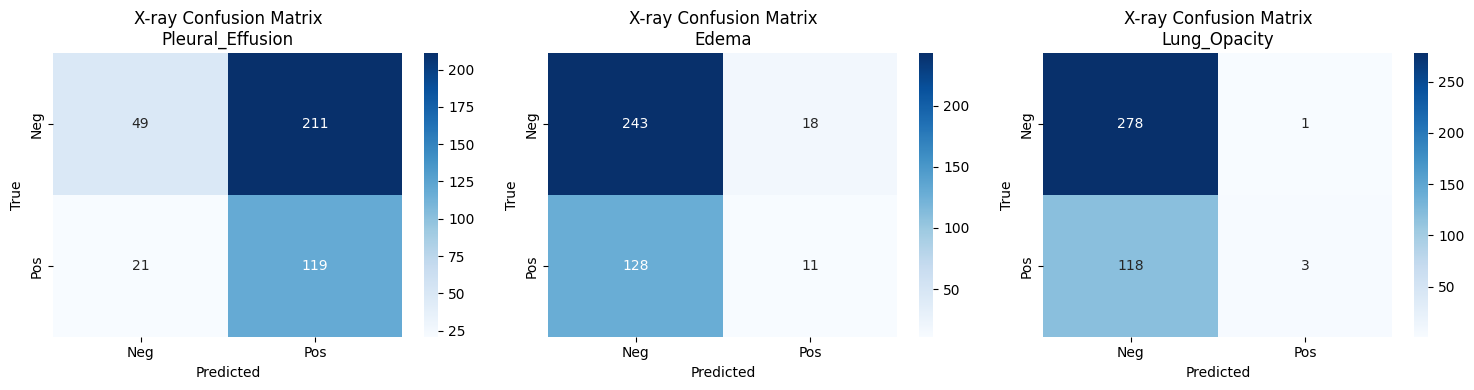

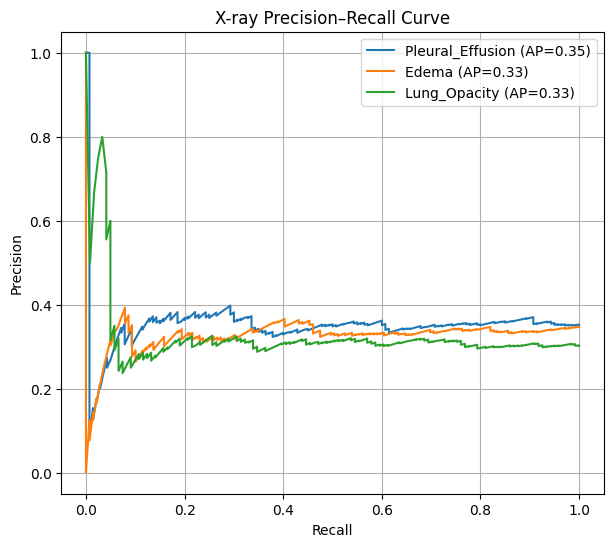

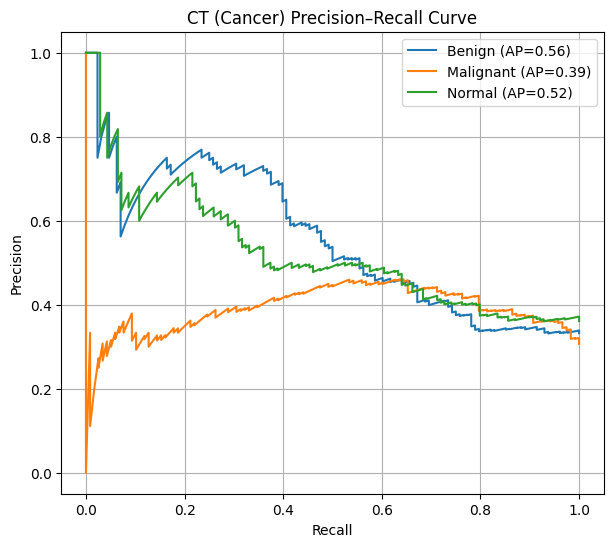


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.526316  0.468750  0.495868    128.0
Malignant      0.452381  0.483051  0.467213    118.0
Normal         0.489655  0.510791  0.500000    139.0
accuracy       0.488312  0.488312  0.488312    385.0
macro avg      0.489451  0.487531  0.487694    385.0
weighted avg   0.490419  0.488312  0.488577    385.0

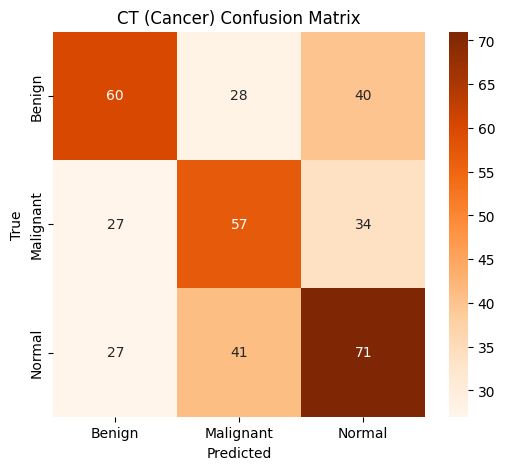

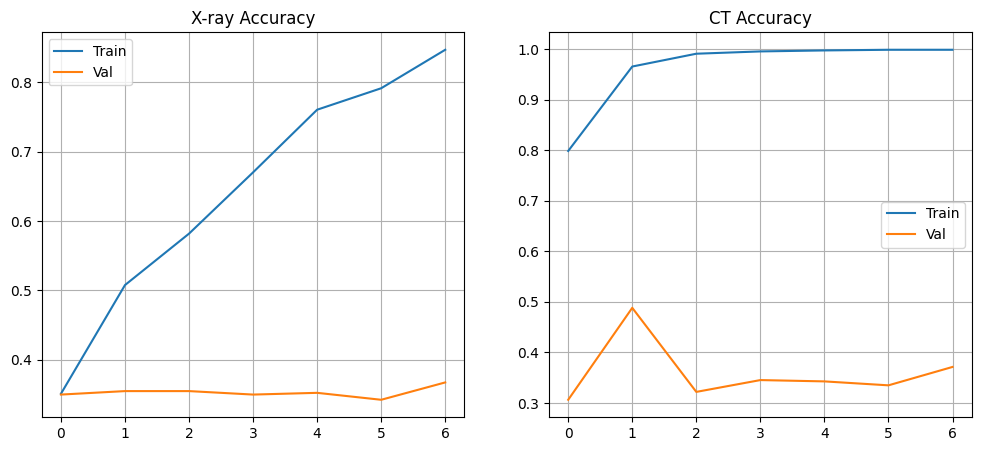

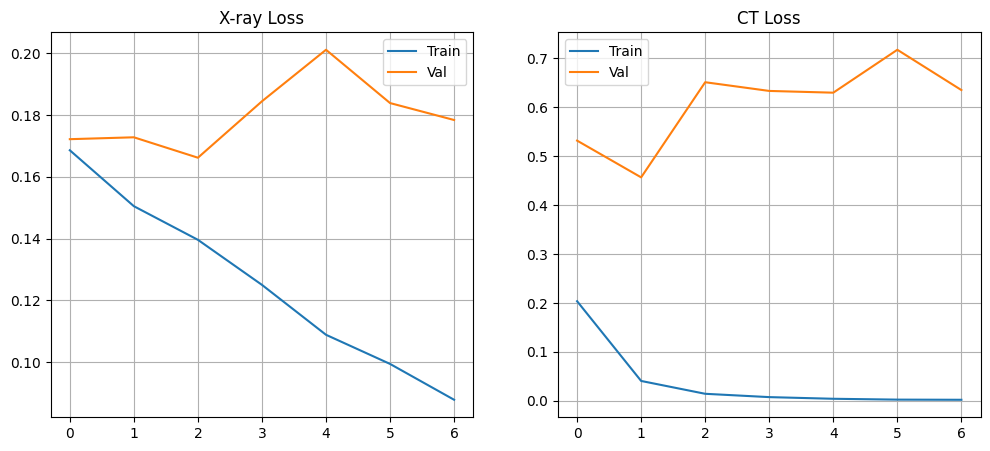

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiments with different base models**

In [16]:
# -------------------------------
# 1. IMPORTS
# -------------------------------
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, Model, callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize

from tensorflow.keras.applications import (
    EfficientNetB0,
    VGG16, VGG19,
    MobileNetV2,
    DenseNet121
)

# ViT (TensorFlow official)
from tensorflow.keras.layers import LayerNormalization


In [17]:
def get_backbone(backbone_name, input_shape=(224,224,3)):
    backbone_name = backbone_name.lower()

    if backbone_name == "efficientnet":
        return EfficientNetB0(
            include_top=False,
            weights="imagenet",
            pooling="avg"
        )

    elif backbone_name == "vgg16":
        return VGG16(
            include_top=False,
            weights="imagenet",
            pooling="avg"
        )

    elif backbone_name == "vgg19":
        return VGG19(
            include_top=False,
            weights="imagenet",
            pooling="avg"
        )

    elif backbone_name == "mobilenet":
        return MobileNetV2(
            include_top=False,
            weights="imagenet",
            pooling="avg"
        )

    elif backbone_name == "densenet121":
        return DenseNet121(
            include_top=False,
            weights="imagenet",
            pooling="avg"
        )

    elif backbone_name == "vit":
        # Simple ViT-style backbone (lightweight)
        inputs = layers.Input(shape=input_shape)

        x = layers.Conv2D(64, 16, strides=16, padding="valid")(inputs)
        x = layers.Reshape((-1, 64))(x)
        x = LayerNormalization()(x)

        for _ in range(4):
            attn = layers.MultiHeadAttention(
                num_heads=4, key_dim=64
            )(x, x)
            x = layers.Add()([x, attn])
            x = LayerNormalization()(x)

        x = layers.GlobalAveragePooling1D()(x)

        return Model(inputs, x, name="ViT_Backbone")

    else:
        raise ValueError(f"❌ Unknown backbone: {backbone_name}")


In [18]:
# -------------------------------
# 2. FOCAL LOSSES
# -------------------------------
class BinaryFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def call(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)
        loss = -y_true * tf.pow(1 - y_pred, self.gamma) * tf.math.log(y_pred) \
               - (1 - y_true) * tf.pow(y_pred, self.gamma) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)


class CategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def call(self, y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)
        loss = -y_true * tf.pow(1 - y_pred, self.gamma) * tf.math.log(y_pred)
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

In [19]:
# -------------------------------
# 3. IMAGE LOADER
# -------------------------------
def load_img(path):
    try:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        return img / 255.0
    except Exception as e:
        tf.print(f"ERROR loading image {path}: {e}")
        # Return a placeholder tensor of zeros if an image fails to load
        return tf.zeros((224, 224, 3), dtype=tf.float32)


In [20]:
# -------------------------------
# 4. DATASET BUILDERS
# -------------------------------
def build_xray_dataset(img_paths, labels, batch=16):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    ds = ds.map(lambda x, y: (load_img(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)


def build_ct_dataset(img_paths, labels, num_classes, batch=16):
    labels = tf.one_hot(labels, num_classes)
    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    ds = ds.map(lambda x, y: (load_img(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

In [21]:
# -------------------------------
# 5. MODEL (PHASE-1 CORRECT)
# -------------------------------
def build_phase1_model(
    num_xray_labels,
    num_ct_classes,
    backbone_name="efficientnet"
):
    encoder = get_backbone(backbone_name)

    x_in = layers.Input((224, 224, 3), name="xray_input")
    c_in = layers.Input((224, 224, 3), name="ct_input")

    x_feat = encoder(x_in)
    c_feat = encoder(c_in)

    x_feat = layers.Dense(512, activation="relu")(x_feat)
    c_feat = layers.Dense(512, activation="relu")(c_feat)

    x_out = layers.Dense(
        num_xray_labels,
        activation="sigmoid",
        name="xray_out"
    )(x_feat)

    c_out = layers.Dense(
        num_ct_classes,
        activation="softmax",
        name="ct_out"
    )(c_feat)

    return Model(
        inputs=[x_in, c_in],
        outputs=[x_out, c_out],
        name=f"Phase1_{backbone_name.upper()}"
    )


In [22]:
# -------------------------------
# 6. EVALUATION UTILITIES
# -------------------------------
def plot_pr_multilabel(y_true, y_pred, class_names, title):
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(class_names):
        p, r, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        ap = average_precision_score(y_true[:, i], y_pred[:, i])
        plt.plot(r, p, label=f"{cls} (AP={ap:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_pr_multiclass(
    y_true,
    y_pred,
    class_names,
    title="Multi-Class Precision–Recall Curve",
    show_micro=False
):
    """
    y_true: shape (N,) integer labels
    y_pred: shape (N, C) softmax probabilities
    """

    n_classes = len(class_names)

    # One-hot encode ground truth
    y_true_oh = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(7,6))

    # Per-class PR curves
    for i, cls in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(
            y_true_oh[:, i], y_pred[:, i]
        )
        ap = average_precision_score(
            y_true_oh[:, i], y_pred[:, i]
        )
        plt.plot(
            recall, precision,
            label=f"{cls} (AP={ap:.2f})"
        )

    # Optional micro-average
    if show_micro:
        precision_micro, recall_micro, _ = precision_recall_curve(
            y_true_oh.ravel(), y_pred.ravel()
        )
        ap_micro = average_precision_score(
            y_true_oh, y_pred, average="micro"
        )
        plt.plot(
            recall_micro,
            precision_micro,
            linestyle="--",
            linewidth=2,
            label=f"Micro-average (AP={ap_micro:.2f})"
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def diagnosis_report_multilabel(y_true, y_pred, class_names):
    y_pred_bin = (y_pred > 0.5).astype(int)
    report = classification_report(
        y_true, y_pred_bin,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    print("Report for Multi Label")
    print(report)
    return pd.DataFrame(report).transpose()[["precision","recall","f1-score","support"]]


def diagnosis_report_multiclass(y_true, y_pred, class_names):
    y_pred_cls = np.argmax(y_pred, axis=1)
    report = classification_report(
        y_true, y_pred_cls,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    print("Report for Multi Class")
    print(report)
    return pd.DataFrame(report).transpose()[["precision","recall","f1-score","support"]]


def plot_accuracy(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['xray_out_accuracy'], label="Train")
    plt.plot(history.history['val_xray_out_accuracy'], label="Val")
    plt.title("X-ray Accuracy")
    plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history['ct_out_accuracy'], label="Train")
    plt.plot(history.history['val_ct_out_accuracy'], label="Val")
    plt.title("CT Accuracy")
    plt.legend(); plt.grid(True)

    plt.show()


def plot_loss(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['xray_out_loss'], label="Train")
    plt.plot(history.history['val_xray_out_loss'], label="Val")
    plt.title("X-ray Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history['ct_out_loss'], label="Train")
    plt.plot(history.history['val_ct_out_loss'], label="Val")
    plt.title("CT Loss")
    plt.legend(); plt.grid(True)

    plt.show()


  ##########################################################
##  ✅ X-ray Confusion Matrices (Multi-label)############
##########################################################



def plot_xray_confusion_matrices(y_true, y_pred, class_names, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)

    n_classes = len(class_names)
    fig, axes = plt.subplots(1, n_classes, figsize=(5*n_classes, 4))

    if n_classes == 1:
        axes = [axes]

    for i, cls in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred_bin[:, i])
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Pos"],
            yticklabels=["Neg", "Pos"],
            ax=axes[i]
        )
        axes[i].set_title(f"X-ray Confusion Matrix\n{cls}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    plt.tight_layout()
    plt.show()


##########################################################
##  ✅ CT Confusion Matrix (Multi-class)#################
##########################################################

def plot_ct_confusion_matrix(y_true, y_pred, class_names):
    y_pred_cls = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred_cls)

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Oranges",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title("CT (Cancer) Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


###################################################
#####✅ Accuracy-Augmented Diagnosis Reports######
#####         X-Ray                           #####
###################################################
def diagnosis_report_multilabel_with_accuracy(y_true, y_pred, class_names, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(int)

    report = classification_report(
        y_true, y_pred_bin,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    df = pd.DataFrame(report).transpose()

    # Add overall accuracy (mean label accuracy)
    acc = (y_true == y_pred_bin).mean()
    df.loc["accuracy"] = [acc, acc, acc, y_true.shape[0]]

    return df[["precision", "recall", "f1-score", "support"]]


###################################################
#####✅ Accuracy-Augmented Diagnosis Reports######
#####         CT                           ########
###################################################
def diagnosis_report_multiclass_with_accuracy(y_true, y_pred, class_names):
    y_pred_cls = np.argmax(y_pred, axis=1)

    report = classification_report(
        y_true, y_pred_cls,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    df = pd.DataFrame(report).transpose()

    acc = accuracy_score(y_true, y_pred_cls)
    df.loc["accuracy"] = [acc, acc, acc, len(y_true)]

    return df[["precision", "recall", "f1-score", "support"]]

In [23]:
# -------------------------------
# 7. DATA LOADING HELPERS
# -------------------------------
def load_xray_data(root_dir, class_names, max_per_class=1000):
    imgs, labels = [], []
    print("\n📂 Loading X-ray data")

    for i, cls in enumerate(class_names):
        cls_dir = os.path.join(root_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        files = files[:max_per_class]

        print(f"  ▶ {cls}: {len(files)} images")

        for f in tqdm(files, desc=f"    Loading {cls}", leave=False):
            imgs.append(os.path.join(cls_dir, f))
            y = np.zeros(len(class_names))
            y[i] = 1
            labels.append(y)

    print(f"✅ Total X-ray images loaded: {len(imgs)}")
    return np.array(imgs), np.array(labels)

def load_ct_data(root_dir, class_names, max_per_class=700):
    imgs, labels = [], []
    print("\n📂 Loading CT data")

    for i, cls in enumerate(class_names):
        cls_dir = os.path.join(root_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        files = files[:max_per_class]

        print(f"  ▶ {cls}: {len(files)} images")

        for f in tqdm(files, desc=f"    Loading {cls}", leave=False):
            imgs.append(os.path.join(cls_dir, f))
            labels.append(i)

    print(f"✅ Total CT images loaded: {len(imgs)}")
    return np.array(imgs), np.array(labels)


class EpochLogger(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f"\n📌 Epoch {epoch+1}: "
            f"X-ray Acc={logs['xray_out_accuracy']:.3f}, "
            f"CT Acc={logs['ct_out_accuracy']:.3f}, "
            f"Val X-ray Acc={logs['val_xray_out_accuracy']:.3f}, "
            f"Val CT Acc={logs['val_ct_out_accuracy']:.3f}"
        )



In [24]:
# -------------------------------
# 8. DATA LOADING Function
# -------------------------------

def load_and_prepare_data():
    X_RAY_DIR = '/content/drive/MyDrive/Kaggel_direct_download/AP_Frontal_CheXpert/1000_nos'
    CT_DIR    = '/content/drive/MyDrive/Kaggel_direct_download/Cancer_Dataset/Lung_Cancer_LIDC_Y_Net/LIDC_Y-Net'

    xray_class_names = ['Pleural_Effusion', 'Edema', 'Lung_Opacity']
    ct_class_names   = ['Benign', 'Malignant', 'Normal']

    # Load raw data
    xray_imgs, xray_labels = load_xray_data(X_RAY_DIR, xray_class_names)
    ct_imgs, ct_labels     = load_ct_data(CT_DIR, ct_class_names)

    # Split
    x_tr, x_va, yx_tr, yx_va = train_test_split(
        xray_imgs, xray_labels, test_size=0.2, random_state=42
    )
    c_tr, c_va, yc_tr, yc_va = train_test_split(
        ct_imgs, ct_labels, test_size=0.2, random_state=42
    )

    print("\n📊 Dataset Summary")
    print(f"  X-ray Train: {len(x_tr)} | Val: {len(x_va)}")
    print(f"  CT    Train: {len(c_tr)} | Val: {len(c_va)}")

    # Build tf.data datasets
    train_xray_ds = build_xray_dataset(x_tr, yx_tr)
    val_xray_ds   = build_xray_dataset(x_va, yx_va)

    train_ct_ds = build_ct_dataset(c_tr, yc_tr, len(ct_class_names))
    val_ct_ds   = build_ct_dataset(c_va, yc_va, len(ct_class_names))

    train_ds = tf.data.Dataset.zip((train_xray_ds, train_ct_ds))
    val_ds   = tf.data.Dataset.zip((val_xray_ds, val_ct_ds))

    train_ds = train_ds.map(
        lambda x, c: (
            {"xray_input": x[0], "ct_input": c[0]},
            {"xray_out": x[1], "ct_out": c[1]}
        )
    )

    val_ds = val_ds.map(
        lambda x, c: (
            {"xray_input": x[0], "ct_input": c[0]},
            {"xray_out": x[1], "ct_out": c[1]}
        )
    )

    return train_ds, val_ds, xray_class_names, ct_class_names


In [25]:
# -------------------------------
# 9. BUILD AND COMPILE Function
# -------------------------------

def build_and_compile_model(
    xray_class_names,
    ct_class_names,
    backbone_name="efficientnet"
):
    model = build_phase1_model(
        len(xray_class_names),
        len(ct_class_names),
        backbone_name=backbone_name
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss={
            "xray_out": BinaryFocalLoss(),
            "ct_out": CategoricalFocalLoss()
        },
        metrics={
            "xray_out": "accuracy",
            "ct_out": "accuracy"
        }
    )

    model.summary()
    return model


In [26]:
# -------------------------------
# 10. TRAINING Function
# -------------------------------

def train_model(model, train_ds, val_ds):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[
            callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
            EpochLogger()
        ]
    )
    return history

In [27]:
# -------------------------------
# 11. VALIDATION Function
# -------------------------------

def run_validation(model, val_ds):
    print("\n🔍 Running validation & prediction")

    xray_true, xray_pred = [], []
    ct_true, ct_pred = [], []

    val_steps = tf.data.experimental.cardinality(val_ds).numpy()

    for inputs, targets in tqdm(val_ds, desc="Validating", total=val_steps):

        # ✅ CALL MODEL DIRECTLY (NOT model.predict)
        preds = model(
            {
                "xray_input": inputs["xray_input"],
                "ct_input": inputs["ct_input"]
            },
            training=False
        )

        xray_pred.append(preds[0].numpy())
        ct_pred.append(preds[1].numpy())

        xray_true.append(targets["xray_out"].numpy())
        ct_true.append(targets["ct_out"].numpy())

    print("✅ Validation complete")

    xray_true = np.vstack(xray_true)
    xray_pred = np.vstack(xray_pred)

    ct_true = np.argmax(np.vstack(ct_true), axis=1)
    ct_pred = np.vstack(ct_pred)

    return xray_true, xray_pred, ct_true, ct_pred


In [28]:
# -------------------------------
# 12. EVALUATION Function
# -------------------------------


def run_reports_and_plots(
    xray_true, xray_pred,
    ct_true, ct_pred,
    xray_class_names, ct_class_names,
    history
):

    # =======================
    # X-RAY REPORT
    # =======================
    print("\nX-RAY DIAGNOSIS REPORT (WITH ACCURACY)")
    display(
        diagnosis_report_multilabel_with_accuracy(
            xray_true, xray_pred, xray_class_names
        )
    )

    plot_xray_confusion_matrices(
        xray_true, xray_pred, xray_class_names
    )

    plot_pr_multilabel(
        xray_true, xray_pred,
        xray_class_names,
        "X-ray Precision–Recall Curve"
    )

    plot_pr_multiclass(
              ct_true,
              ct_pred,
              ct_class_names,
              title="CT (Cancer) Precision–Recall Curve"
          )


    # =======================
    # CT REPORT
    # =======================
    print("\nCT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)")
    display(
        diagnosis_report_multiclass_with_accuracy(
            ct_true, ct_pred, ct_class_names
        )
    )

    plot_ct_confusion_matrix(
        ct_true, ct_pred, ct_class_names
    )

    # =======================
    # TRAINING CURVES
    # =======================
    plot_accuracy(history)
    plot_loss(history)


In [ ]:
######################################################################
########### Function Execution Started ###############################
######################################################################

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data()


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


In [ ]:
# model = build_and_compile_model(xray_classes, ct_classes)
model = build_and_compile_model(
    xray_classes,
    ct_classes,
    backbone_name="mobilenet"   # try: vgg16, densenet121, vit
)




/tmp/ipython-input-1439143182.py:26: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_MOBILENET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 1280)      │  2,257,984 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    655,872 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    655,872 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,572,806 (13.63 MB)

 Trainable params: 3,538,694 (13.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)



Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - ct_out_accuracy: 0.7034 - ct_out_loss: 0.2735 - loss: 0.4666 - xray_out_accuracy: 0.3179 - xray_out_loss: 0.1931
📌 Epoch 1: X-ray Acc=0.326, CT Acc=0.827, Val X-ray Acc=0.340, Val CT Acc=0.644
97/97 ━━━━━━━━━━━━━━━━━━━━ 138s 711ms/step - ct_out_accuracy: 0.7046 - ct_out_loss: 0.2724 - loss: 0.4654 - xray_out_accuracy: 0.3179 - xray_out_loss: 0.1930 - val_ct_out_accuracy: 0.6442 - val_ct_out_loss: 0.3258 - val_loss: 0.5296 - val_xray_out_accuracy: 0.3400 - val_xray_out_loss: 0.1943 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - ct_out_accuracy: 0.9900 - ct_out_loss: 0.0136 - loss: 0.1514 - xray_out_accuracy: 0.5878 - xray_out_loss: 0.1378
📌 Epoch 2: X-ray Acc=0.626, CT Acc=0.992, Val X-ray Acc=0.330, Val CT Acc=0.748
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - ct_out_accuracy: 0.9900 - ct_out_loss: 0.0136 - loss: 0.1513 - xray_out_accuracy: 0.5882 - xray_out_loss: 0.1378 - val_ct_out_accuracy: 0.748

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)




🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.37it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.341615  0.785714  0.476190    140.0
Edema              0.387755  0.136691  0.202128    139.0
Lung_Opacity       0.441176  0.123967  0.193548    121.0
micro avg          0.355556  0.360000  0.357764    400.0
macro avg          0.390182  0.348791  0.290622    400.0
weighted avg       0.387766  0.360000  0.295454    400.0
samples avg        0.298750  0.360000  0.319167    400.0
accuracy           0.569167  0.569167  0.569167    400.0

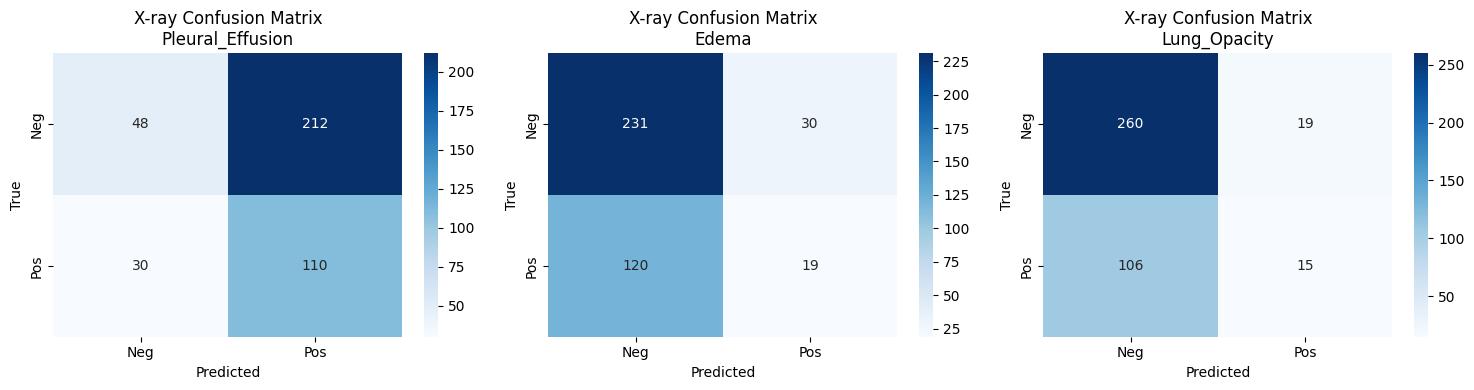

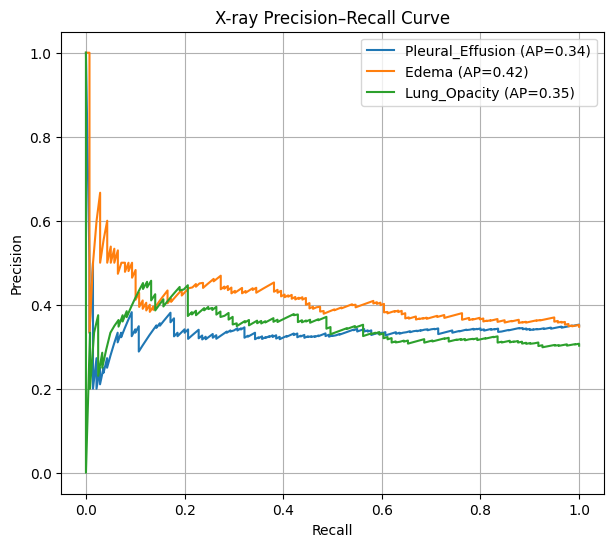

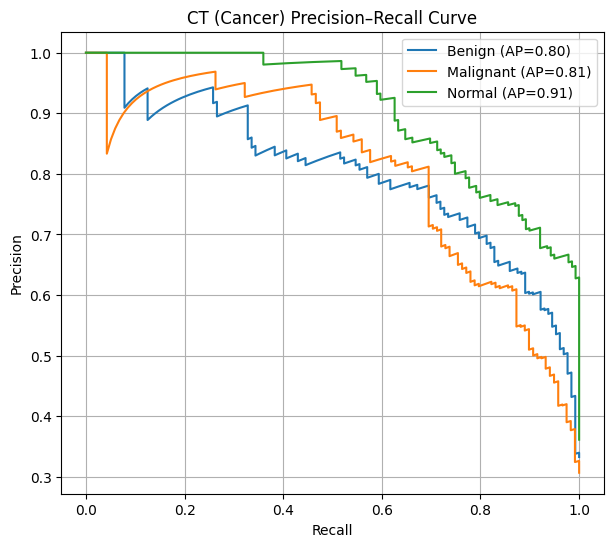


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.792079  0.625000  0.698690    128.0
Malignant      0.747664  0.677966  0.711111    118.0
Normal         0.723164  0.920863  0.810127    139.0
accuracy       0.748052  0.748052  0.748052    385.0
macro avg      0.754302  0.741276  0.739976    385.0
weighted avg   0.753585  0.748052  0.742730    385.0

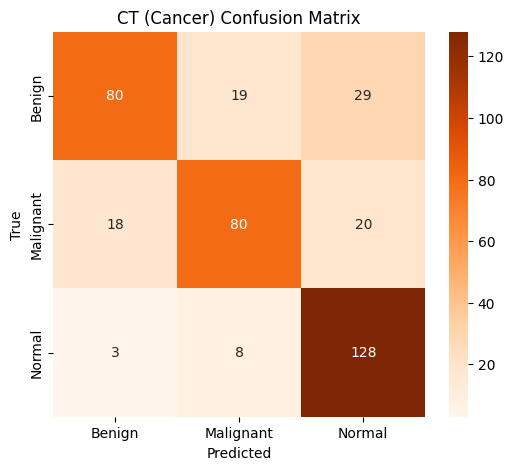

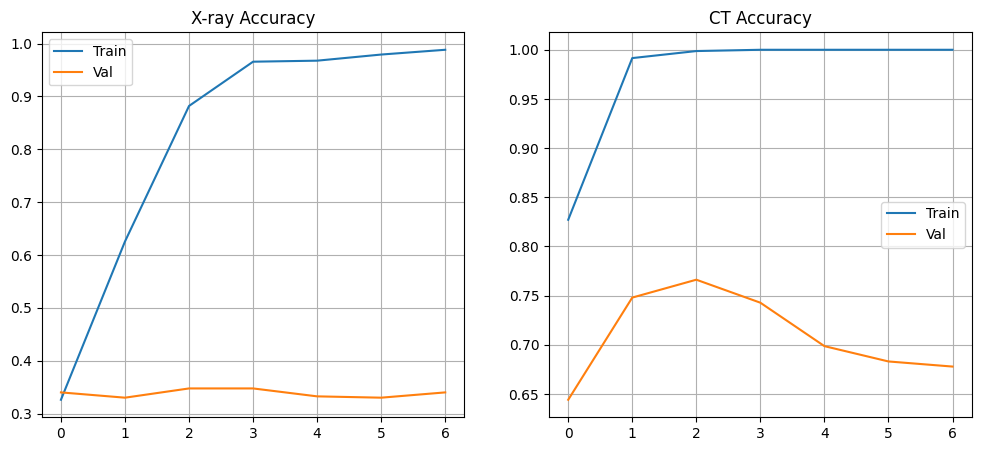

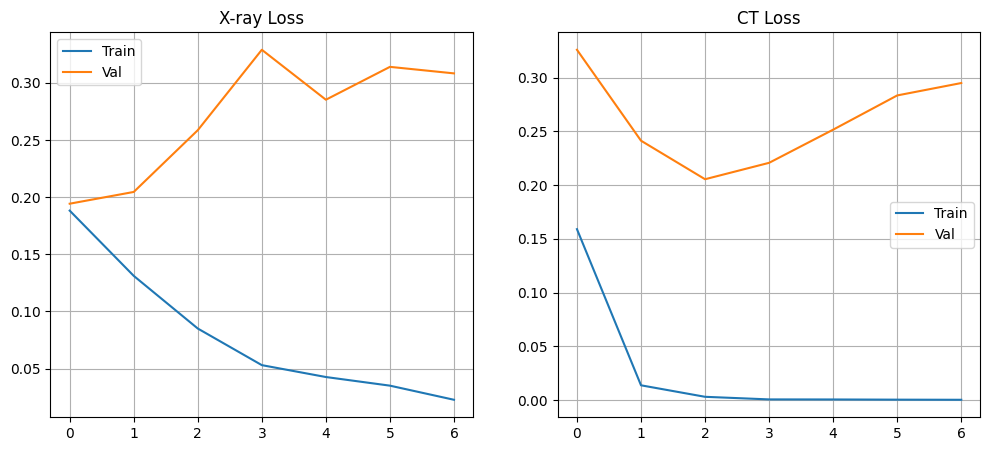

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**VGG16**

In [ ]:
# model = build_and_compile_model(xray_classes, ct_classes)
model = build_and_compile_model(
    xray_classes,
    ct_classes,
    backbone_name="vgg16"   # try: vgg16, densenet121, vit
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 512)       │ 14,714,688 │ xray_input[0][0], │
│                     │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    262,656 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    262,656 │ vgg16[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,243,078 (58.15 MB)

 Trainable params: 15,243,078 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - ct_out_accuracy: 0.4737 - ct_out_loss: 0.4322 - loss: 0.6002 - xray_out_accuracy: 0.3147 - xray_out_loss: 0.1680
📌 Epoch 1: X-ray Acc=0.321, CT Acc=0.576, Val X-ray Acc=0.317, Val CT Acc=0.421
97/97 ━━━━━━━━━━━━━━━━━━━━ 105s 779ms/step - ct_out_accuracy: 0.4747 - ct_out_loss: 0.4316 - loss: 0.5995 - xray_out_accuracy: 0.3148 - xray_out_loss: 0.1679 - val_ct_out_accuracy: 0.4208 - val_ct_out_loss: 0.4101 - val_loss: 0.5769 - val_xray_out_accuracy: 0.3175 - val_xray_out_loss: 0.1668 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - ct_out_accuracy: 0.6290 - ct_out_loss: 0.2982 - loss: 0.4609 - xray_out_accuracy: 0.3453 - xray_out_loss: 0.1628
📌 Epoch 2: X-ray Acc=0.336, CT Acc=0.700, Val X-ray Acc=0.357, Val CT Acc=0.810
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 553ms/step - ct_out_accuracy: 0.6297 - ct_out_loss: 0.2976 - loss: 0.4603 - xray_out_accuracy: 0.3452 - xray_out_loss: 0.1628 - val_ct_out_accuracy: 0.810

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:06<00:00,  3.63it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.352941  0.042857  0.076433    140.0
Edema              0.518519  0.100719  0.168675    139.0
Lung_Opacity       0.312500  0.082645  0.130719    121.0
micro avg          0.394737  0.075000  0.126050    400.0
macro avg          0.394653  0.075407  0.125276    400.0
weighted avg       0.398246  0.075000  0.124909    400.0
samples avg        0.075000  0.075000  0.075000    400.0
accuracy           0.653333  0.653333  0.653333    400.0

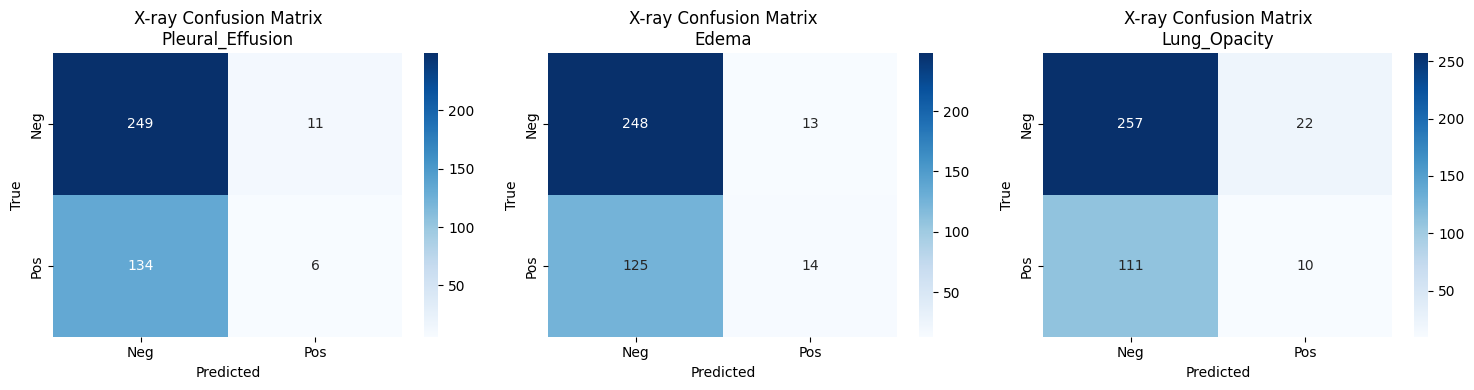

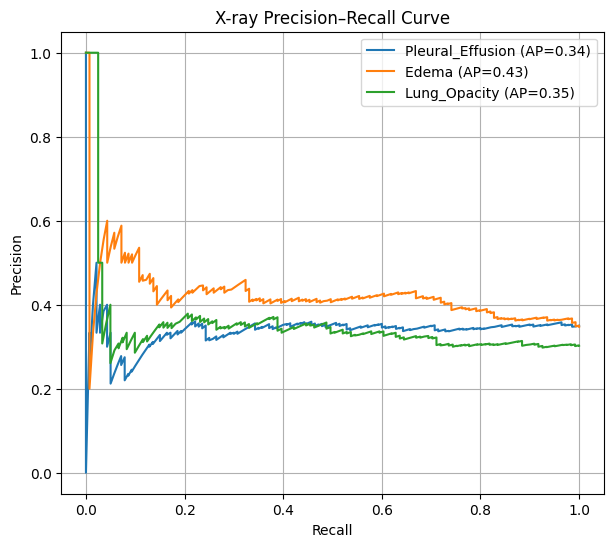

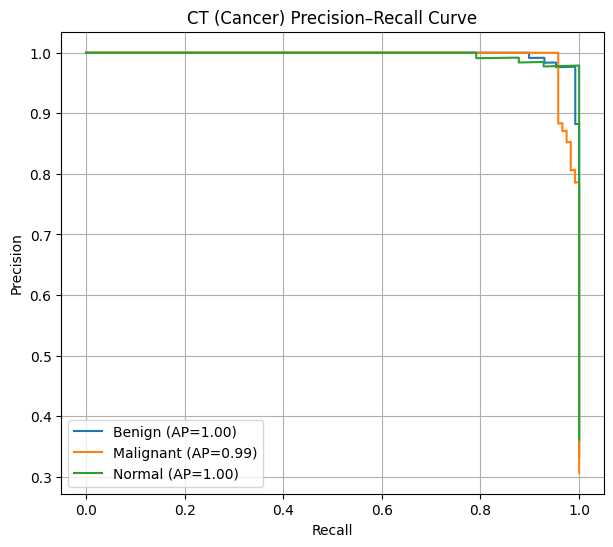


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.976744  0.984375  0.980545    128.0
Malignant      0.974138  0.957627  0.965812    118.0
Normal         0.978571  0.985612  0.982079    139.0
accuracy       0.976623  0.976623  0.976623    385.0
macro avg      0.976485  0.975871  0.976145    385.0
weighted avg   0.976605  0.976623  0.976583    385.0

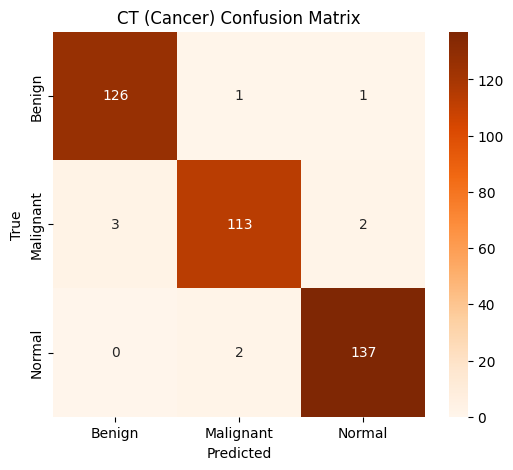

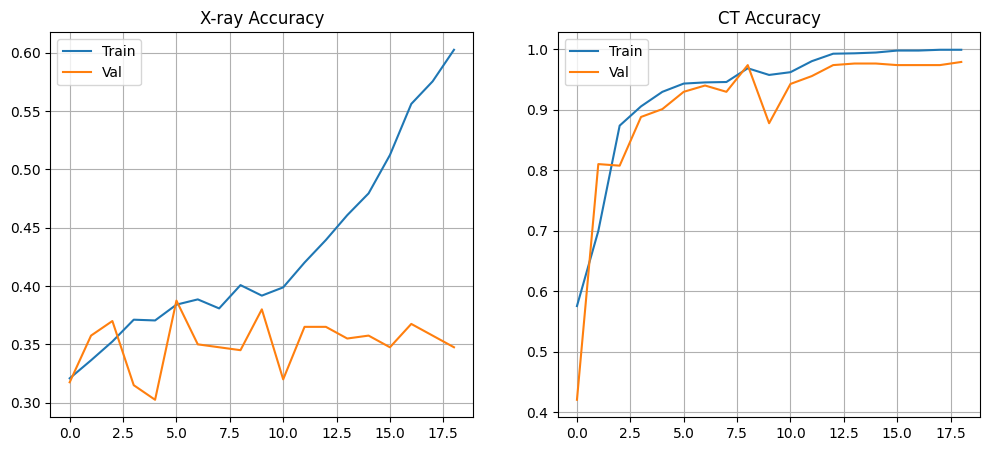

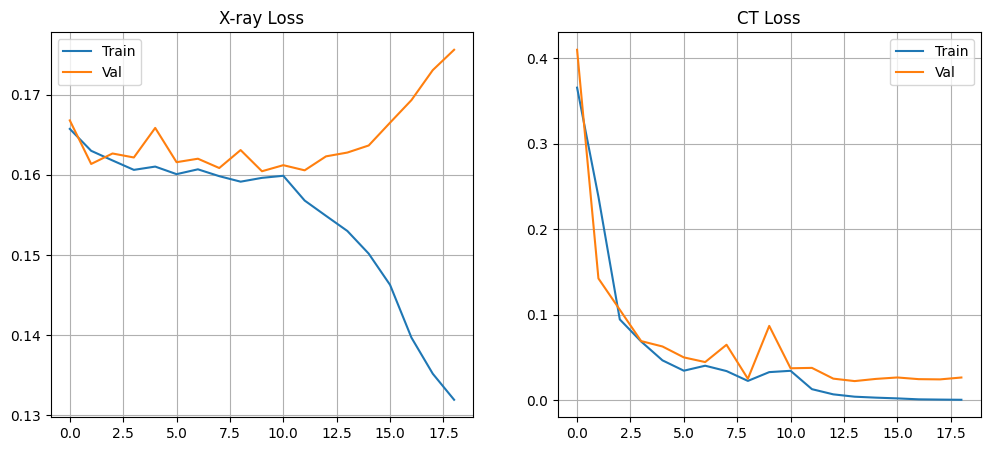

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment on VGG19**

In [ ]:
model = build_and_compile_model(
    xray_classes,
    ct_classes,
    backbone_name="vgg19"   # try: vgg16, densenet121, vit
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_VGG19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 512)       │ 20,024,384 │ xray_input[0][0], │
│                     │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    262,656 │ vgg19[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    262,656 │ vgg19[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,552,774 (78.40 MB)

 Trainable params: 20,552,774 (78.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - ct_out_accuracy: 0.3863 - ct_out_loss: 0.5064 - loss: 0.6725 - xray_out_accuracy: 0.3319 - xray_out_loss: 0.1662
📌 Epoch 1: X-ray Acc=0.341, CT Acc=0.374, Val X-ray Acc=0.303, Val CT Acc=0.312
97/97 ━━━━━━━━━━━━━━━━━━━━ 85s 756ms/step - ct_out_accuracy: 0.3862 - ct_out_loss: 0.5062 - loss: 0.6724 - xray_out_accuracy: 0.3320 - xray_out_loss: 0.1661 - val_ct_out_accuracy: 0.3117 - val_ct_out_loss: 0.4927 - val_loss: 0.6519 - val_xray_out_accuracy: 0.3025 - val_xray_out_loss: 0.1615 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - ct_out_accuracy: 0.3468 - ct_out_loss: 0.4889 - loss: 0.6500 - xray_out_accuracy: 0.3468 - xray_out_loss: 0.1611
📌 Epoch 2: X-ray Acc=0.335, CT Acc=0.353, Val X-ray Acc=0.350, Val CT Acc=0.361
97/97 ━━━━━━━━━━━━━━━━━━━━ 65s 670ms/step - ct_out_accuracy: 0.3468 - ct_out_loss: 0.4889 - loss: 0.6500 - xray_out_accuracy: 0.3467 - xray_out_loss: 0.1611 - val_ct_out_accuracy: 0.3610

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.285714  0.014286  0.027211    140.0
Edema              0.500000  0.014388  0.027972    139.0
Lung_Opacity       0.333333  0.016529  0.031496    121.0
micro avg          0.352941  0.015000  0.028777    400.0
macro avg          0.373016  0.015068  0.028893    400.0
weighted avg       0.374583  0.015000  0.028772    400.0
samples avg        0.015000  0.015000  0.015000    400.0
accuracy           0.662500  0.662500  0.662500    400.0

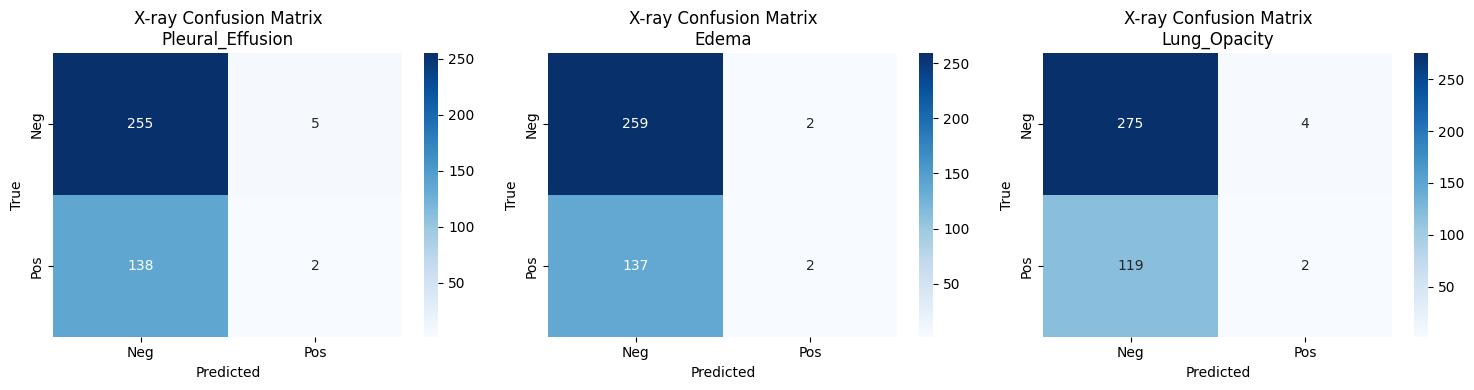

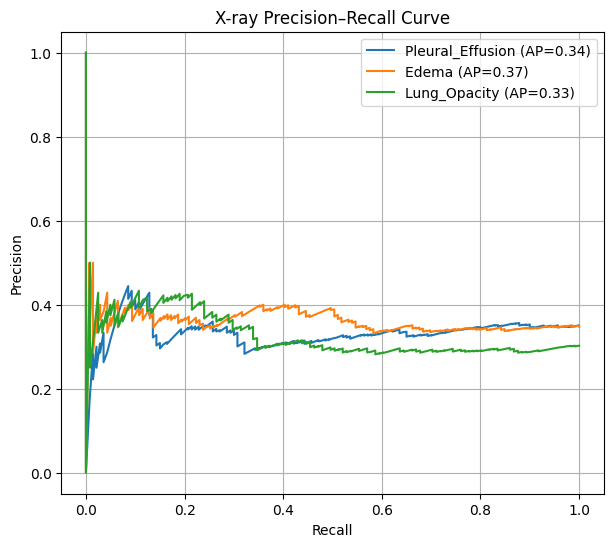

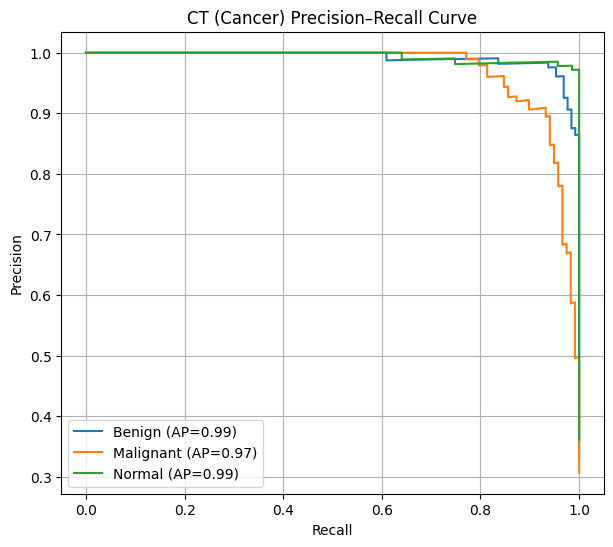


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.905797  0.976562  0.939850    128.0
Malignant      0.927273  0.864407  0.894737    118.0
Normal         0.978102  0.964029  0.971014    139.0
accuracy       0.937662  0.937662  0.937662    385.0
macro avg      0.937057  0.934999  0.935200    385.0
weighted avg   0.938484  0.937662  0.937275    385.0

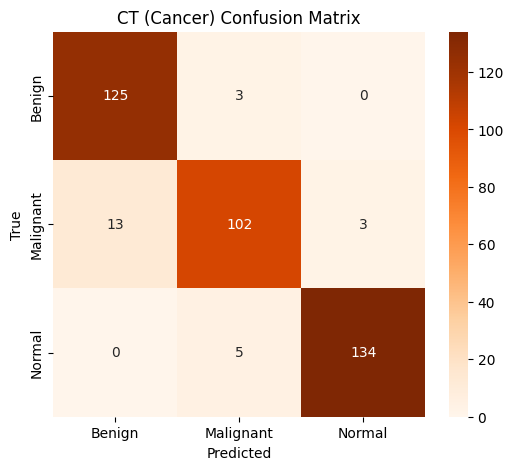

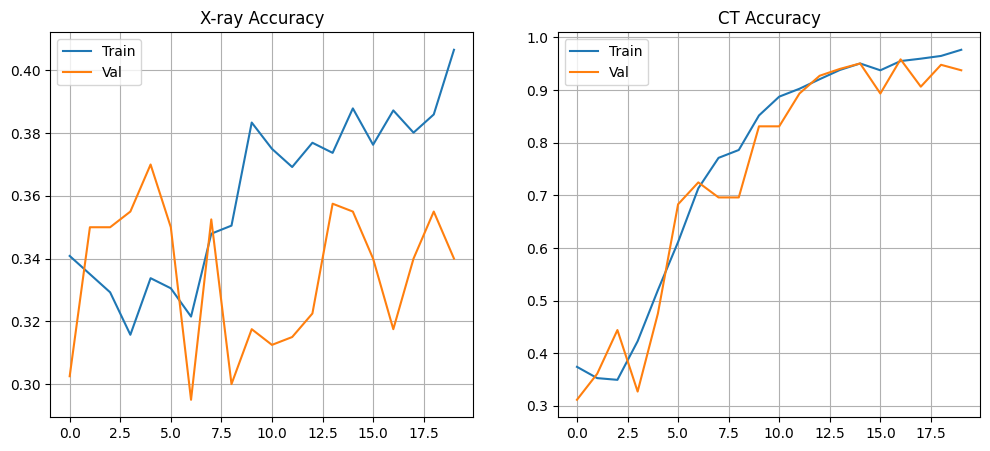

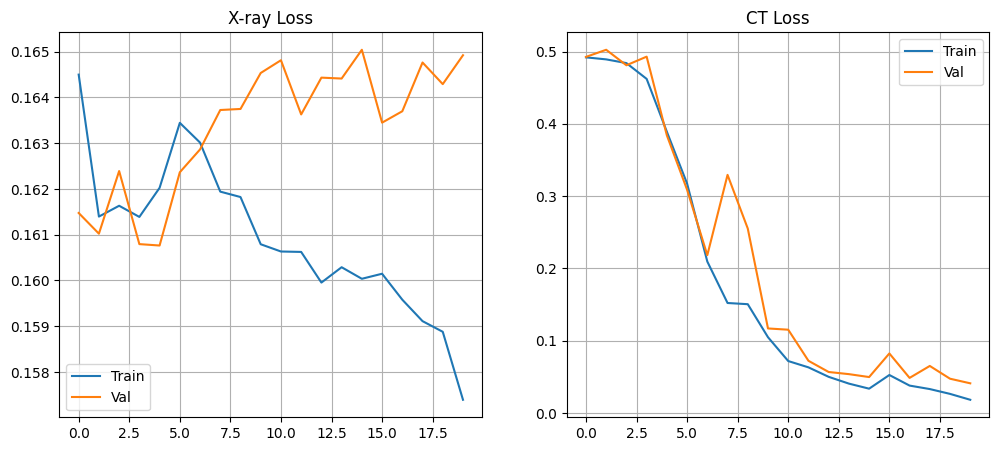

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with densenet121**

In [ ]:
model = build_and_compile_model(
    xray_classes,
    ct_classes,
    backbone_name="densenet121"   # try: vgg16, densenet121, vit
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_DENSENET121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 1024)      │  7,037,504 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    524,800 │ densenet121[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │    524,800 │ densenet121[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,090,182 (30.86 MB)

 Trainable params: 8,006,534 (30.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - ct_out_accuracy: 0.7671 - ct_out_loss: 0.2452 - loss: 0.4405 - xray_out_accuracy: 0.3256 - xray_out_loss: 0.1953   
📌 Epoch 1: X-ray Acc=0.314, CT Acc=0.862, Val X-ray Acc=0.300, Val CT Acc=0.649
97/97 ━━━━━━━━━━━━━━━━━━━━ 625s 4s/step - ct_out_accuracy: 0.7681 - ct_out_loss: 0.2441 - loss: 0.4394 - xray_out_accuracy: 0.3255 - xray_out_loss: 0.1953 - val_ct_out_accuracy: 0.6494 - val_ct_out_loss: 0.4337 - val_loss: 0.5687 - val_xray_out_accuracy: 0.3000 - val_xray_out_loss: 0.1984 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - ct_out_accuracy: 0.9841 - ct_out_loss: 0.0162 - loss: 0.1699 - xray_out_accuracy: 0.4799 - xray_out_loss: 0.1537
📌 Epoch 2: X-ray Acc=0.529, CT Acc=0.984, Val X-ray Acc=0.282, Val CT Acc=0.751
97/97 ━━━━━━━━━━━━━━━━━━━━ 29s 299ms/step - ct_out_accuracy: 0.9841 - ct_out_loss: 0.0162 - loss: 0.1698 - xray_out_accuracy: 0.4804 - xray_out_loss: 0.1536 - val_ct_out_accuracy: 0.7506 -

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.300000  0.214286  0.250000    140.0
Edema              0.313514  0.417266  0.358025    139.0
Lung_Opacity       0.277778  0.165289  0.207254    121.0
micro avg          0.302521  0.270000  0.285337    400.0
macro avg          0.297097  0.265614  0.271760    400.0
weighted avg       0.297974  0.270000  0.274608    400.0
samples avg        0.242500  0.270000  0.251667    400.0
accuracy           0.549167  0.549167  0.549167    400.0

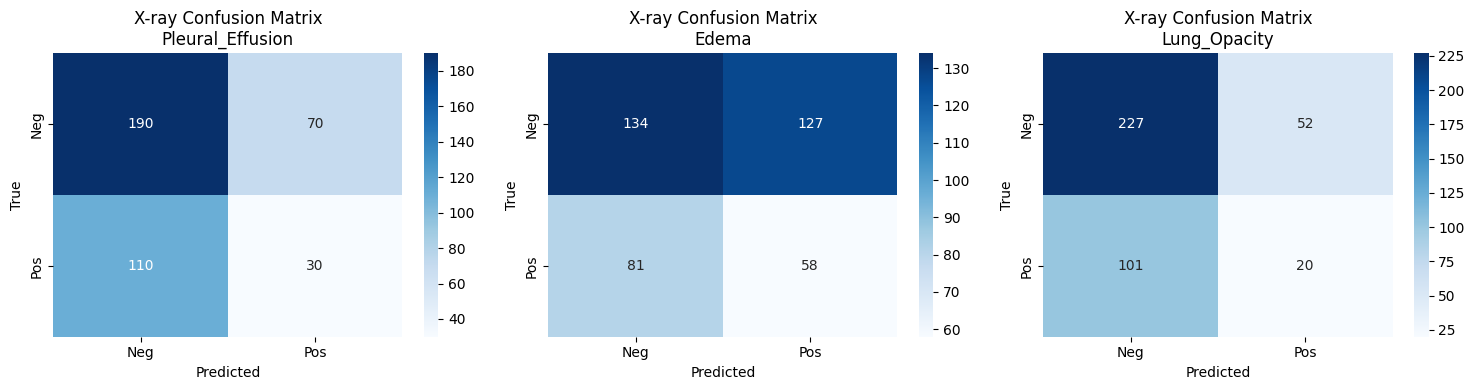

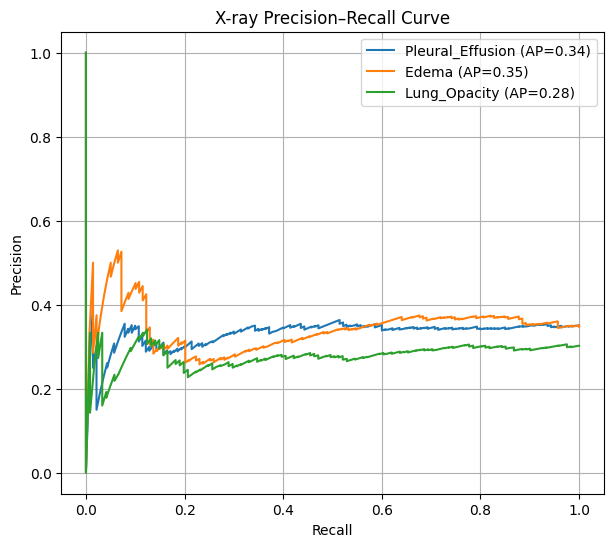

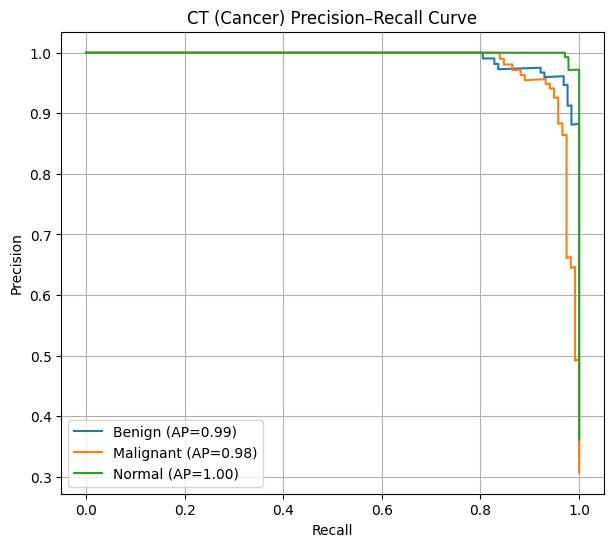


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.946970  0.976562  0.961538    128.0
Malignant      0.955752  0.915254  0.935065    118.0
Normal         0.978571  0.985612  0.982079    139.0
accuracy       0.961039  0.961039  0.961039    385.0
macro avg      0.960431  0.959143  0.959561    385.0
weighted avg   0.961071  0.961039  0.960840    385.0

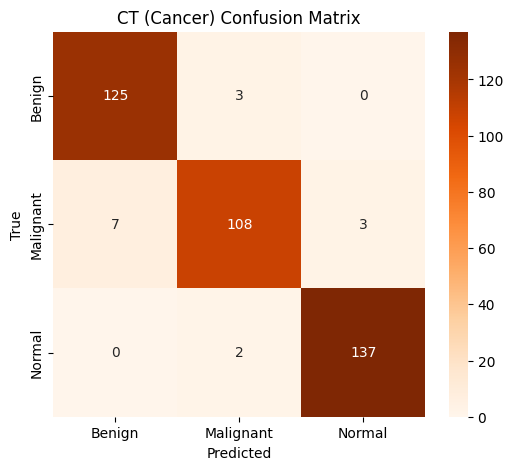

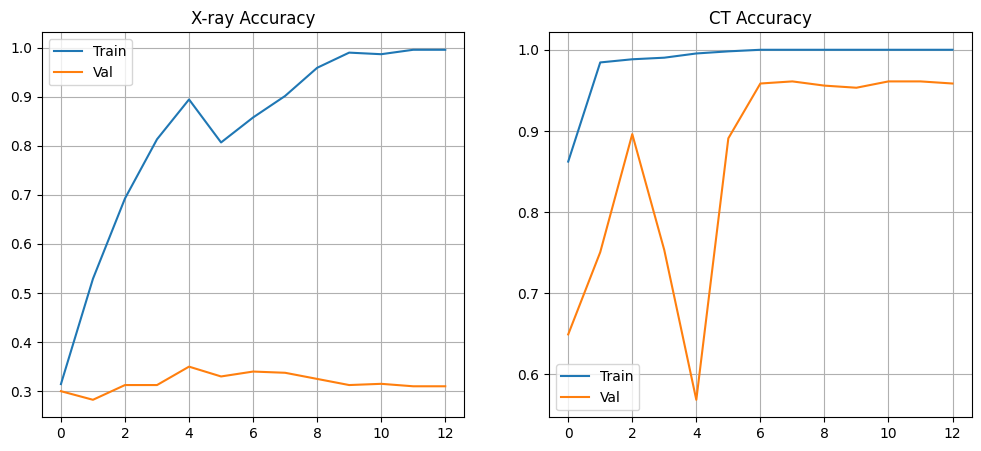

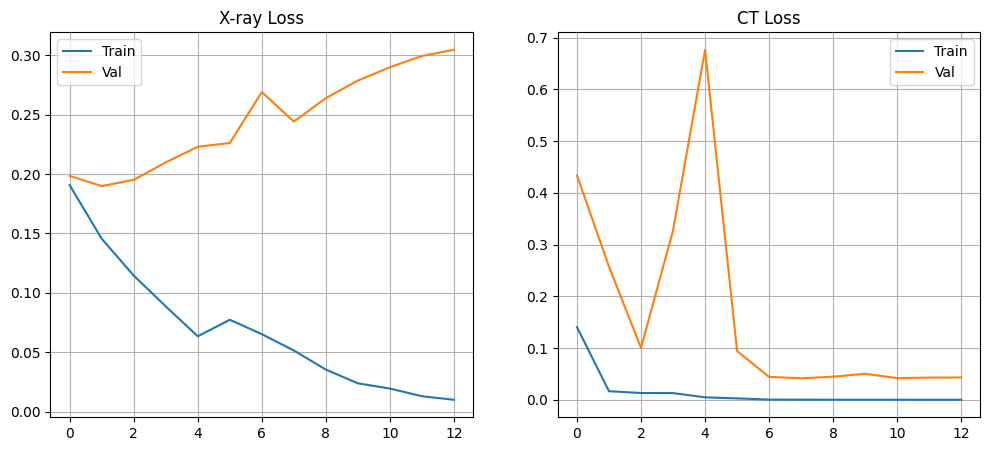

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )


**Experiment with vit**

In [ ]:
model = build_and_compile_model(
    xray_classes,
    ct_classes,
    backbone_name="vit"   # try: vgg16, densenet121, vit
)


Model: "Phase1_VIT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ViT_Backbone        │ (None, 64)        │    315,328 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │     33,280 │ ViT_Backbone[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 512)       │     33,280 │ ViT_Backbone[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 384,966 (1.47 MB)

 Trainable params: 384,966 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - ct_out_accuracy: 0.3517 - ct_out_loss: 0.4890 - loss: 0.6496 - xray_out_accuracy: 0.3335 - xray_out_loss: 0.1607
📌 Epoch 1: X-ray Acc=0.327, CT Acc=0.344, Val X-ray Acc=0.303, Val CT Acc=0.306
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - ct_out_accuracy: 0.3516 - ct_out_loss: 0.4890 - loss: 0.6496 - xray_out_accuracy: 0.3334 - xray_out_loss: 0.1607 - val_ct_out_accuracy: 0.3065 - val_ct_out_loss: 0.4961 - val_loss: 0.6535 - val_xray_out_accuracy: 0.3025 - val_xray_out_loss: 0.1610 - learning_rate: 1.2500e-05
Epoch 2/20
95/97 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - ct_out_accuracy: 0.3338 - ct_out_loss: 0.4889 - loss: 0.6496 - xray_out_accuracy: 0.3427 - xray_out_loss: 0.1606
📌 Epoch 2: X-ray Acc=0.332, CT Acc=0.340, Val X-ray Acc=0.303, Val CT Acc=0.306
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - ct_out_accuracy: 0.3340 - ct_out_loss: 0.4889 - loss: 0.6496 - xray_out_accuracy: 0.3424 - xray_out_loss: 0.1606 - val_ct_out_accuracy: 0.3065 - val

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:02<00:00,  8.99it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.000000  0.000000  0.000000    140.0
Edema              0.000000  0.000000  0.000000    139.0
Lung_Opacity       0.000000  0.000000  0.000000    121.0
micro avg          0.000000  0.000000  0.000000    400.0
macro avg          0.000000  0.000000  0.000000    400.0
weighted avg       0.000000  0.000000  0.000000    400.0
samples avg        0.000000  0.000000  0.000000    400.0
accuracy           0.666667  0.666667  0.666667    400.0

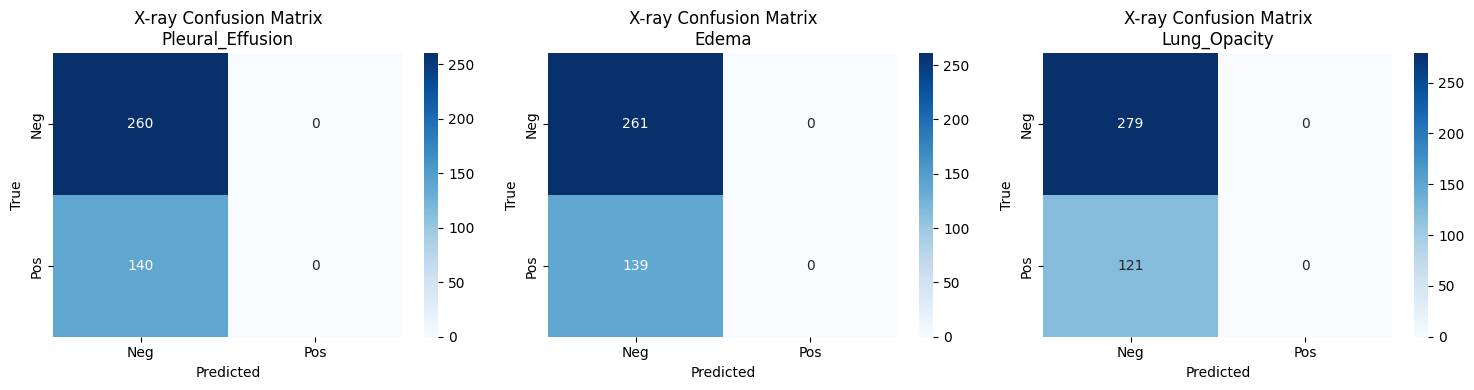

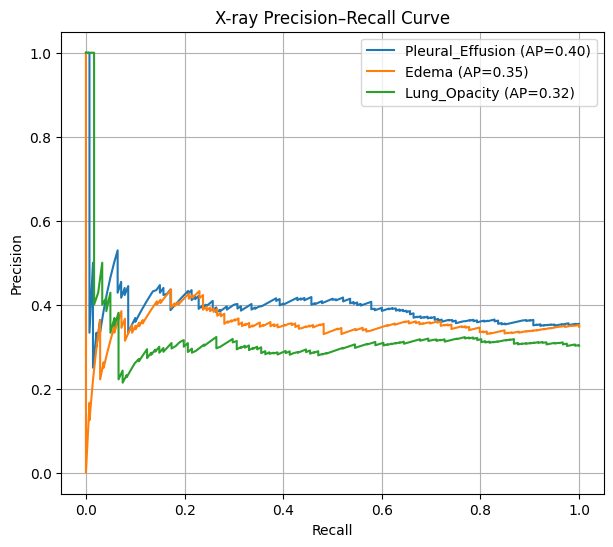

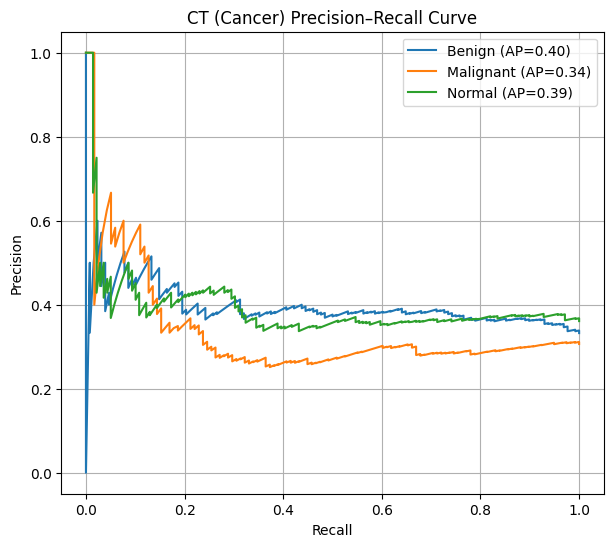


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.000000  0.000000  0.000000    128.0
Malignant      0.306494  1.000000  0.469185    118.0
Normal         0.000000  0.000000  0.000000    139.0
accuracy       0.306494  0.306494  0.306494    385.0
macro avg      0.102165  0.333333  0.156395    385.0
weighted avg   0.093938  0.306494  0.143802    385.0

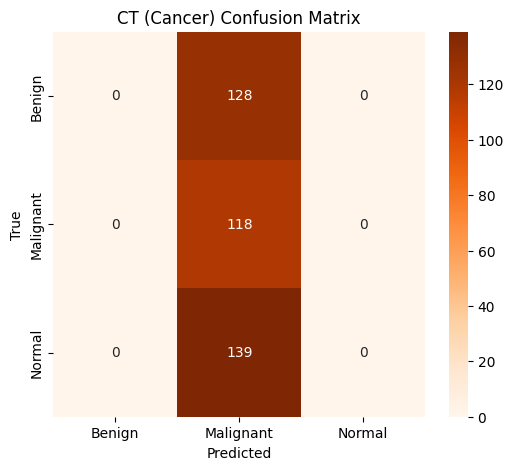

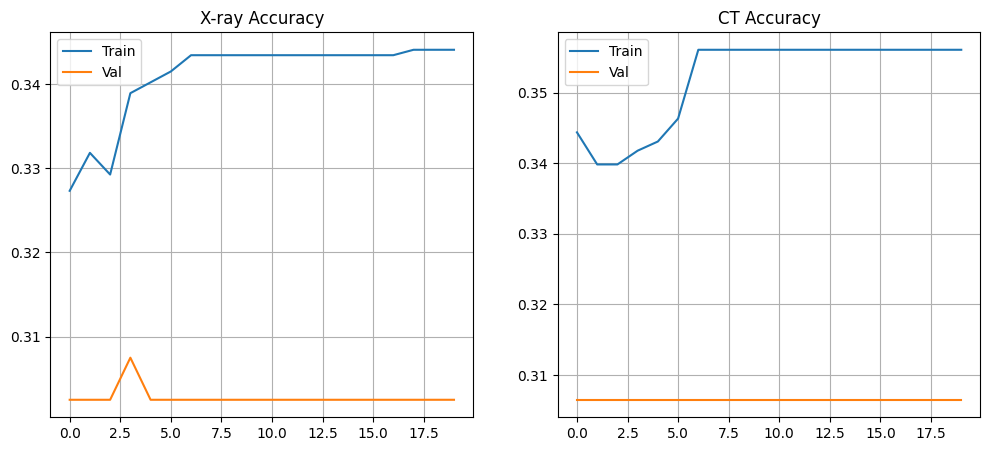

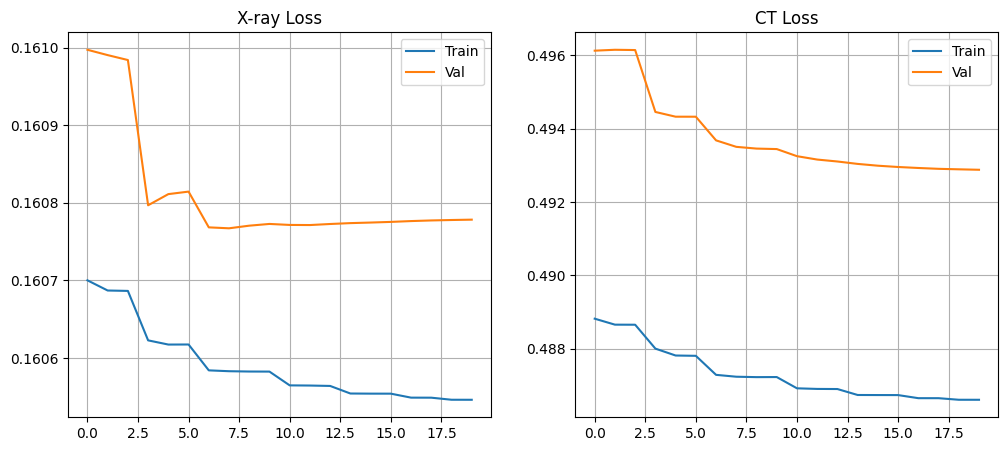

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experimenting Pre-trained models**

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import (
    Xception,
    VGG16, VGG19,
    ResNet50, ResNet50V2,
    ResNet101, ResNet101V2,
    ResNet152, ResNet152V2,
    InceptionV3, InceptionResNetV2,
    MobileNet, MobileNetV2,
    DenseNet121, DenseNet169, DenseNet201,
    NASNetMobile, NASNetLarge,
    EfficientNetB0, EfficientNetB1, EfficientNetB2,
    EfficientNetB3, EfficientNetB4, EfficientNetB5,
    EfficientNetB6, EfficientNetB7,
    EfficientNetV2B0, EfficientNetV2B1,
    EfficientNetV2B2, EfficientNetV2B3,
    EfficientNetV2S, EfficientNetV2M, EfficientNetV2L,
    ConvNeXtTiny, ConvNeXtSmall,
    ConvNeXtBase, ConvNeXtLarge, ConvNeXtXLarge
)
from tensorflow.keras.layers import LayerNormalization


In [30]:
def get_backbone_input_size(backbone_name):
    name = backbone_name.lower()

    if name in ["xception", "inceptionv3", "inceptionresnetv2"]:
        return (299, 299)

    if name == "nasnetlarge":
        return (331, 331)

    if name in [
        "efficientnetb6", "efficientnetb7",
        "efficientnetv2l"
    ]:
        return (384, 384)

    return (224, 224)


In [31]:
def get_backbone(backbone_name, input_shape):
    name = backbone_name.lower()

    if name == "xception":
        return Xception(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "vgg16":
        return VGG16(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "vgg19":
        return VGG19(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "resnet50":
        return ResNet50(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "resnet50v2":
        return ResNet50V2(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "resnet101":
        return ResNet101(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "resnet101v2":
        return ResNet101V2(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "resnet152":
        return ResNet152(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "resnet152v2":
        return ResNet152V2(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "inceptionv3":
        return InceptionV3(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "inceptionresnetv2":
        return InceptionResNetV2(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "mobilenet":
        return MobileNet(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "mobilenetv2":
        return MobileNetV2(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "densenet121":
        return DenseNet121(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "densenet169":
        return DenseNet169(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "densenet201":
        return DenseNet201(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "nasnetmobile":
        return NASNetMobile(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "nasnetlarge":
        return NASNetLarge(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "efficientnetb0":
        return EfficientNetB0(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "efficientnetv2s":
        return EfficientNetV2S(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "convnextbase":
        return ConvNeXtBase(include_top=False, weights="imagenet", pooling="avg", input_shape=input_shape)

    elif name == "vit":
        inputs = layers.Input(shape=input_shape)
        x = layers.Conv2D(64, 16, strides=16)(inputs)
        x = layers.Reshape((-1, 64))(x)
        x = LayerNormalization()(x)
        x = layers.GlobalAveragePooling1D()(x)
        return Model(inputs, x, name="ViT_Backbone")

    else:
        raise ValueError(f"❌ Unknown backbone: {backbone_name}")


In [32]:
def load_img(path, img_size):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img / 255.0


In [33]:
def build_xray_dataset(img_paths, labels, img_size, batch=16):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    ds = ds.map(lambda x, y: (load_img(x, img_size), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)


def build_ct_dataset(img_paths, labels, num_classes, img_size, batch=16):
    labels = tf.one_hot(labels, num_classes)
    ds = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    ds = ds.map(lambda x, y: (load_img(x, img_size), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)


In [34]:
def build_phase1_model(
    num_xray_labels,
    num_ct_classes,
    backbone_name,
    input_shape
):
    encoder = get_backbone(backbone_name, input_shape)

    xray_input = layers.Input(shape=input_shape, name="xray_input")
    ct_input   = layers.Input(shape=input_shape, name="ct_input")

    xray_feat = encoder(xray_input)
    ct_feat   = encoder(ct_input)

    xray_feat = layers.Dense(512, activation="relu")(xray_feat)
    ct_feat   = layers.Dense(512, activation="relu")(ct_feat)

    xray_out = layers.Dense(num_xray_labels, activation="sigmoid", name="xray_out")(xray_feat)
    ct_out   = layers.Dense(num_ct_classes, activation="softmax", name="ct_out")(ct_feat)

    return Model(
        inputs={"xray_input": xray_input, "ct_input": ct_input},
        outputs={"xray_out": xray_out, "ct_out": ct_out},
        name=f"Phase1_{backbone_name.upper()}"
    )


In [35]:
def build_and_compile_model(
    xray_class_names,
    ct_class_names,
    backbone_name,
    learning_rate=1e-4
):
    img_size = get_backbone_input_size(backbone_name)
    input_shape = (*img_size, 3)

    model = build_phase1_model(
        len(xray_class_names),
        len(ct_class_names),
        backbone_name,
        input_shape
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss={
            "xray_out": BinaryFocalLoss(),
            "ct_out": CategoricalFocalLoss()
        },
        metrics={
            "xray_out": "accuracy",
            "ct_out": "accuracy"
        }
    )

    model.summary()
    return model


In [36]:
def run_validation(model, val_ds):
    """
    Unified validation for:
    - dict outputs (named heads)
    - list / tuple outputs
    - all backbones and model variants
    """

    print("\n🔍 Running validation & prediction")

    xray_true, xray_pred = [], []
    ct_true, ct_pred = [], []

    val_steps = tf.data.experimental.cardinality(val_ds).numpy()

    for inputs, targets in tqdm(val_ds, desc="Validating", total=val_steps):

        # Forward pass
        preds = model(
            {
                "xray_input": inputs["xray_input"],
                "ct_input": inputs["ct_input"]
            },
            training=False
        )

        # --------------------------------------------------
        # 🔁 HANDLE MODEL OUTPUT FLEXIBLY
        # --------------------------------------------------
        if isinstance(preds, dict):
            # Named outputs (RECOMMENDED)
            xray_out = preds["xray_out"]
            ct_out   = preds["ct_out"]

        elif isinstance(preds, (list, tuple)):
            # Legacy positional outputs
            xray_out, ct_out = preds[0], preds[1]

        else:
            raise TypeError(
                f"Unsupported model output type: {type(preds)}"
            )

        # --------------------------------------------------
        # Collect predictions
        # --------------------------------------------------
        xray_pred.append(xray_out.numpy())
        ct_pred.append(ct_out.numpy())

        # --------------------------------------------------
        # Collect ground truth
        # --------------------------------------------------
        xray_true.append(targets["xray_out"].numpy())
        ct_true.append(targets["ct_out"].numpy())

    print("✅ Validation complete")

    # --------------------------------------------------
    # Stack outputs
    # --------------------------------------------------
    xray_true = np.vstack(xray_true)
    xray_pred = np.vstack(xray_pred)

    ct_true = np.argmax(np.vstack(ct_true), axis=1)
    ct_pred = np.vstack(ct_pred)

    return xray_true, xray_pred, ct_true, ct_pred


In [37]:
def load_and_prepare_data(backbone_name, batch_size=16):
    """
    Loads X-ray & CT datasets and prepares tf.data pipelines
    with backbone-aware input resolution.

    Args:
        backbone_name (str): Backbone model name
        batch_size (int): Batch size

    Returns:
        train_ds, val_ds,
        xray_class_names, ct_class_names
    """

    # --------------------------------------------------
    # Backbone-aware image size
    # --------------------------------------------------
    img_size = get_backbone_input_size(backbone_name)

    # --------------------------------------------------
    # Dataset paths (KEEP YOUR ORIGINAL PATHS)
    # --------------------------------------------------
    X_RAY_DIR = '/content/drive/MyDrive/Kaggel_direct_download/AP_Frontal_CheXpert/1000_nos'
    CT_DIR    = '/content/drive/MyDrive/Kaggel_direct_download/Cancer_Dataset/Lung_Cancer_LIDC_Y_Net/LIDC_Y-Net'

    # --------------------------------------------------
    # Class names
    # --------------------------------------------------
    xray_class_names = ['Pleural_Effusion', 'Edema', 'Lung_Opacity']
    ct_class_names   = ['Benign', 'Malignant', 'Normal']

    # --------------------------------------------------
    # Load raw file paths & labels
    # --------------------------------------------------
    xray_imgs, xray_labels = load_xray_data(X_RAY_DIR, xray_class_names)
    ct_imgs, ct_labels     = load_ct_data(CT_DIR, ct_class_names)

    # --------------------------------------------------
    # Train / validation split
    # --------------------------------------------------
    x_tr, x_va, yx_tr, yx_va = train_test_split(
        xray_imgs, xray_labels,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    c_tr, c_va, yc_tr, yc_va = train_test_split(
        ct_imgs, ct_labels,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    print("\n📊 Dataset Summary")
    print(f"  X-ray Train: {len(x_tr)} | Val: {len(x_va)}")
    print(f"  CT    Train: {len(c_tr)} | Val: {len(c_va)}")
    print(f"  Image Size : {img_size[0]}x{img_size[1]}")

    # --------------------------------------------------
    # Build tf.data pipelines
    # --------------------------------------------------
    train_xray_ds = build_xray_dataset(
        x_tr, yx_tr,
        img_size=img_size,
        batch=batch_size
    )

    val_xray_ds = build_xray_dataset(
        x_va, yx_va,
        img_size=img_size,
        batch=batch_size
    )

    train_ct_ds = build_ct_dataset(
        c_tr, yc_tr,
        num_classes=len(ct_class_names),
        img_size=img_size,
        batch=batch_size
    )

    val_ct_ds = build_ct_dataset(
        c_va, yc_va,
        num_classes=len(ct_class_names),
        img_size=img_size,
        batch=batch_size
    )

    # --------------------------------------------------
    # Zip X-ray & CT datasets
    # --------------------------------------------------
    train_ds = tf.data.Dataset.zip((train_xray_ds, train_ct_ds))
    val_ds   = tf.data.Dataset.zip((val_xray_ds, val_ct_ds))

    # --------------------------------------------------
    # Format for multi-input / multi-output model
    # --------------------------------------------------
    train_ds = train_ds.map(
        lambda x, c: (
            {
                "xray_input": x[0],
                "ct_input": c[0]
            },
            {
                "xray_out": x[1],
                "ct_out": c[1]
            }
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    val_ds = val_ds.map(
        lambda x, c: (
            {
                "xray_input": x[0],
                "ct_input": c[0]
            },
            {
                "xray_out": x[1],
                "ct_out": c[1]
            }
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return train_ds, val_ds, xray_class_names, ct_class_names


**Xception Network**

In [ ]:
backbone_name = "xception"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)




📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


In [ ]:
model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)

Model: "Phase1_XCEPTION"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 2048)      │ 20,861,480 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │  1,049,088 │ xception[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │  1,049,088 │ xception[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,962,734 (87.60 MB)

 Trainable params: 22,908,206 (87.39 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - ct_out_accuracy: 0.7409 - ct_out_loss: 0.2340 - loss: 0.4033 - xray_out_accuracy: 0.3143 - xray_out_loss: 0.1693   
📌 Epoch 1: X-ray Acc=0.311, CT Acc=0.864, Val X-ray Acc=0.355, Val CT Acc=0.849
97/97 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - ct_out_accuracy: 0.7421 - ct_out_loss: 0.2329 - loss: 0.4022 - xray_out_accuracy: 0.3142 - xray_out_loss: 0.1693 - val_ct_out_accuracy: 0.8494 - val_ct_out_loss: 0.1376 - val_loss: 0.3074 - val_xray_out_accuracy: 0.3550 - val_xray_out_loss: 0.1658 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - ct_out_accuracy: 0.9924 - ct_out_loss: 0.0115 - loss: 0.1503 - xray_out_accuracy: 0.6280 - xray_out_loss: 0.1387
📌 Epoch 2: X-ray Acc=0.606, CT Acc=0.994, Val X-ray Acc=0.405, Val CT Acc=0.888
97/97 ━━━━━━━━━━━━━━━━━━━━ 80s 821ms/step - ct_out_accuracy: 0.9924 - ct_out_loss: 0.0115 - loss: 0.1502 - xray_out_accuracy: 0.6278 - xray_out_loss: 0.1387 - val_ct_out_accuracy: 0.8883 -

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:06<00:00,  3.66it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.384615  0.107143  0.167598    140.0
Edema              0.369863  0.388489  0.378947    139.0
Lung_Opacity       0.000000  0.000000  0.000000    121.0
micro avg          0.370968  0.172500  0.235495    400.0
macro avg          0.251493  0.165211  0.182182    400.0
weighted avg       0.263143  0.172500  0.190343    400.0
samples avg        0.168750  0.172500  0.170000    400.0
accuracy           0.626667  0.626667  0.626667    400.0

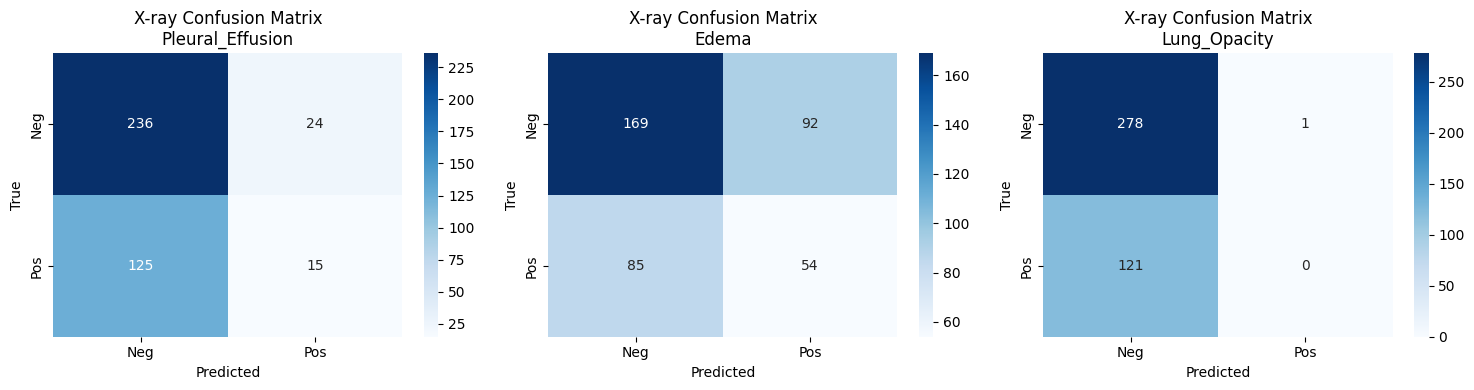

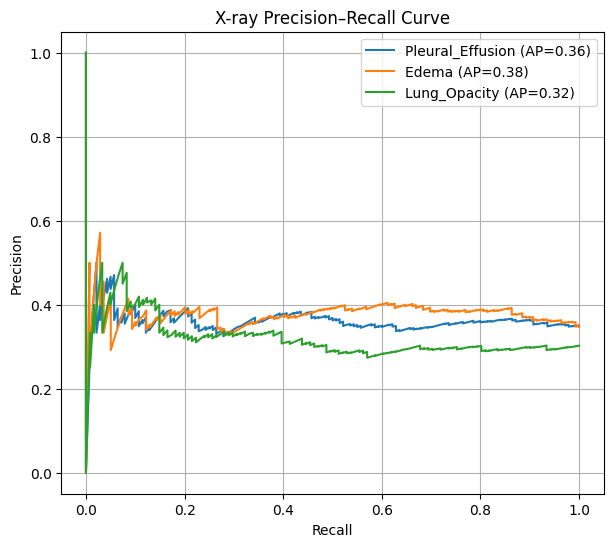

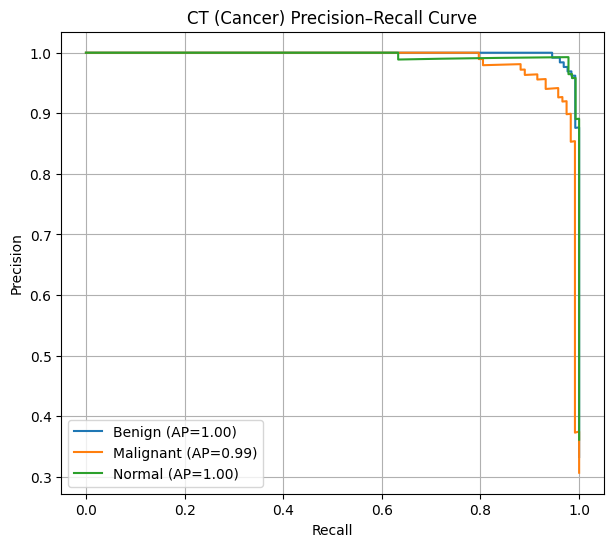


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.991803  0.945312  0.968000    128.0
Malignant      0.990476  0.881356  0.932735    118.0
Normal         0.879747  1.000000  0.936027    139.0
accuracy       0.945455  0.945455  0.945455    385.0
macro avg      0.954009  0.942223  0.945587    385.0
weighted avg   0.950940  0.945455  0.945648    385.0

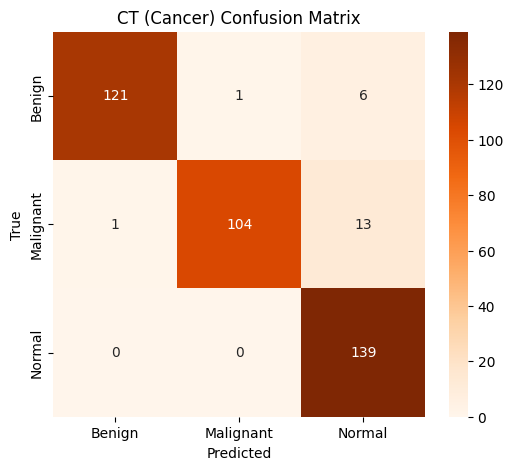

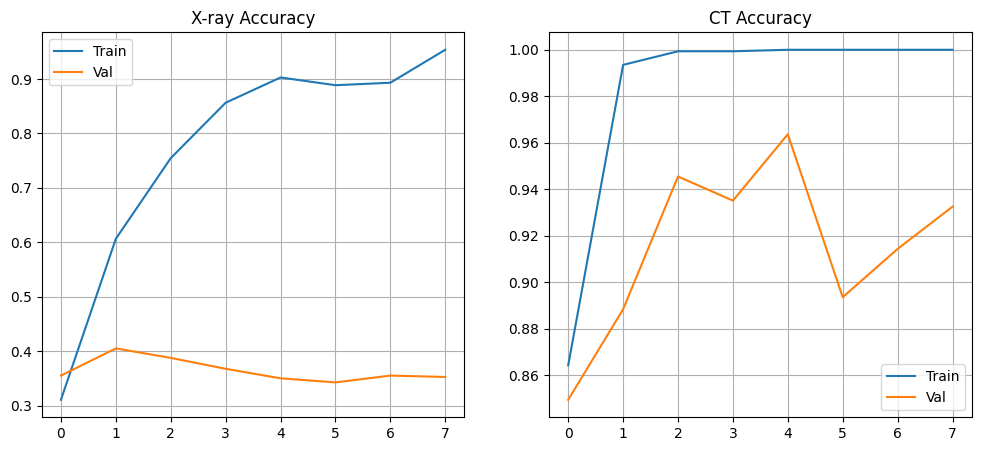

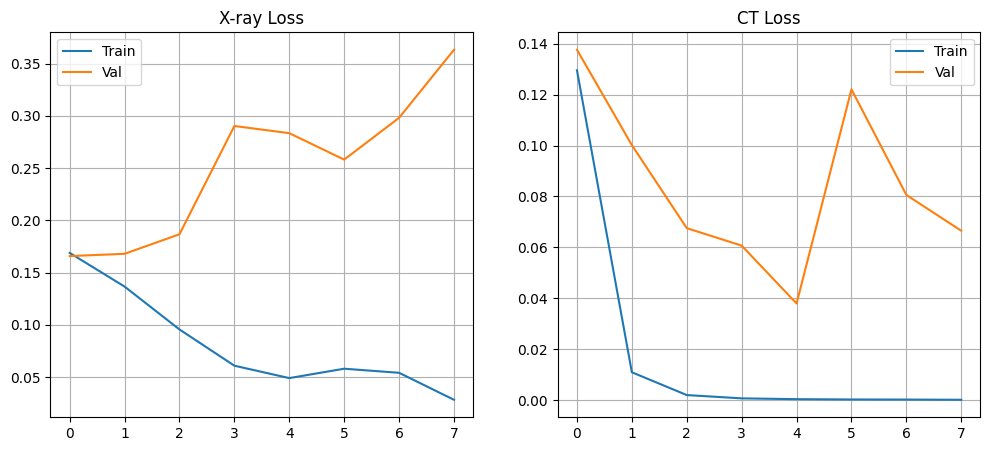

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**vgg16**

In [ ]:
backbone_name = "vgg16"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


In [ ]:
model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)

Model: "Phase1_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 512)       │ 14,714,688 │ xray_input[0][0], │
│                     │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 512)       │    262,656 │ vgg16[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 512)       │    262,656 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,243,078 (58.15 MB)

 Trainable params: 15,243,078 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - ct_out_accuracy: 0.5075 - ct_out_loss: 0.4327 - loss: 0.5979 - xray_out_accuracy: 0.3229 - xray_out_loss: 0.1652
📌 Epoch 1: X-ray Acc=0.322, CT Acc=0.643, Val X-ray Acc=0.340, Val CT Acc=0.683
97/97 ━━━━━━━━━━━━━━━━━━━━ 70s 628ms/step - ct_out_accuracy: 0.5089 - ct_out_loss: 0.4316 - loss: 0.5969 - xray_out_accuracy: 0.3229 - xray_out_loss: 0.1652 - val_ct_out_accuracy: 0.6831 - val_ct_out_loss: 0.2708 - val_loss: 0.4427 - val_xray_out_accuracy: 0.3400 - val_xray_out_loss: 0.1632 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - ct_out_accuracy: 0.7866 - ct_out_loss: 0.1965 - loss: 0.3596 - xray_out_accuracy: 0.3335 - xray_out_loss: 0.1631
📌 Epoch 2: X-ray Acc=0.341, CT Acc=0.834, Val X-ray Acc=0.357, Val CT Acc=0.826
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 552ms/step - ct_out_accuracy: 0.7871 - ct_out_loss: 0.1959 - loss: 0.3590 - xray_out_accuracy: 0.3336 - xray_out_loss: 0.1631 - val_ct_out_accuracy: 0.8260

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:04<00:00,  5.56it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.368421  0.050000  0.088050    140.0
Edema              0.625000  0.143885  0.233918    139.0
Lung_Opacity       0.354839  0.181818  0.240437    121.0
micro avg          0.433628  0.122500  0.191033    400.0
macro avg          0.449420  0.125234  0.187469    400.0
weighted avg       0.453474  0.122500  0.184836    400.0
samples avg        0.121250  0.122500  0.121667    400.0
accuracy           0.654167  0.654167  0.654167    400.0

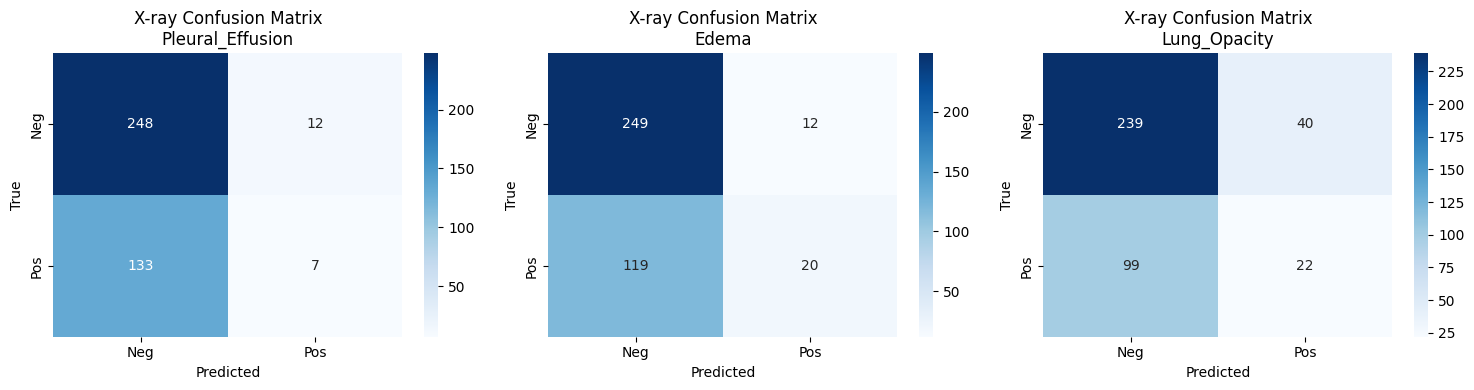

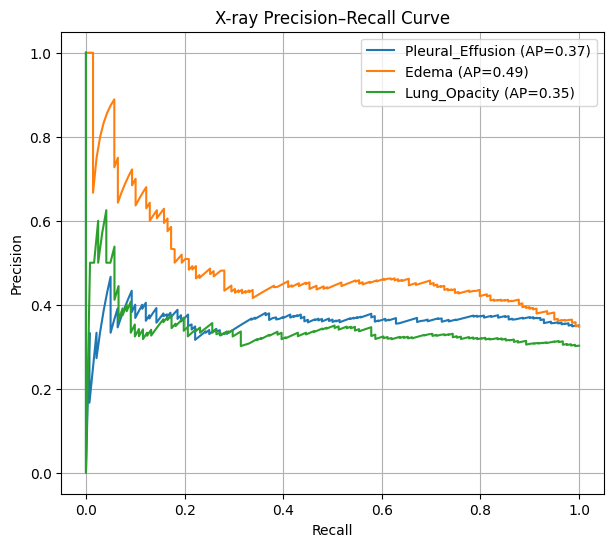

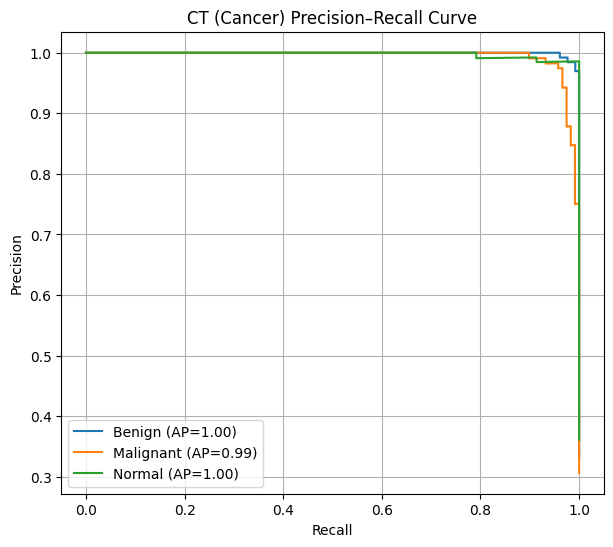


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.984252  0.976562  0.980392    128.0
Malignant      0.950000  0.966102  0.957983    118.0
Normal         0.985507  0.978417  0.981949    139.0
accuracy       0.974026  0.974026  0.974026    385.0
macro avg      0.973253  0.973694  0.973442    385.0
weighted avg   0.974207  0.974026  0.974086    385.0

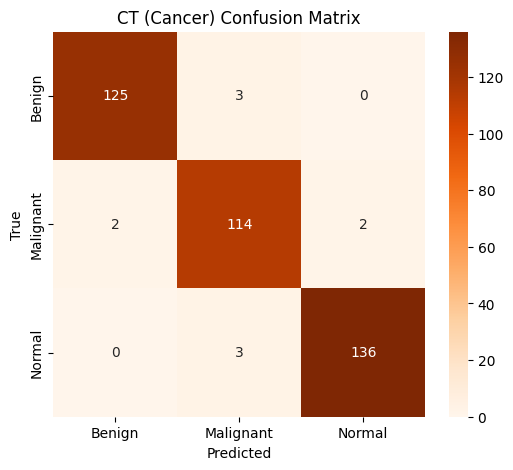

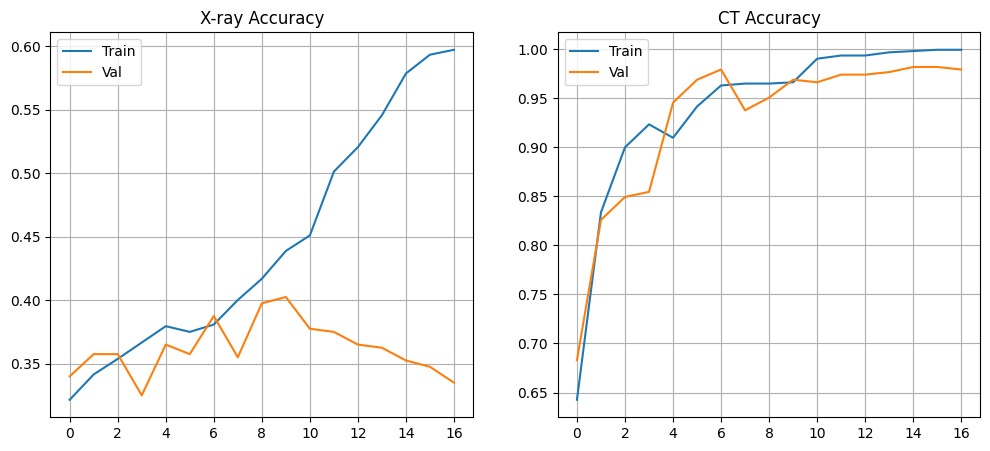

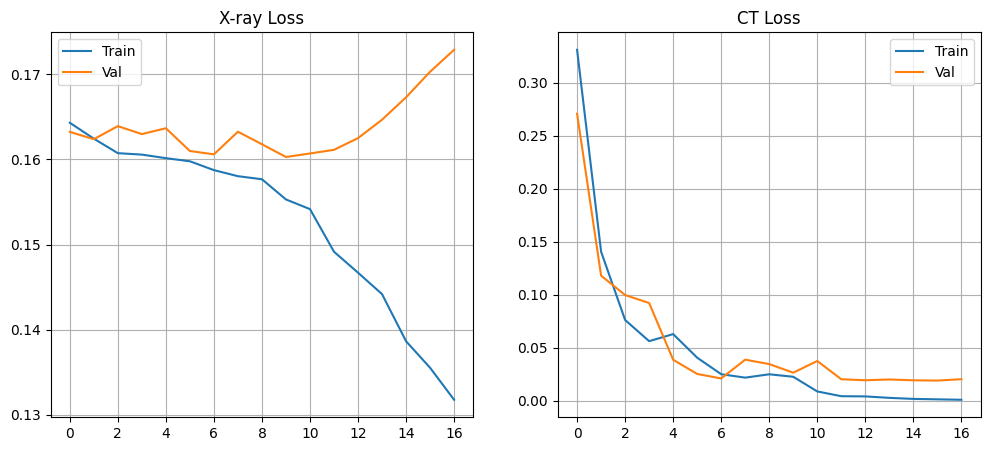

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Expentiment with resnet50**

In [ ]:
backbone_name = "resnet50"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_RESNET50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │  1,049,088 │ resnet50[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 512)       │  1,049,088 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,688,966 (98.00 MB)

 Trainable params: 25,635,846 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - ct_out_accuracy: 0.7718 - ct_out_loss: 0.2317 - loss: 0.4408 - xray_out_accuracy: 0.3089 - xray_out_loss: 0.2091
📌 Epoch 1: X-ray Acc=0.292, CT Acc=0.867, Val X-ray Acc=0.347, Val CT Acc=0.361
97/97 ━━━━━━━━━━━━━━━━━━━━ 152s 781ms/step - ct_out_accuracy: 0.7728 - ct_out_loss: 0.2307 - loss: 0.4397 - xray_out_accuracy: 0.3087 - xray_out_loss: 0.2090 - val_ct_out_accuracy: 0.3610 - val_ct_out_loss: 3.7308 - val_loss: 4.5228 - val_xray_out_accuracy: 0.3475 - val_xray_out_loss: 0.9342 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - ct_out_accuracy: 0.9755 - ct_out_loss: 0.0202 - loss: 0.1741 - xray_out_accuracy: 0.4912 - xray_out_loss: 0.1539
📌 Epoch 2: X-ray Acc=0.483, CT Acc=0.979, Val X-ray Acc=0.347, Val CT Acc=0.361
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 318ms/step - ct_out_accuracy: 0.9755 - ct_out_loss: 0.0202 - loss: 0.1741 - xray_out_accuracy: 0.4911 - xray_out_loss: 0.1539 - val_ct_out_accuracy: 0.361

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:11<00:00,  2.18it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.263158  0.035714  0.062893    140.0
Edema              0.319444  0.165468  0.218009    139.0
Lung_Opacity       0.226891  0.223140  0.225000    121.0
micro avg          0.261905  0.137500  0.180328    400.0
macro avg          0.269831  0.141441  0.168634    400.0
weighted avg       0.271747  0.137500  0.165833    400.0
samples avg        0.131250  0.137500  0.133333    400.0
accuracy           0.583333  0.583333  0.583333    400.0

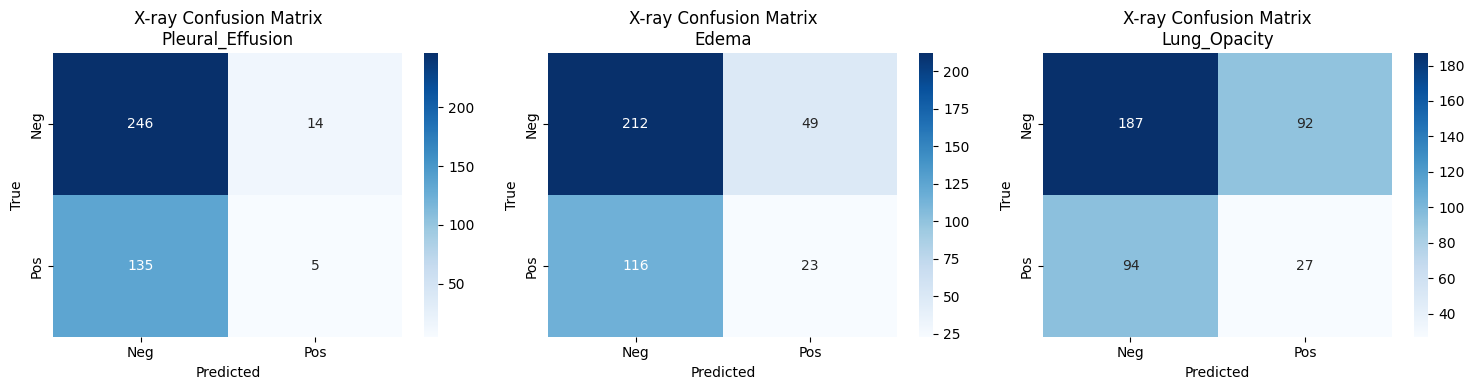

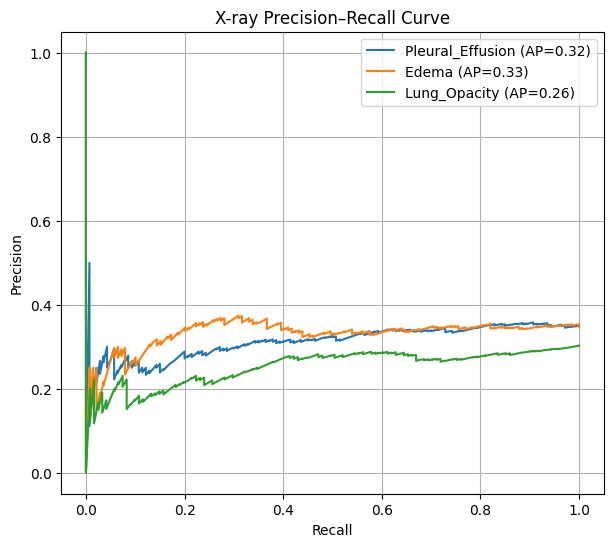

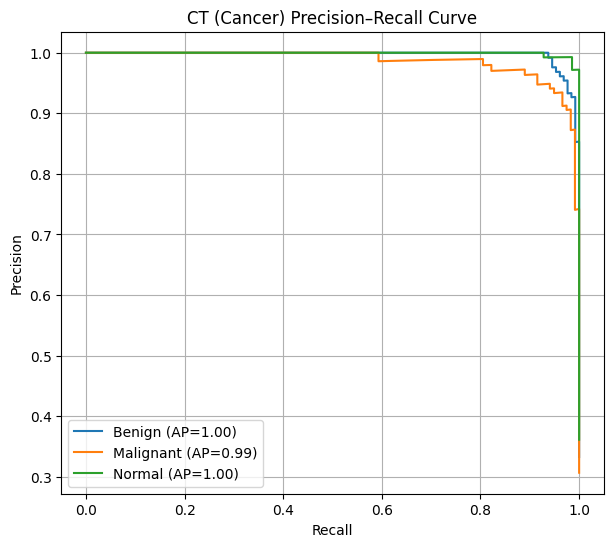


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.968254  0.953125  0.960630    128.0
Malignant      0.933884  0.957627  0.945607    118.0
Normal         0.992754  0.985612  0.989170    139.0
accuracy       0.966234  0.966234  0.966234    385.0
macro avg      0.964964  0.965455  0.965135    385.0
weighted avg   0.966565  0.966234  0.966329    385.0

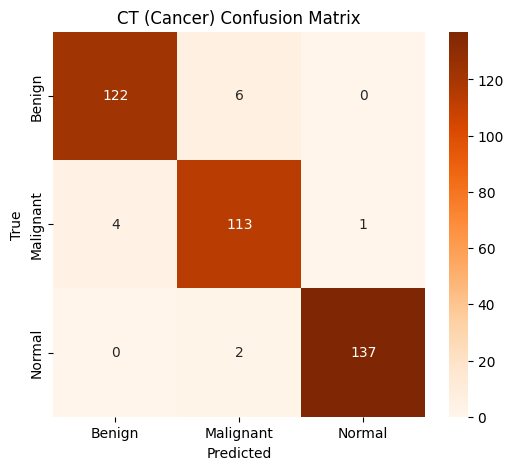

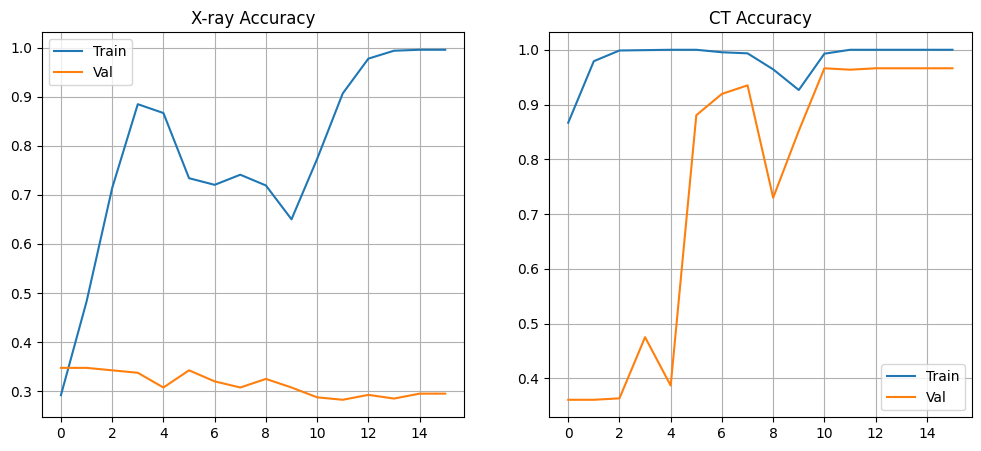

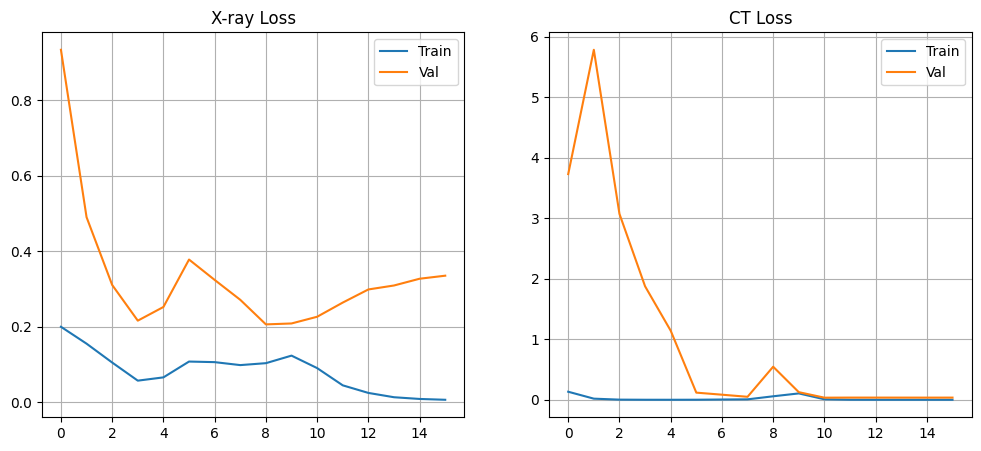

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with resnet50v2**

In [ ]:
backbone_name = "resnet50v2"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "Phase1_RESNET50V2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 2048)      │ 23,564,800 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 512)       │  1,049,088 │ resnet50v2[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 512)       │  1,049,088 │ resnet50v2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,666,054 (97.91 MB)

 Trainable params: 25,620,614 (97.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - ct_out_accuracy: 0.9930 - ct_out_loss: 0.0056 - loss: 0.1063 - xray_out_accuracy: 0.7527 - xray_out_loss: 0.1007
📌 Epoch 1: X-ray Acc=0.840, CT Acc=0.995, Val X-ray Acc=0.377, Val CT Acc=0.906
97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 277ms/step - ct_out_accuracy: 0.9931 - ct_out_loss: 0.0056 - loss: 0.1061 - xray_out_accuracy: 0.7536 - xray_out_loss: 0.1005 - val_ct_out_accuracy: 0.9065 - val_ct_out_loss: 0.1068 - val_loss: 0.2967 - val_xray_out_accuracy: 0.3775 - val_xray_out_loss: 0.1860 - learning_rate: 2.5000e-05
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - ct_out_accuracy: 1.0000 - ct_out_loss: 3.8618e-04 - loss: 0.0492 - xray_out_accuracy: 0.9729 - xray_out_loss: 0.0488
📌 Epoch 2: X-ray Acc=0.987, CT Acc=1.000, Val X-ray Acc=0.355, Val CT Acc=0.945
97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 280ms/step - ct_out_accuracy: 1.0000 - ct_out_loss: 3.8793e-04 - loss: 0.0491 - xray_out_accuracy: 0.9730 - xray_out_loss: 0.0487 - val_ct_out_accuracy

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.317460  0.142857  0.197044    140.0
Edema              0.391635  0.741007  0.512438    139.0
Lung_Opacity       0.000000  0.000000  0.000000    121.0
micro avg          0.376147  0.307500  0.338377    400.0
macro avg          0.236365  0.294621  0.236494    400.0
weighted avg       0.247204  0.307500  0.247038    400.0
samples avg        0.288750  0.307500  0.295000    400.0
accuracy           0.599167  0.599167  0.599167    400.0

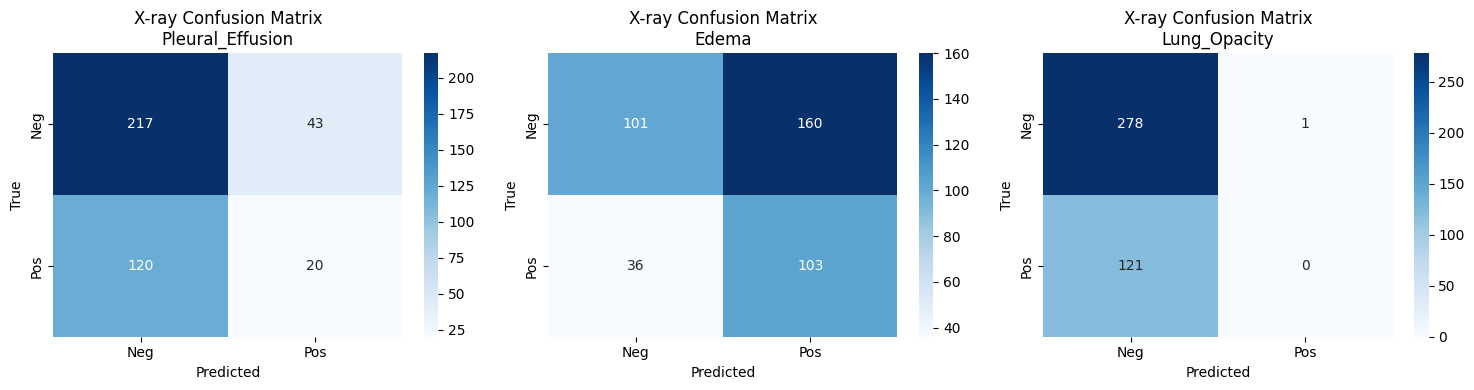

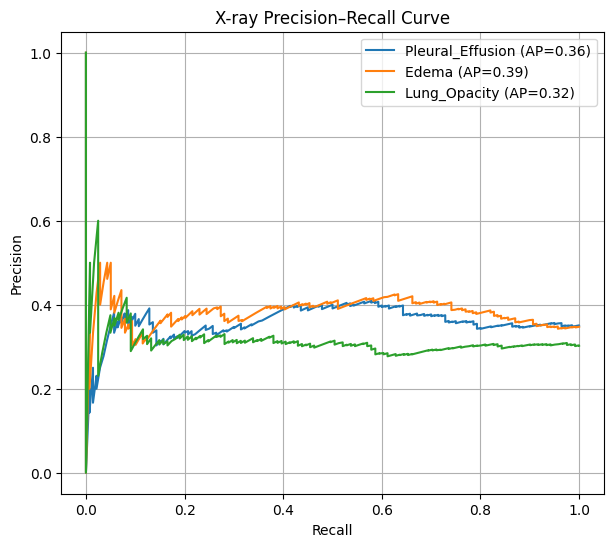

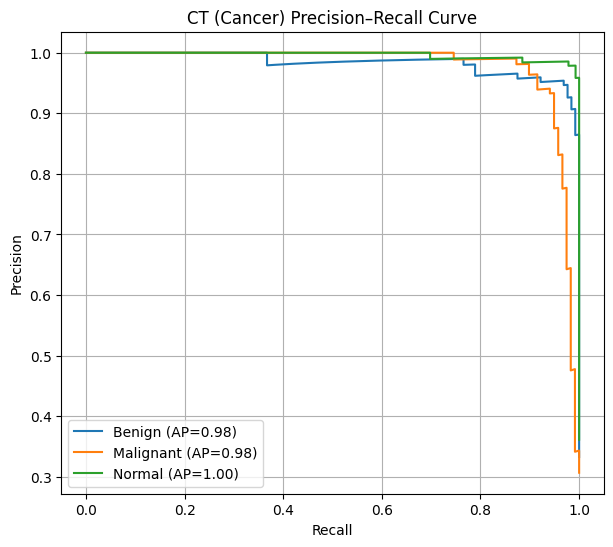


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.913043  0.984375  0.947368    128.0
Malignant      0.980198  0.838983  0.904110    118.0
Normal         0.952055  1.000000  0.975439    139.0
accuracy       0.945455  0.945455  0.945455    385.0
macro avg      0.948432  0.941119  0.942306    385.0
weighted avg   0.947711  0.945455  0.944244    385.0

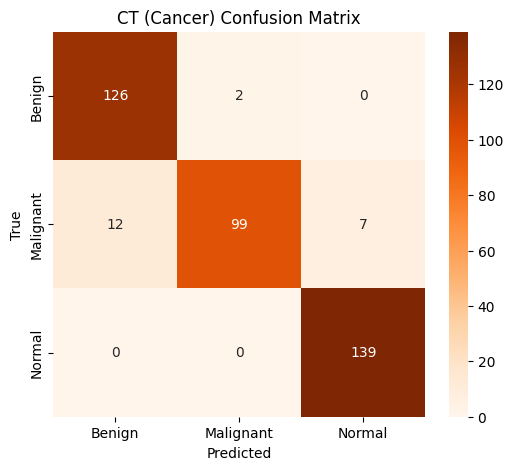

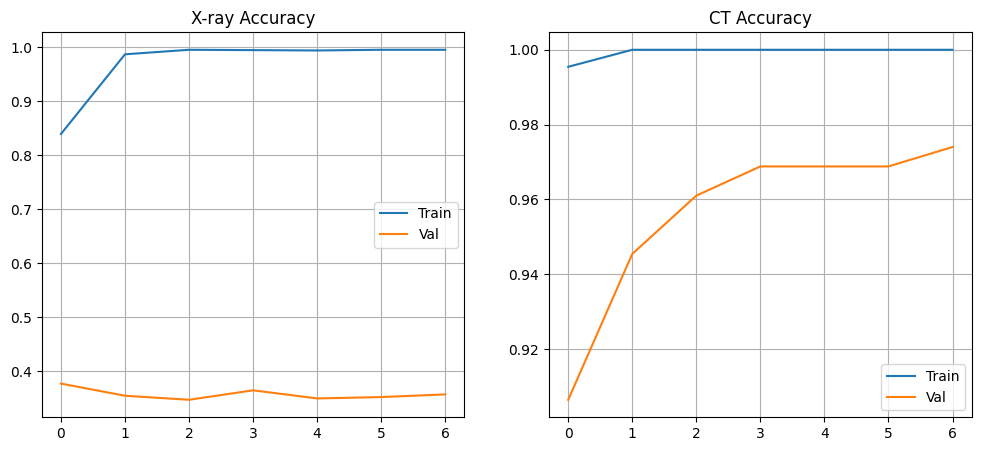

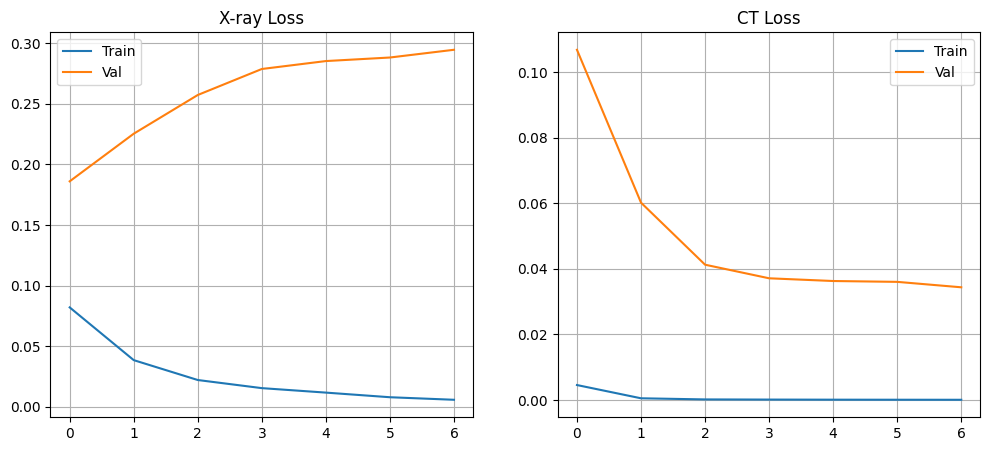

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with resnet101**

In [ ]:
backbone_name = "resnet101"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "Phase1_RESNET101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet101           │ (None, 2048)      │ 42,658,176 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 512)       │  1,049,088 │ resnet101[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │  1,049,088 │ resnet101[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,759,430 (170.74 MB)

 Trainable params: 44,654,086 (170.34 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - ct_out_accuracy: 0.7554 - ct_out_loss: 0.2465 - loss: 0.4466 - xray_out_accuracy: 0.3224 - xray_out_loss: 0.2001   
📌 Epoch 1: X-ray Acc=0.326, CT Acc=0.872, Val X-ray Acc=0.303, Val CT Acc=0.306
97/97 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - ct_out_accuracy: 0.7565 - ct_out_loss: 0.2454 - loss: 0.4454 - xray_out_accuracy: 0.3224 - xray_out_loss: 0.2001 - val_ct_out_accuracy: 0.3065 - val_ct_out_loss: 11.3633 - val_loss: 12.8735 - val_xray_out_accuracy: 0.3025 - val_xray_out_loss: 1.6988 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - ct_out_accuracy: 0.9719 - ct_out_loss: 0.0262 - loss: 0.1755 - xray_out_accuracy: 0.5198 - xray_out_loss: 0.1493
📌 Epoch 2: X-ray Acc=0.573, CT Acc=0.979, Val X-ray Acc=0.268, Val CT Acc=0.332
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 570ms/step - ct_out_accuracy: 0.9720 - ct_out_loss: 0.0262 - loss: 0.1754 - xray_out_accuracy: 0.5203 - xray_out_loss: 0.1492 - val_ct_out_accuracy: 0.3325

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.255814  0.078571  0.120219    140.0
Edema              0.361809  0.517986  0.426036    139.0
Lung_Opacity       0.333333  0.008264  0.016129    121.0
micro avg          0.342857  0.210000  0.260465    400.0
macro avg          0.316985  0.201607  0.187461    400.0
weighted avg       0.316097  0.210000  0.195003    400.0
samples avg        0.208750  0.210000  0.209167    400.0
accuracy           0.602500  0.602500  0.602500    400.0

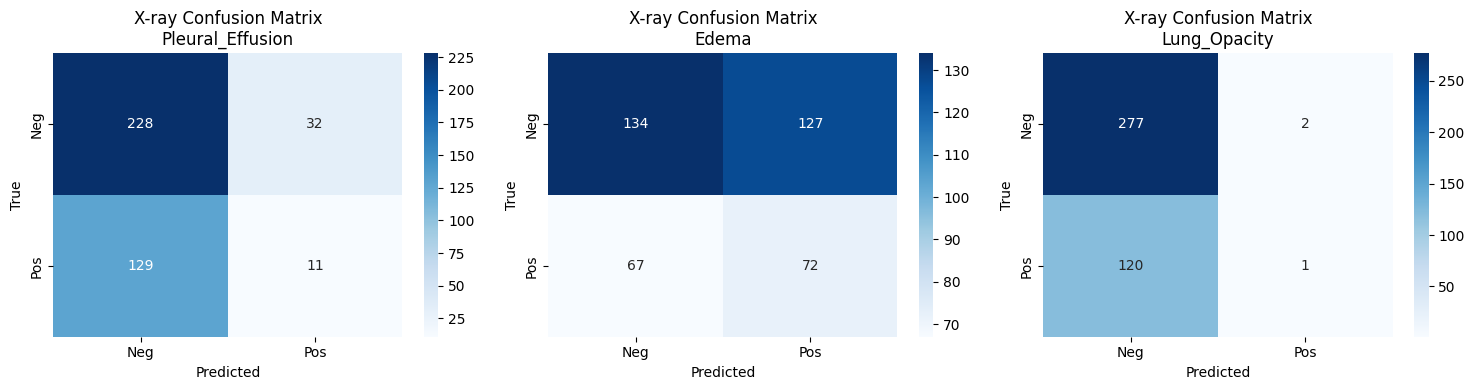

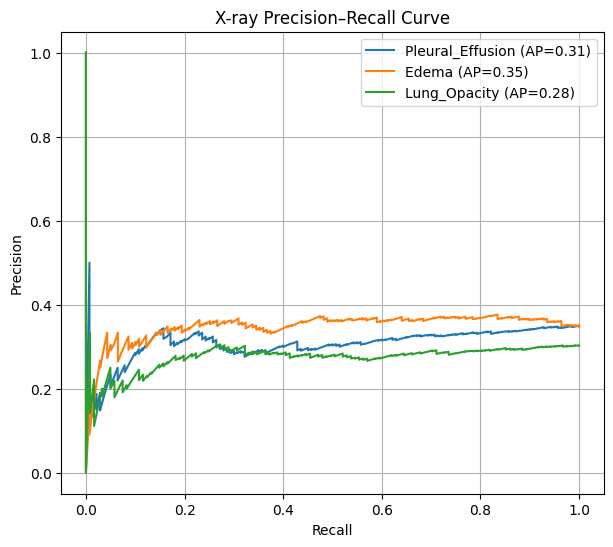

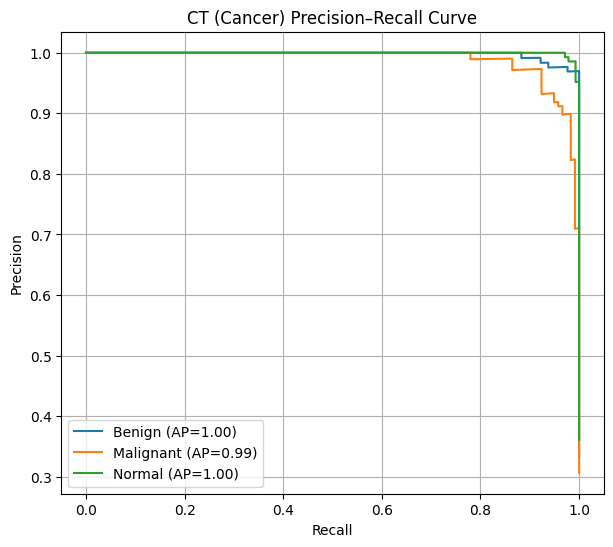


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         1.000000  0.843750  0.915254    128.0
Malignant      0.859259  0.983051  0.916996    118.0
Normal         0.971831  0.992806  0.982206    139.0
accuracy       0.940260  0.940260  0.940260    385.0
macro avg      0.943697  0.939869  0.938152    385.0
weighted avg   0.946694  0.940260  0.939960    385.0

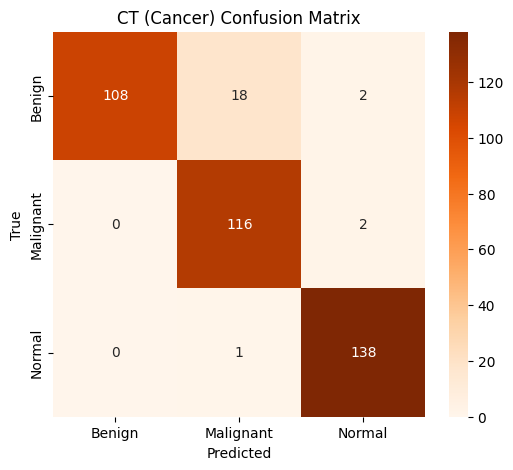

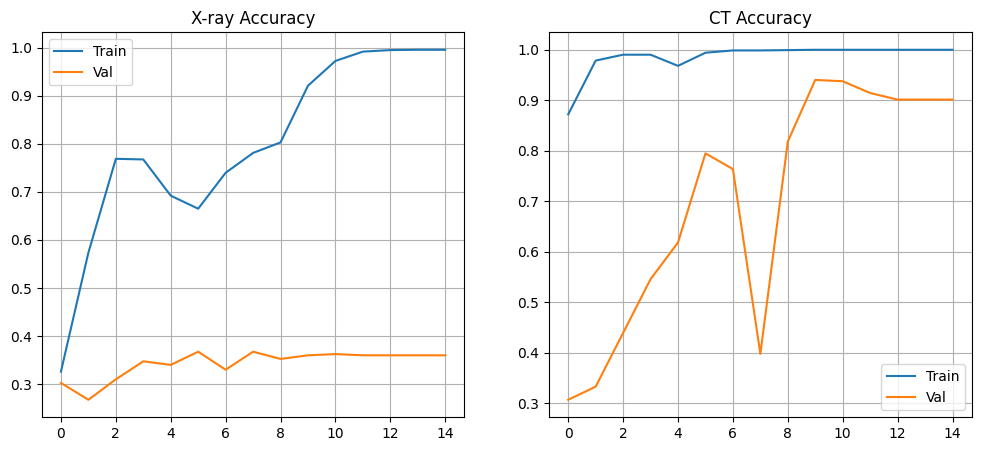

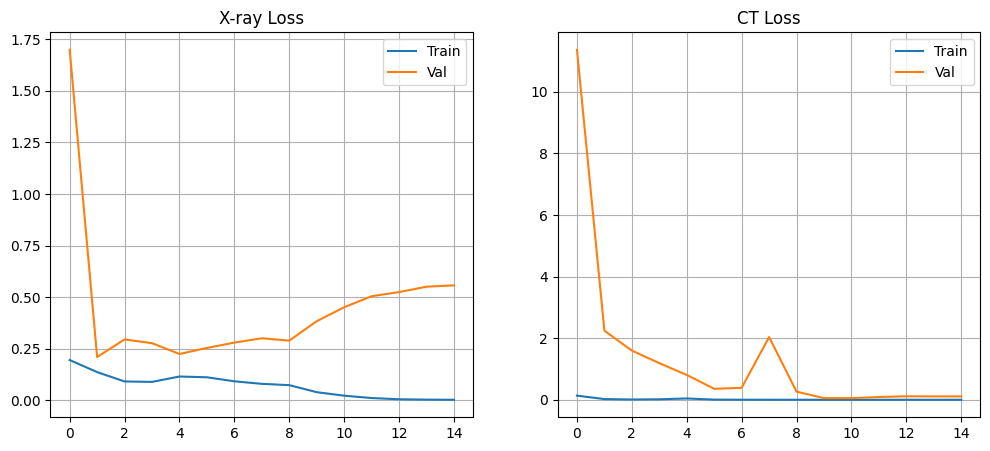

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with resnet101v2**

In [ ]:
backbone_name = "resnet101v2"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "Phase1_RESNET101V2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet101v2         │ (None, 2048)      │ 42,626,560 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 512)       │  1,049,088 │ resnet101v2[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 512)       │  1,049,088 │ resnet101v2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_22[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,727,814 (170.62 MB)

 Trainable params: 44,630,150 (170.25 MB)

 Non-trainable params: 97,664 (381.50 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - ct_out_accuracy: 0.9979 - ct_out_loss: 0.0019 - loss: 0.0826 - xray_out_accuracy: 0.8071 - xray_out_loss: 0.0807
📌 Epoch 1: X-ray Acc=0.842, CT Acc=0.999, Val X-ray Acc=0.345, Val CT Acc=0.964
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 507ms/step - ct_out_accuracy: 0.9979 - ct_out_loss: 0.0019 - loss: 0.0825 - xray_out_accuracy: 0.8075 - xray_out_loss: 0.0806 - val_ct_out_accuracy: 0.9636 - val_ct_out_loss: 0.0379 - val_loss: 0.2746 - val_xray_out_accuracy: 0.3450 - val_xray_out_loss: 0.2369 - learning_rate: 2.5000e-05
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - ct_out_accuracy: 1.0000 - ct_out_loss: 2.2700e-04 - loss: 0.0422 - xray_out_accuracy: 0.9408 - xray_out_loss: 0.0420
📌 Epoch 2: X-ray Acc=0.974, CT Acc=1.000, Val X-ray Acc=0.357, Val CT Acc=0.971
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 498ms/step - ct_out_accuracy: 1.0000 - ct_out_loss: 2.2672e-04 - loss: 0.0421 - xray_out_accuracy: 0.9411 - xray_out_loss: 0.0419 - val_ct_out_accuracy

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.000000  0.000000  0.000000    140.0
Edema              0.350649  0.582734  0.437838    139.0
Lung_Opacity       0.354839  0.181818  0.240437    121.0
micro avg          0.351536  0.257500  0.297258    400.0
macro avg          0.235163  0.254851  0.226092    400.0
weighted avg       0.229189  0.257500  0.224881    400.0
samples avg        0.236250  0.257500  0.243333    400.0
accuracy           0.594167  0.594167  0.594167    400.0

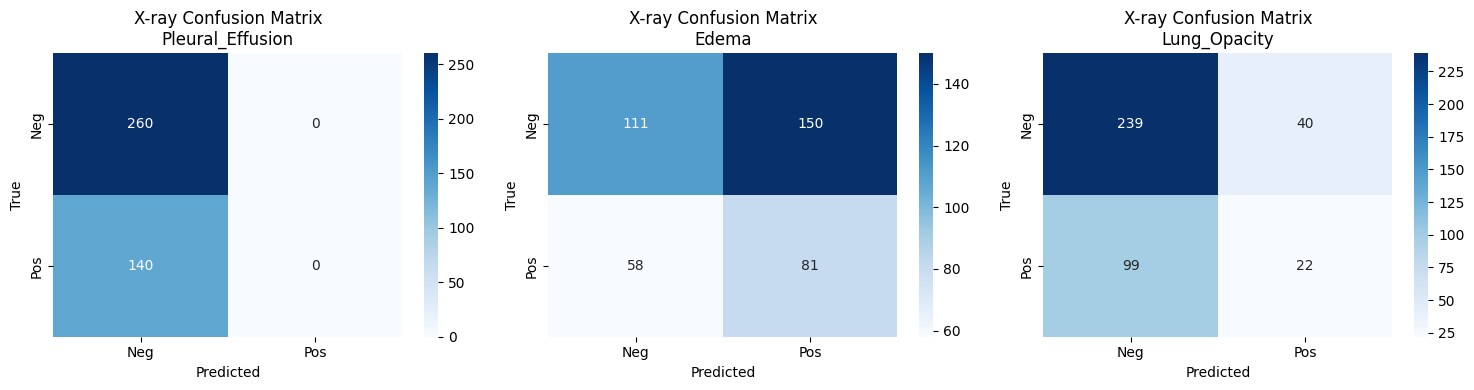

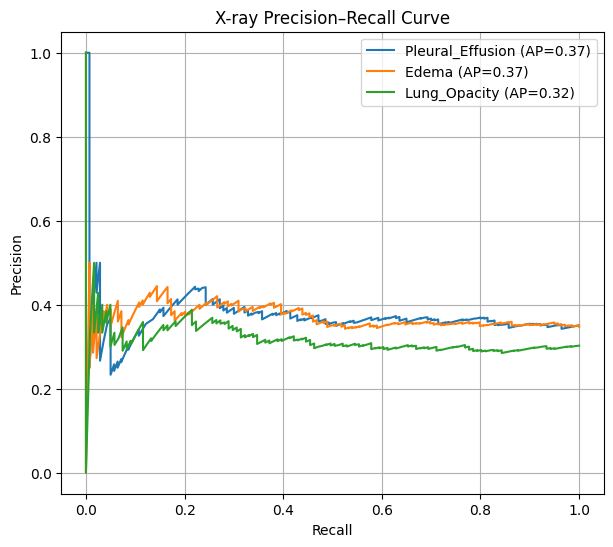

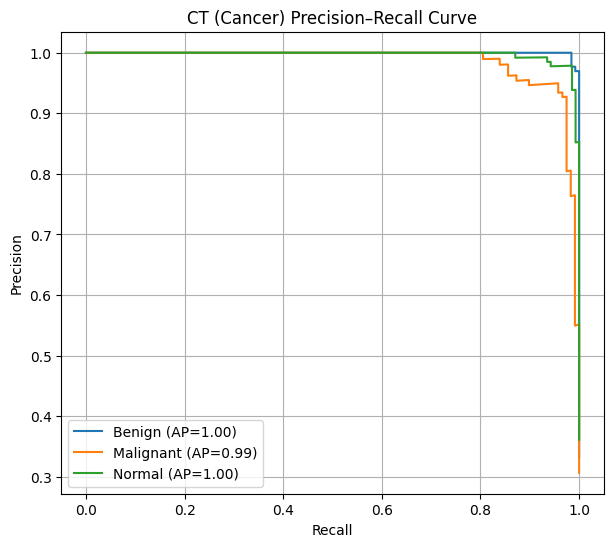


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         1.000000  0.953125  0.976000    128.0
Malignant      0.949153  0.949153  0.949153    118.0
Normal         0.944828  0.985612  0.964789    139.0
accuracy       0.963636  0.963636  0.963636    385.0
macro avg      0.964660  0.962630  0.963314    385.0
weighted avg   0.964496  0.963636  0.963724    385.0

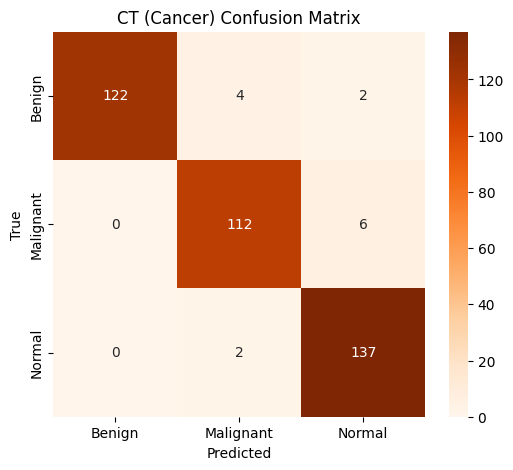

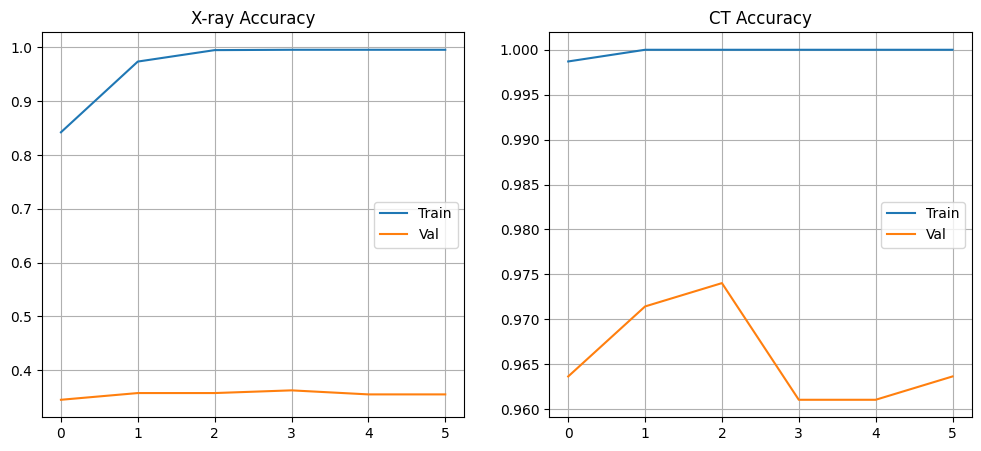

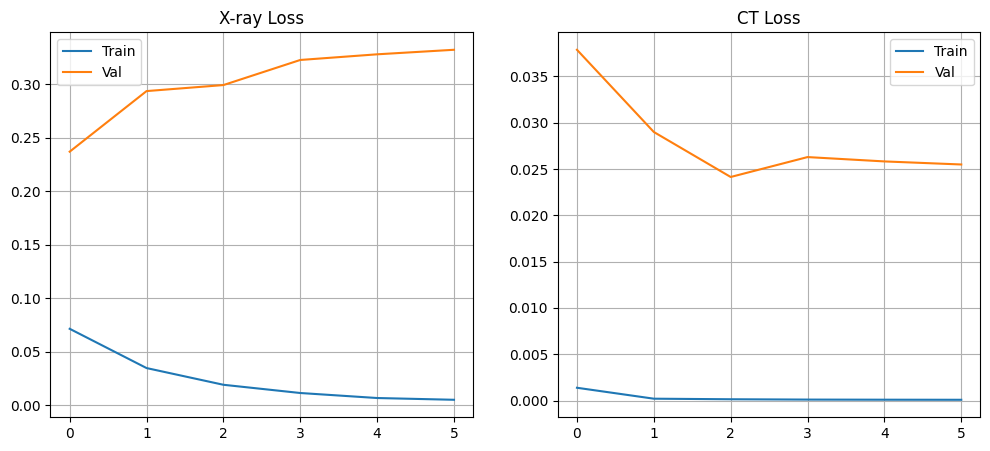

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experimenting with resnet152**

In [ ]:
backbone_name = "resnet152"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "Phase1_RESNET152"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152           │ (None, 2048)      │ 58,370,944 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 512)       │  1,049,088 │ resnet152[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 512)       │  1,049,088 │ resnet152[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_24[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,472,198 (230.68 MB)

 Trainable params: 60,320,774 (230.11 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - ct_out_accuracy: 0.7657 - ct_out_loss: 0.2552 - loss: 0.4594 - xray_out_accuracy: 0.3408 - xray_out_loss: 0.2042   
📌 Epoch 1: X-ray Acc=0.322, CT Acc=0.859, Val X-ray Acc=0.303, Val CT Acc=0.332
97/97 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - ct_out_accuracy: 0.7667 - ct_out_loss: 0.2542 - loss: 0.4582 - xray_out_accuracy: 0.3407 - xray_out_loss: 0.2041 - val_ct_out_accuracy: 0.3325 - val_ct_out_loss: 6.9924 - val_loss: 8.9382 - val_xray_out_accuracy: 0.3025 - val_xray_out_loss: 1.6788 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - ct_out_accuracy: 0.9643 - ct_out_loss: 0.0343 - loss: 0.1850 - xray_out_accuracy: 0.5113 - xray_out_loss: 0.1507
📌 Epoch 2: X-ray Acc=0.506, CT Acc=0.971, Val X-ray Acc=0.347, Val CT Acc=0.338
97/97 ━━━━━━━━━━━━━━━━━━━━ 79s 817ms/step - ct_out_accuracy: 0.9644 - ct_out_loss: 0.0343 - loss: 0.1850 - xray_out_accuracy: 0.5112 - xray_out_loss: 0.1507 - val_ct_out_accuracy: 0.3377 -

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.250000  0.028571  0.051282    140.0
Edema              0.350829  0.913669  0.506986    139.0
Lung_Opacity       0.250000  0.008264  0.016000    121.0
micro avg          0.345550  0.330000  0.337596    400.0
macro avg          0.283610  0.316835  0.191423    400.0
weighted avg       0.285038  0.330000  0.198966    400.0
samples avg        0.325000  0.330000  0.326667    400.0
accuracy           0.568333  0.568333  0.568333    400.0

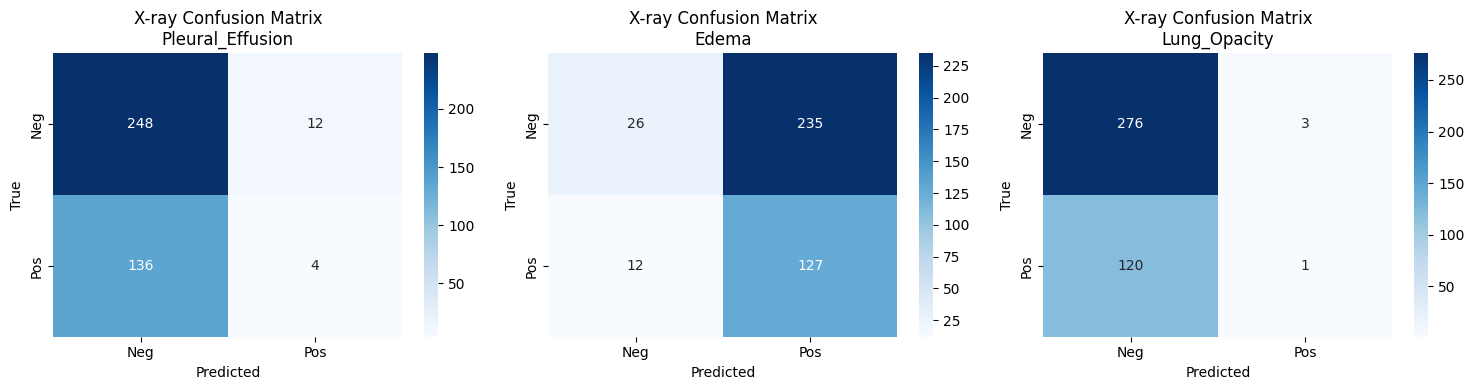

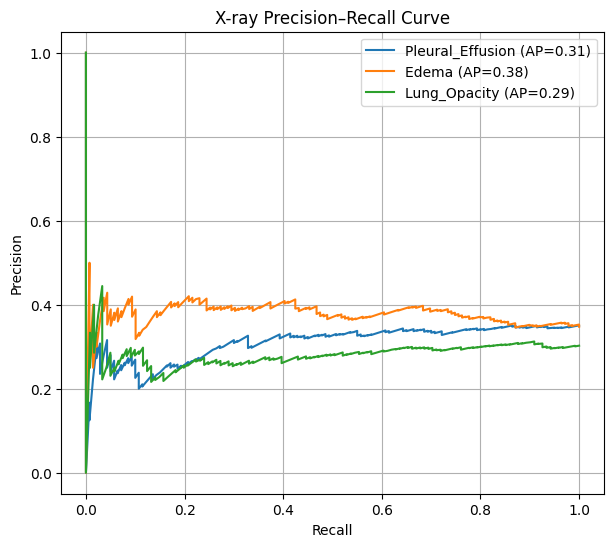

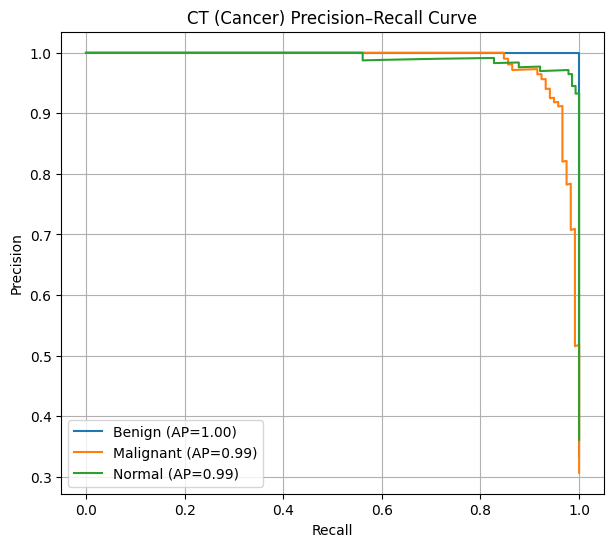


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         1.000000  0.796875  0.886957    128.0
Malignant      0.698795  0.983051  0.816901    118.0
Normal         0.982906  0.827338  0.898438    139.0
accuracy       0.864935  0.864935  0.864935    385.0
macro avg      0.893900  0.869088  0.867432    385.0
weighted avg   0.901511  0.864935  0.869630    385.0

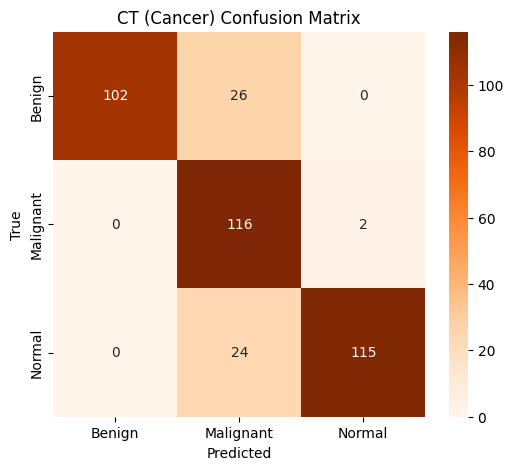

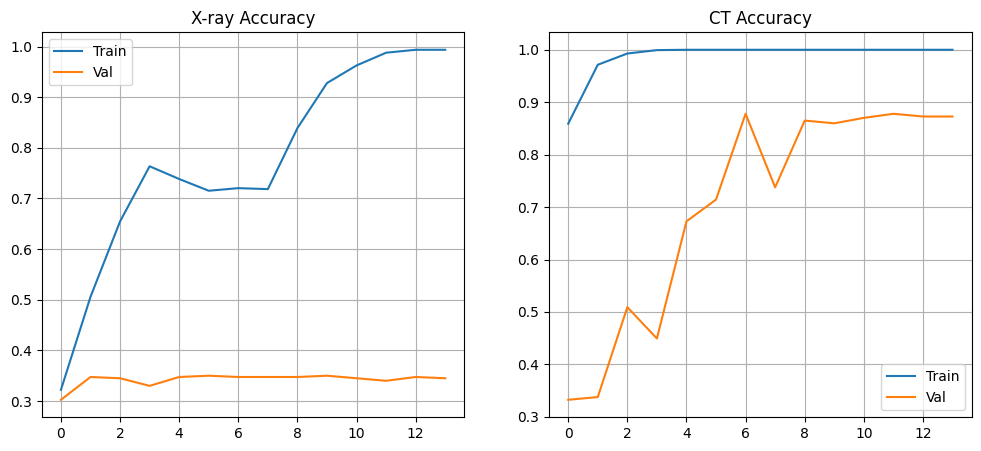

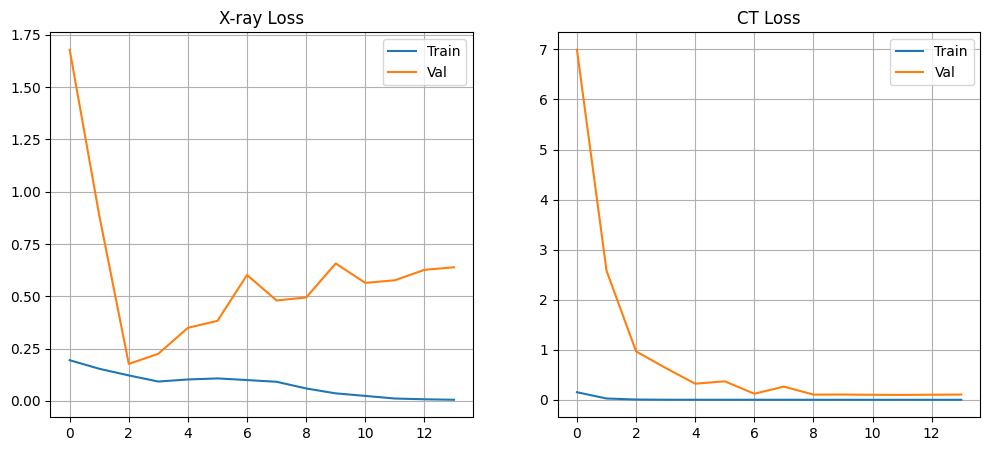

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experimenting with ResNet152v2**

In [ ]:
backbone_name = "resnet152v2"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "Phase1_RESNET152V2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152v2         │ (None, 2048)      │ 58,331,648 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 512)       │  1,049,088 │ resnet152v2[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 512)       │  1,049,088 │ resnet152v2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_26[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,432,902 (230.53 MB)

 Trainable params: 60,289,158 (229.98 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - ct_out_accuracy: 0.7239 - ct_out_loss: 0.2629 - loss: 0.4472 - xray_out_accuracy: 0.3163 - xray_out_loss: 0.1843   
📌 Epoch 1: X-ray Acc=0.304, CT Acc=0.825, Val X-ray Acc=0.320, Val CT Acc=0.782
97/97 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - ct_out_accuracy: 0.7249 - ct_out_loss: 0.2619 - loss: 0.4462 - xray_out_accuracy: 0.3162 - xray_out_loss: 0.1843 - val_ct_out_accuracy: 0.7818 - val_ct_out_loss: 0.2050 - val_loss: 0.4041 - val_xray_out_accuracy: 0.3200 - val_xray_out_loss: 0.1918 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - ct_out_accuracy: 0.9429 - ct_out_loss: 0.0492 - loss: 0.2062 - xray_out_accuracy: 0.4087 - xray_out_loss: 0.1570
📌 Epoch 2: X-ray Acc=0.438, CT Acc=0.961, Val X-ray Acc=0.338, Val CT Acc=0.901
97/97 ━━━━━━━━━━━━━━━━━━━━ 72s 744ms/step - ct_out_accuracy: 0.9431 - ct_out_loss: 0.0491 - loss: 0.2061 - xray_out_accuracy: 0.4090 - xray_out_loss: 0.1570 - val_ct_out_accuracy: 0.9013 -

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:29<00:00,  1.20s/it]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.200000  0.014286  0.026667    140.0
Edema              0.365269  0.438849  0.398693    139.0
Lung_Opacity       0.166667  0.033058  0.055172    121.0
micro avg          0.333333  0.167500  0.222962    400.0
macro avg          0.243979  0.162064  0.160177    400.0
weighted avg       0.247348  0.167500  0.164569    400.0
samples avg        0.166250  0.167500  0.166667    400.0
accuracy           0.610833  0.610833  0.610833    400.0

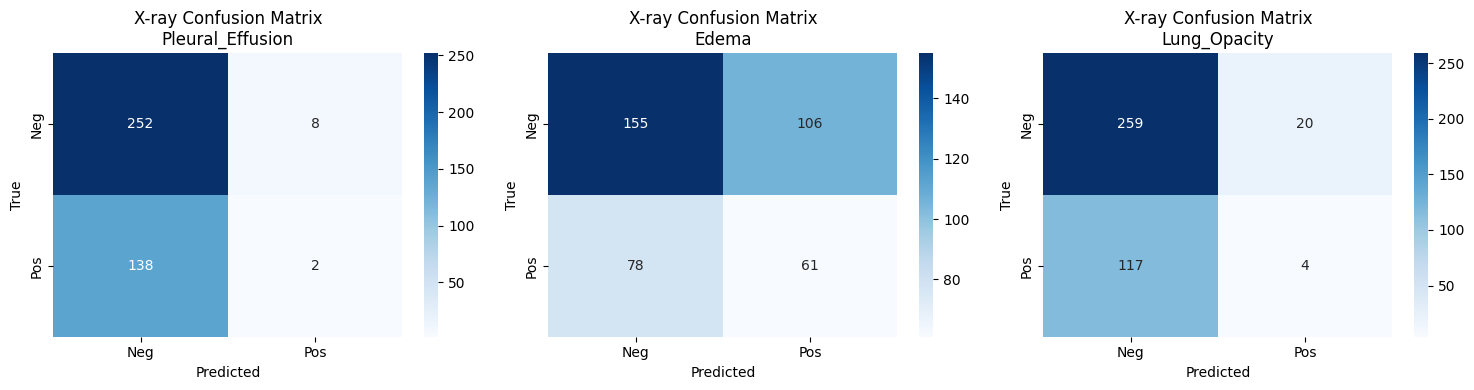

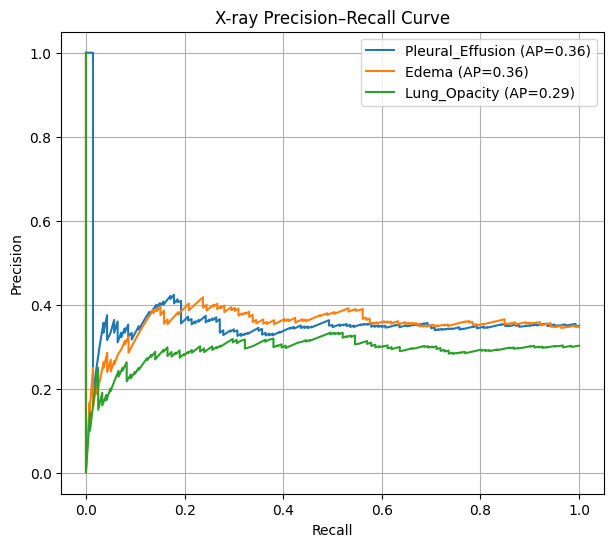

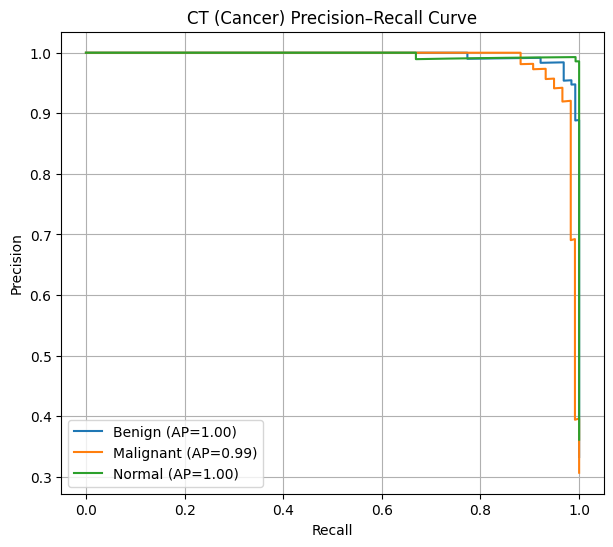


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.953846  0.968750  0.961240    128.0
Malignant      0.956522  0.932203  0.944206    118.0
Normal         0.985714  0.992806  0.989247    139.0
accuracy       0.966234  0.966234  0.966234    385.0
macro avg      0.965361  0.964586  0.964898    385.0
weighted avg   0.966172  0.966234  0.966131    385.0

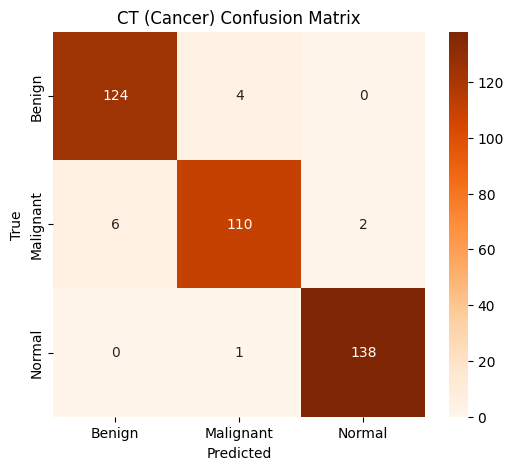

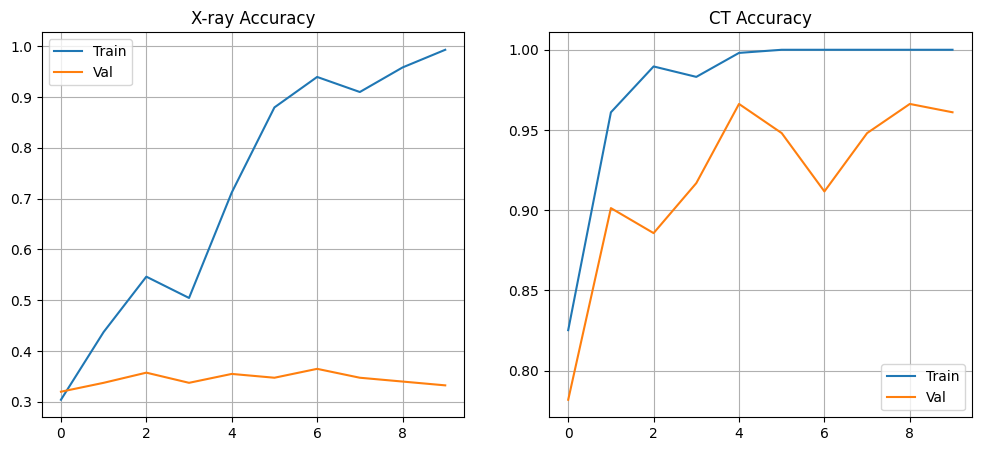

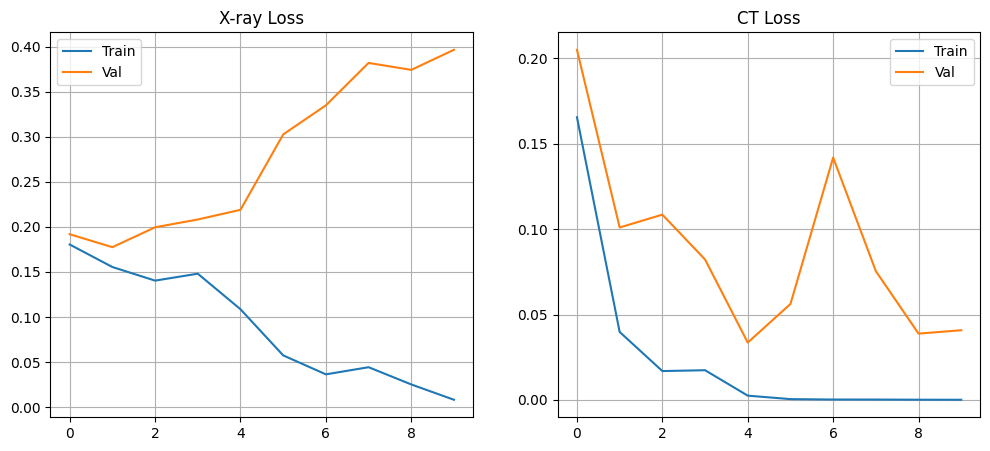

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experimenting with Inceptionv3**

In [ ]:
backbone_name = "inceptionv3"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_INCEPTIONV3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 2048)      │ 21,802,784 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 512)       │  1,049,088 │ inception_v3[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 512)       │  1,049,088 │ inception_v3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,904,038 (91.19 MB)

 Trainable params: 23,869,606 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - ct_out_accuracy: 0.7614 - ct_out_loss: 0.2215 - loss: 0.3998 - xray_out_accuracy: 0.3207 - xray_out_loss: 0.1783   
📌 Epoch 1: X-ray Acc=0.316, CT Acc=0.855, Val X-ray Acc=0.355, Val CT Acc=0.364
97/97 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - ct_out_accuracy: 0.7624 - ct_out_loss: 0.2207 - loss: 0.3989 - xray_out_accuracy: 0.3206 - xray_out_loss: 0.1783 - val_ct_out_accuracy: 0.3636 - val_ct_out_loss: 0.6357 - val_loss: 0.7944 - val_xray_out_accuracy: 0.3550 - val_xray_out_loss: 0.1730 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - ct_out_accuracy: 0.9695 - ct_out_loss: 0.0250 - loss: 0.1766 - xray_out_accuracy: 0.4812 - xray_out_loss: 0.1516
📌 Epoch 2: X-ray Acc=0.485, CT Acc=0.973, Val X-ray Acc=0.363, Val CT Acc=0.395
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - ct_out_accuracy: 0.9695 - ct_out_loss: 0.0251 - loss: 0.1766 - xray_out_accuracy: 0.4812 - xray_out_loss: 0.1516 - val_ct_out_accuracy: 0.3948 -

In [ ]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:16<00:00,  1.47it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.329032  0.364286  0.345763    140.0
Edema              0.401408  0.410072  0.405694    139.0
Lung_Opacity       0.500000  0.008264  0.016260    121.0
micro avg          0.364548  0.272500  0.311874    400.0
macro avg          0.410147  0.260874  0.255906    400.0
weighted avg       0.405901  0.272500  0.266914    400.0
samples avg        0.261250  0.272500  0.265000    400.0
accuracy           0.599167  0.599167  0.599167    400.0

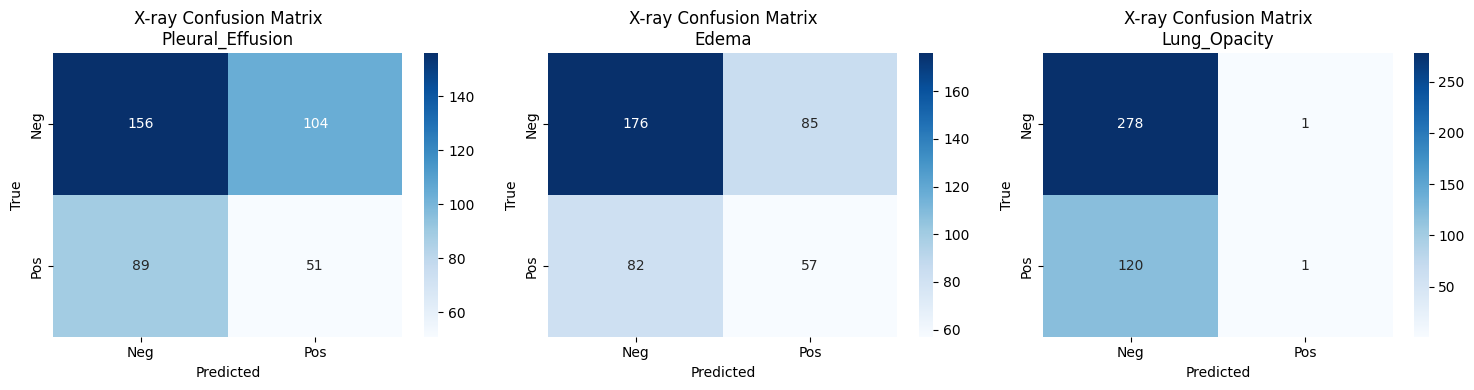

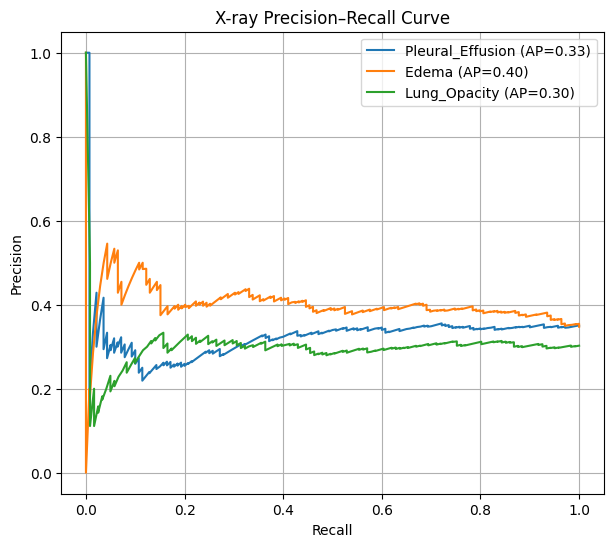

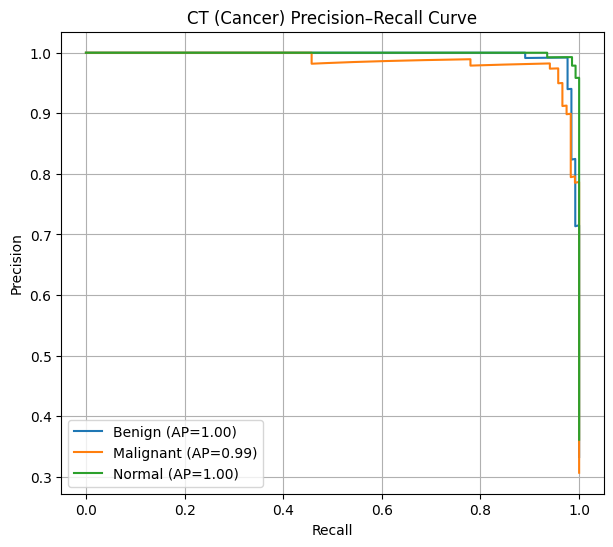


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.991453  0.906250  0.946939    128.0
Malignant      0.878788  0.983051  0.928000    118.0
Normal         0.992647  0.971223  0.981818    139.0
accuracy       0.953247  0.953247  0.953247    385.0
macro avg      0.954296  0.953508  0.952252    385.0
weighted avg   0.957353  0.953247  0.953727    385.0

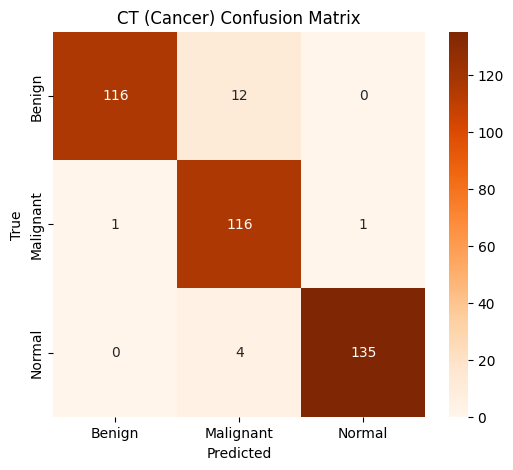

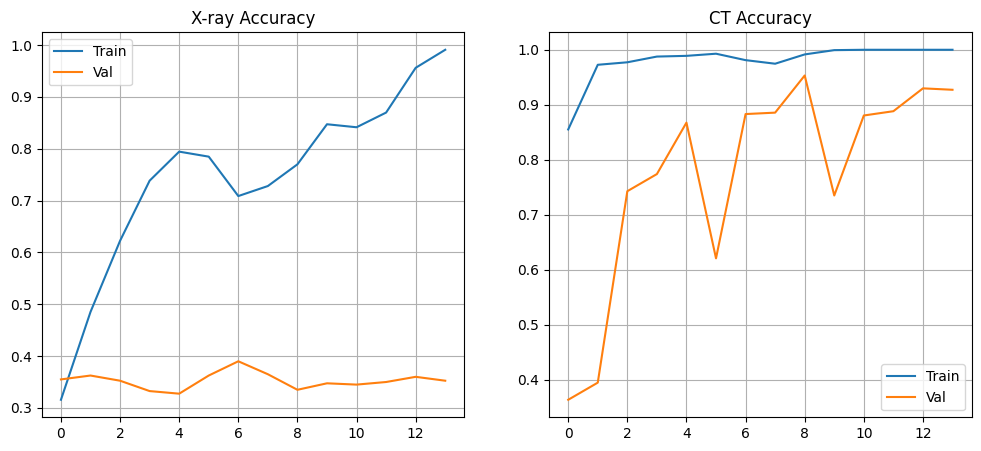

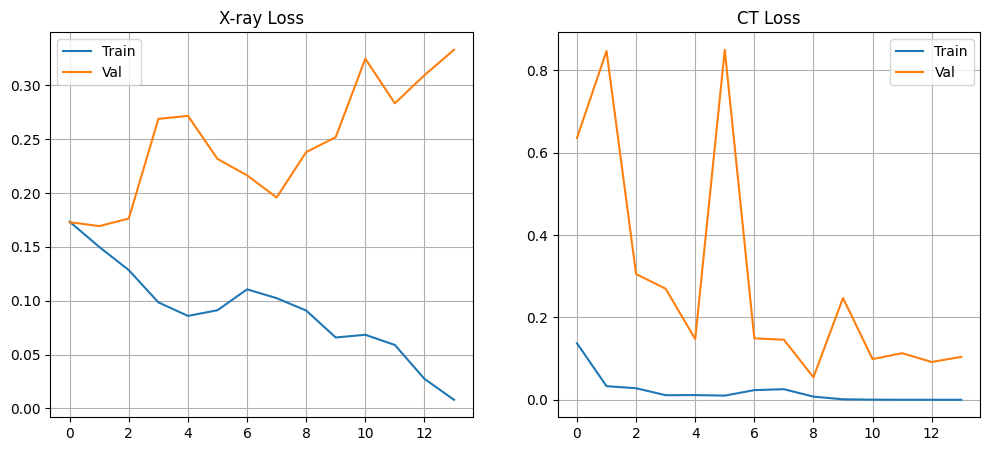

In [ ]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with inceptionresnetv2**

In [26]:
backbone_name = "inceptionresnetv2"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data


  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385
  Image Size : 299x299


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "Phase1_INCEPTIONRESNETV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_resnet_v2 │ (None, 1536)      │ 54,336,736 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    786,944 │ inception_resnet… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    786,944 │ inception_resnet… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,913,702 (213.29 MB)

 Trainable params: 55,853,158 (213.06 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [27]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - ct_out_accuracy: 0.7702 - ct_out_loss: 0.2166 - loss: 0.3889 - xray_out_accuracy: 0.3442 - xray_out_loss: 0.1723
📌 Epoch 1: X-ray Acc=0.340, CT Acc=0.873, Val X-ray Acc=0.395, Val CT Acc=0.603
97/97 ━━━━━━━━━━━━━━━━━━━━ 525s 3s/step - ct_out_accuracy: 0.7712 - ct_out_loss: 0.2156 - loss: 0.3879 - xray_out_accuracy: 0.3442 - xray_out_loss: 0.1723 - val_ct_out_accuracy: 0.6026 - val_ct_out_loss: 0.6020 - val_loss: 0.6565 - val_xray_out_accuracy: 0.3950 - val_xray_out_loss: 0.1848 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - ct_out_accuracy: 0.9920 - ct_out_loss: 0.0102 - loss: 0.1559 - xray_out_accuracy: 0.5219 - xray_out_loss: 0.1458
📌 Epoch 2: X-ray Acc=0.528, CT Acc=0.992, Val X-ray Acc=0.385, Val CT Acc=0.636
97/97 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - ct_out_accuracy: 0.9920 - ct_out_loss: 0.0102 - loss: 0.1559 - xray_out_accuracy: 0.5219 - xray_out_loss: 0.1457 - val_ct_out_accuracy: 0.6364 - val_

In [28]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:39<00:00,  1.58s/it]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.400000  0.028571  0.053333    140.0
Edema              0.376761  0.769784  0.505910    139.0
Lung_Opacity       0.125000  0.016529  0.029197    121.0
micro avg          0.364516  0.282500  0.318310    400.0
macro avg          0.300587  0.271628  0.196147    400.0
weighted avg       0.308737  0.282500  0.203303    400.0
samples avg        0.275000  0.282500  0.277500    400.0
accuracy           0.596667  0.596667  0.596667    400.0

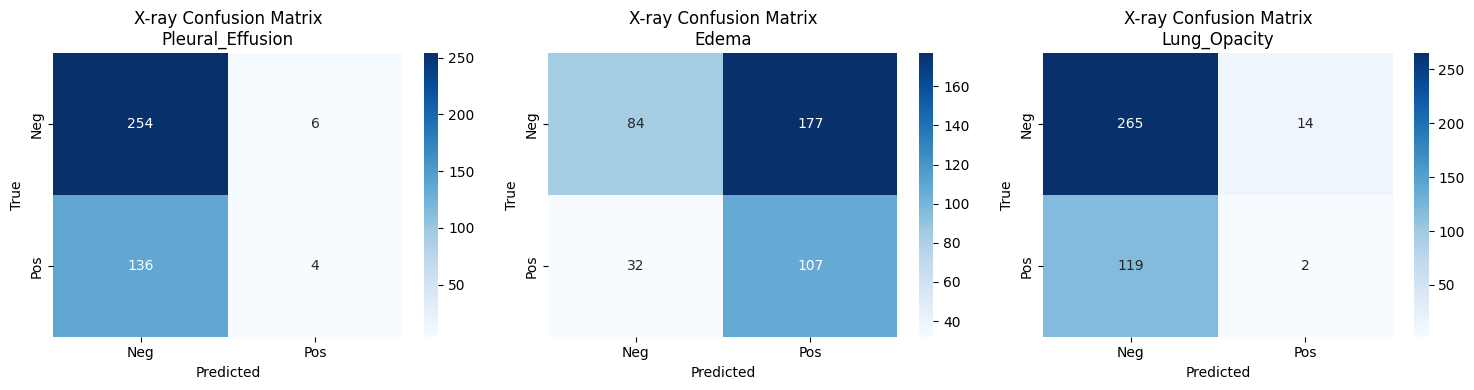

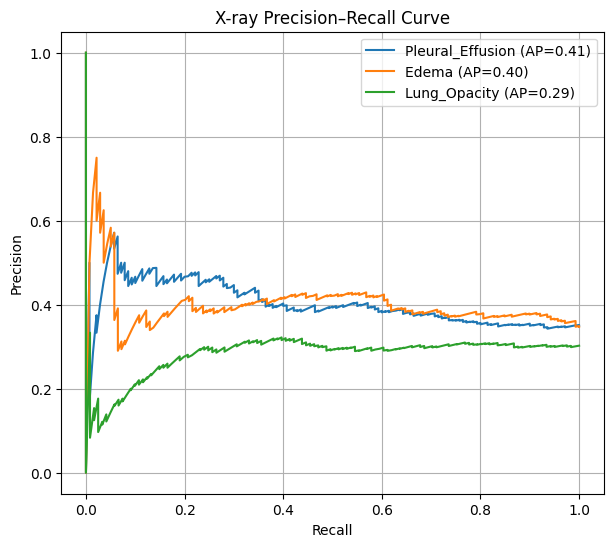

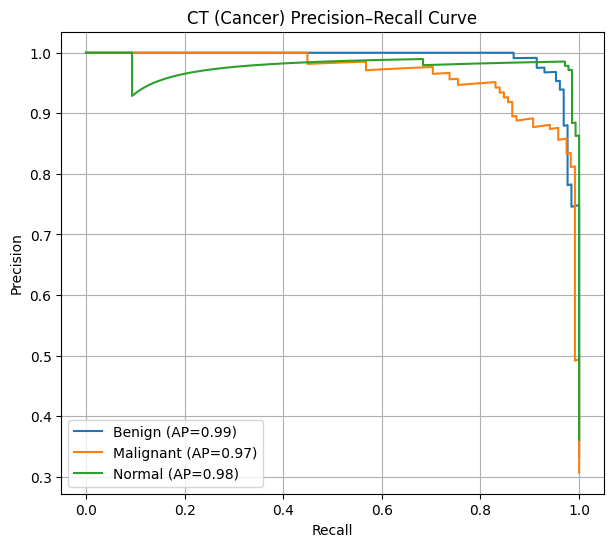


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         1.000000  0.648438  0.786730    128.0
Malignant      0.700599  0.991525  0.821053    118.0
Normal         0.977778  0.949640  0.963504    139.0
accuracy       0.862338  0.862338  0.862338    385.0
macro avg      0.892792  0.863201  0.857095    385.0
weighted avg   0.900212  0.862338  0.861072    385.0

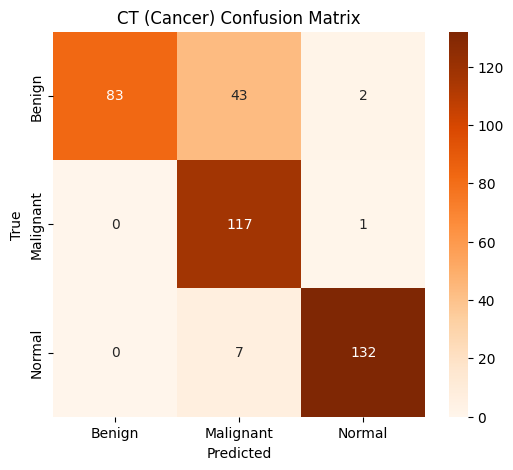

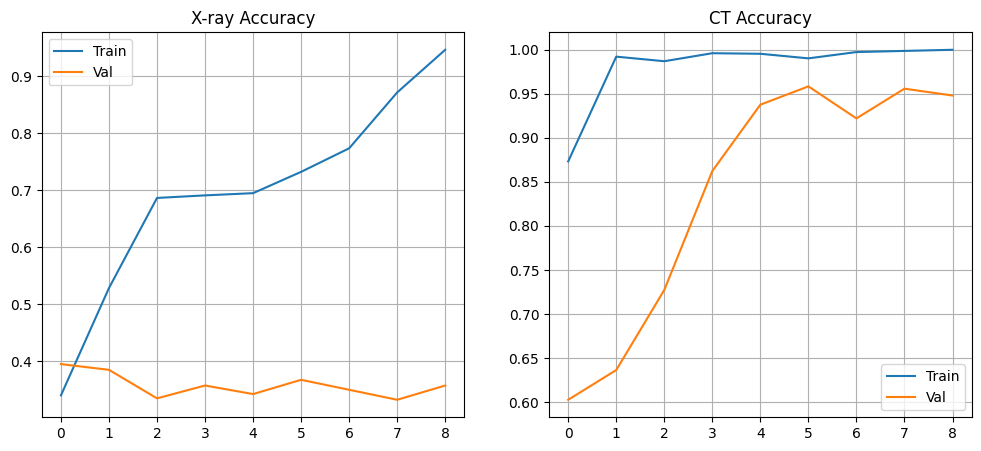

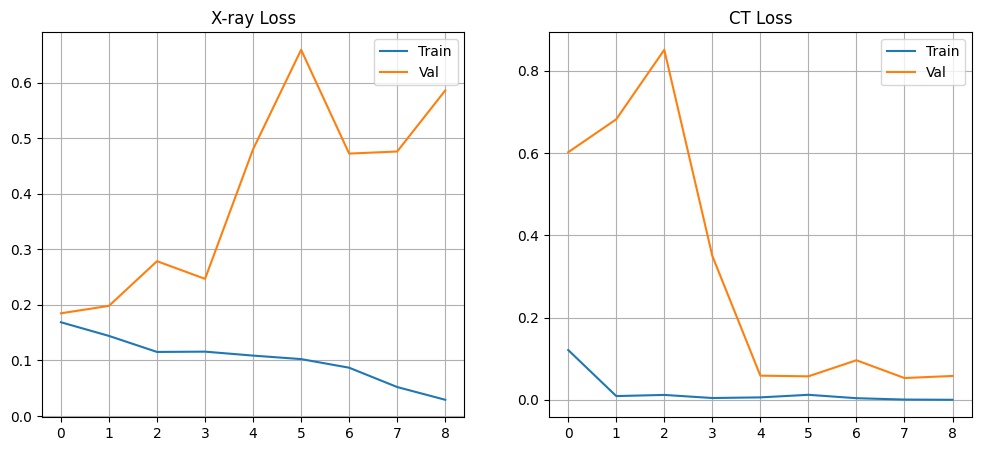

In [29]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with MobilenetV2**

In [30]:
backbone_name = "mobilenetv2"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385
  Image Size : 224x224


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_MOBILENETV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 1280)      │  2,257,984 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    655,872 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    655,872 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,572,806 (13.63 MB)

 Trainable params: 3,538,694 (13.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [31]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - ct_out_accuracy: 0.7144 - ct_out_loss: 0.2649 - loss: 0.4669 - xray_out_accuracy: 0.3147 - xray_out_loss: 0.2020
📌 Epoch 1: X-ray Acc=0.307, CT Acc=0.814, Val X-ray Acc=0.310, Val CT Acc=0.652
97/97 ━━━━━━━━━━━━━━━━━━━━ 158s 806ms/step - ct_out_accuracy: 0.7154 - ct_out_loss: 0.2639 - loss: 0.4658 - xray_out_accuracy: 0.3146 - xray_out_loss: 0.2019 - val_ct_out_accuracy: 0.6519 - val_ct_out_loss: 0.3843 - val_loss: 0.5965 - val_xray_out_accuracy: 0.3100 - val_xray_out_loss: 0.1996 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - ct_out_accuracy: 0.9863 - ct_out_loss: 0.0144 - loss: 0.1415 - xray_out_accuracy: 0.6670 - xray_out_loss: 0.1271
📌 Epoch 2: X-ray Acc=0.675, CT Acc=0.990, Val X-ray Acc=0.335, Val CT Acc=0.706
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - ct_out_accuracy: 0.9863 - ct_out_loss: 0.0144 - loss: 0.1414 - xray_out_accuracy: 0.6670 - xray_out_loss: 0.1271 - val_ct_out_accuracy: 0.706

In [32]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.22it/s]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.360406  0.507143  0.421365    140.0
Edema              0.377953  0.345324  0.360902    139.0
Lung_Opacity       0.363636  0.066116  0.111888    121.0
micro avg          0.367052  0.317500  0.340483    400.0
macro avg          0.367332  0.306194  0.298052    400.0
weighted avg       0.367481  0.317500  0.306737    400.0
samples avg        0.278750  0.317500  0.291667    400.0
accuracy           0.590000  0.590000  0.590000    400.0

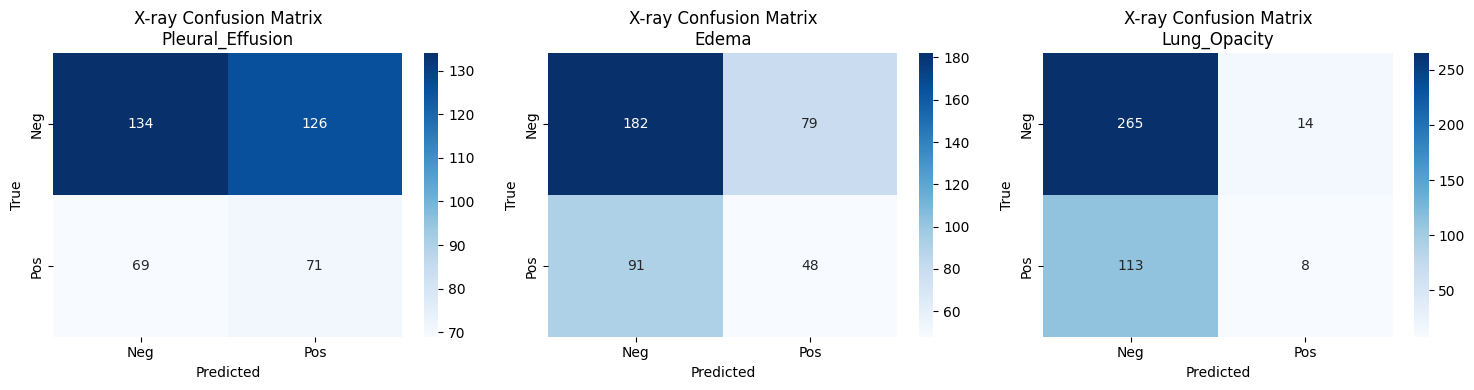

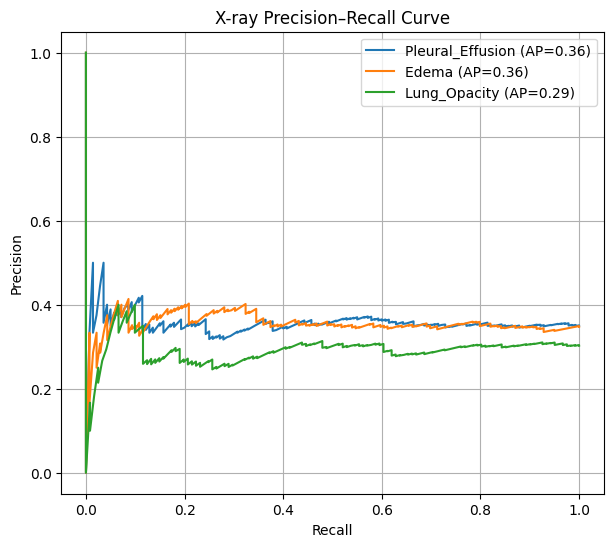

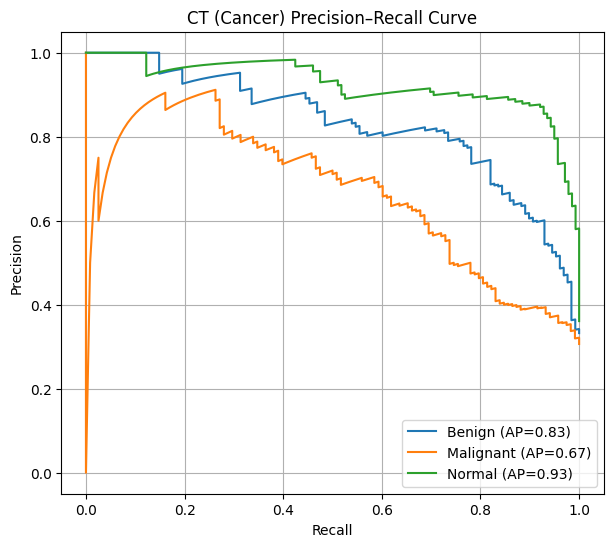


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.640000  0.875000  0.739274    128.0
Malignant      0.653465  0.559322  0.602740    118.0
Normal         0.889908  0.697842  0.782258    139.0
accuracy       0.714286  0.714286  0.714286    385.0
macro avg      0.727791  0.710721  0.708091    385.0
weighted avg   0.734354  0.714286  0.712946    385.0

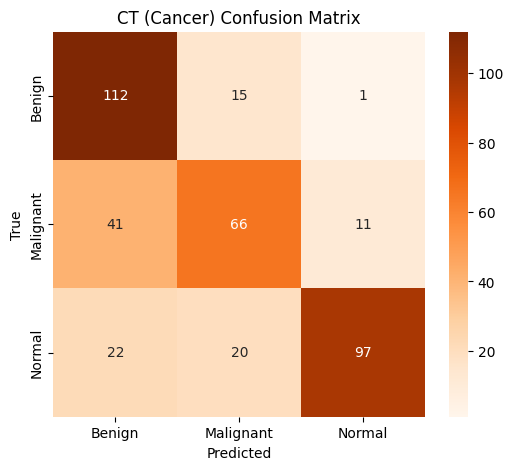

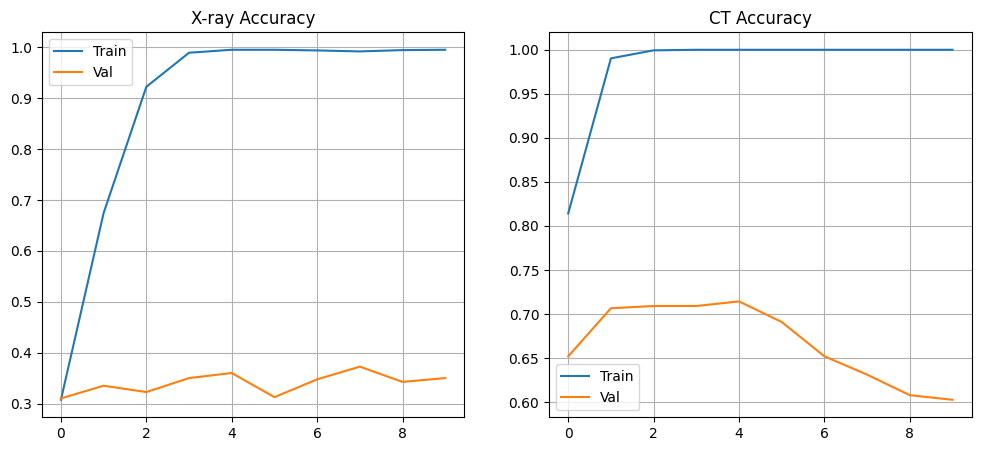

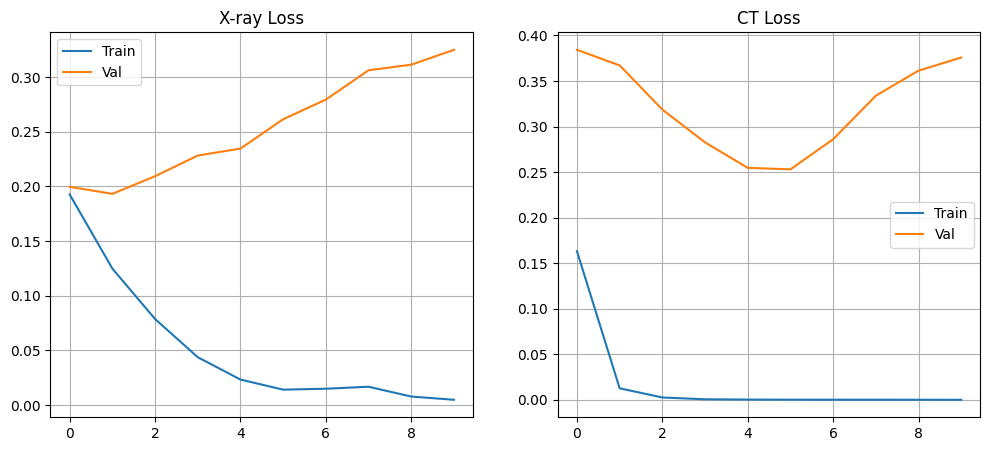

In [33]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with densenet169**

In [34]:
backbone_name = "densenet169"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385
  Image Size : 224x224


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_DENSENET169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet169         │ (None, 1664)      │ 12,642,880 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    852,480 │ densenet169[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    852,480 │ densenet169[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,350,918 (54.74 MB)

 Trainable params: 14,192,518 (54.14 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [35]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - ct_out_accuracy: 0.7797 - ct_out_loss: 0.2144 - loss: 0.4068 - xray_out_accuracy: 0.3135 - xray_out_loss: 0.1924   
📌 Epoch 1: X-ray Acc=0.320, CT Acc=0.865, Val X-ray Acc=0.338, Val CT Acc=0.605
97/97 ━━━━━━━━━━━━━━━━━━━━ 1171s 7s/step - ct_out_accuracy: 0.7805 - ct_out_loss: 0.2136 - loss: 0.4059 - xray_out_accuracy: 0.3136 - xray_out_loss: 0.1924 - val_ct_out_accuracy: 0.6052 - val_ct_out_loss: 0.7140 - val_loss: 0.9031 - val_xray_out_accuracy: 0.3375 - val_xray_out_loss: 0.2027 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - ct_out_accuracy: 0.9738 - ct_out_loss: 0.0242 - loss: 0.1771 - xray_out_accuracy: 0.4933 - xray_out_loss: 0.1530
📌 Epoch 2: X-ray Acc=0.515, CT Acc=0.979, Val X-ray Acc=0.368, Val CT Acc=0.800
97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 375ms/step - ct_out_accuracy: 0.9738 - ct_out_loss: 0.0243 - loss: 0.1771 - xray_out_accuracy: 0.4935 - xray_out_loss: 0.1529 - val_ct_out_accuracy: 0.8000 

In [36]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.000000  0.000000  0.000000    140.0
Edema              0.361413  0.956835  0.524655    139.0
Lung_Opacity       0.343750  0.090909  0.143791    121.0
micro avg          0.358209  0.360000  0.359102    400.0
macro avg          0.235054  0.349248  0.222815    400.0
weighted avg       0.229575  0.360000  0.225814    400.0
samples avg        0.341250  0.360000  0.347500    400.0
accuracy           0.571667  0.571667  0.571667    400.0

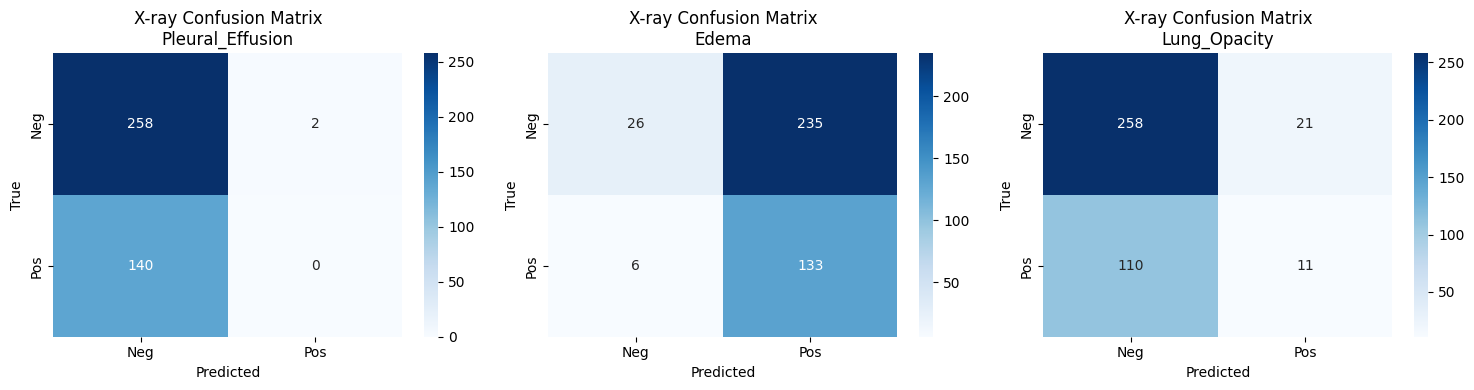

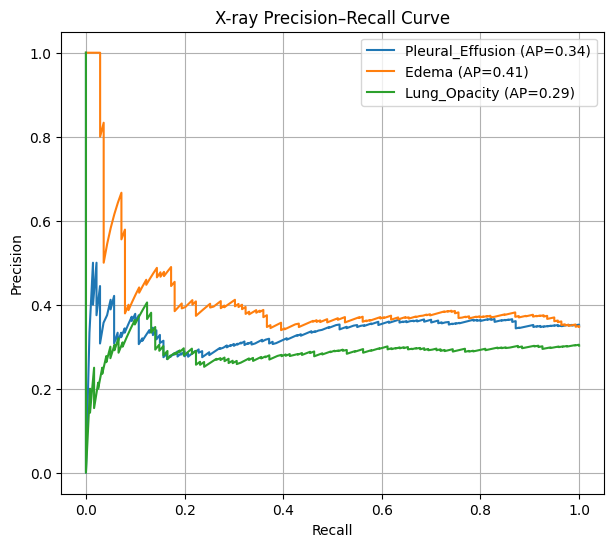

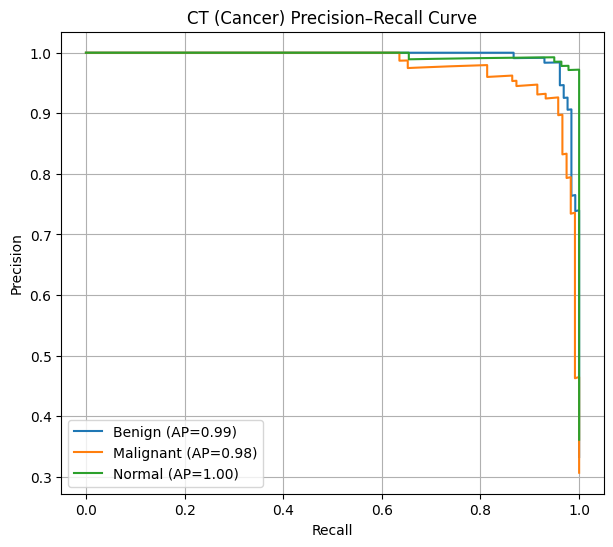


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.991304  0.890625  0.938272    128.0
Malignant      0.894309  0.932203  0.912863    118.0
Normal         0.945578  1.000000  0.972028    139.0
accuracy       0.942857  0.942857  0.942857    385.0
macro avg      0.943731  0.940943  0.941054    385.0
weighted avg   0.945067  0.942857  0.942671    385.0

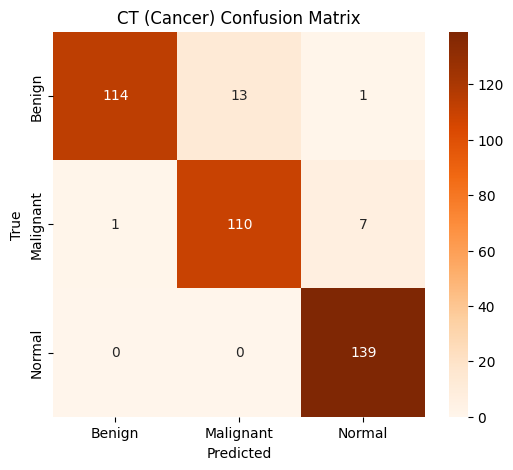

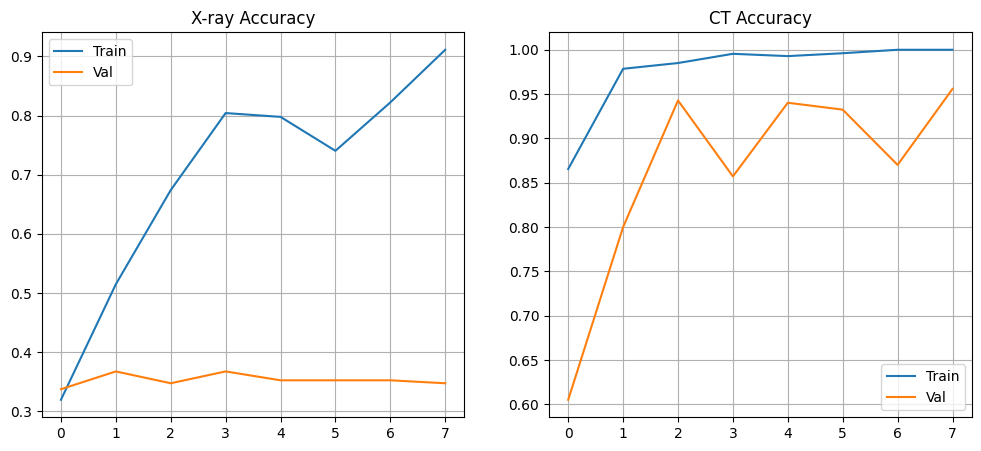

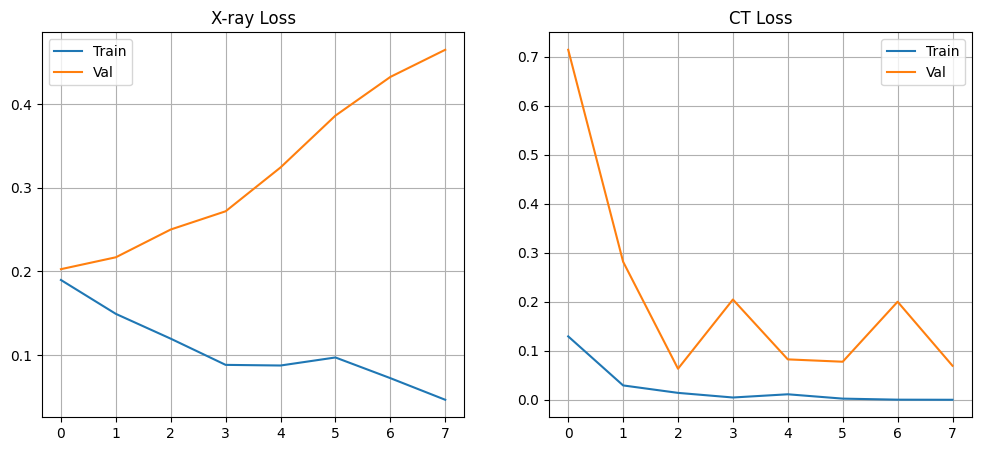

In [37]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with densenet201**

In [38]:
backbone_name = "densenet201"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385
  Image Size : 224x224


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_DENSENET201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet201         │ (None, 1920)      │ 18,321,984 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    983,552 │ densenet201[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    983,552 │ densenet201[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,292,166 (77.41 MB)

 Trainable params: 20,063,110 (76.53 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [39]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - ct_out_accuracy: 0.7625 - ct_out_loss: 0.2269 - loss: 0.4230 - xray_out_accuracy: 0.3251 - xray_out_loss: 0.1961  
📌 Epoch 1: X-ray Acc=0.327, CT Acc=0.860, Val X-ray Acc=0.360, Val CT Acc=0.639
97/97 ━━━━━━━━━━━━━━━━━━━━ 2301s 15s/step - ct_out_accuracy: 0.7635 - ct_out_loss: 0.2258 - loss: 0.4219 - xray_out_accuracy: 0.3251 - xray_out_loss: 0.1961 - val_ct_out_accuracy: 0.6390 - val_ct_out_loss: 0.3036 - val_loss: 0.4885 - val_xray_out_accuracy: 0.3600 - val_xray_out_loss: 0.1757 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - ct_out_accuracy: 0.9839 - ct_out_loss: 0.0171 - loss: 0.1668 - xray_out_accuracy: 0.4983 - xray_out_loss: 0.1497
📌 Epoch 2: X-ray Acc=0.521, CT Acc=0.988, Val X-ray Acc=0.373, Val CT Acc=0.829
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 493ms/step - ct_out_accuracy: 0.9839 - ct_out_loss: 0.0171 - loss: 0.1667 - xray_out_accuracy: 0.4985 - xray_out_loss: 0.1496 - val_ct_out_accuracy: 0.8286

In [40]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.176471  0.021429  0.038217    140.0
Edema              0.372549  0.683453  0.482234    139.0
Lung_Opacity       0.166667  0.008264  0.015748    121.0
micro avg          0.356115  0.247500  0.292035    400.0
macro avg          0.238562  0.237715  0.178733    400.0
weighted avg       0.241642  0.247500  0.185716    400.0
samples avg        0.245000  0.247500  0.245833    400.0
accuracy           0.600000  0.600000  0.600000    400.0

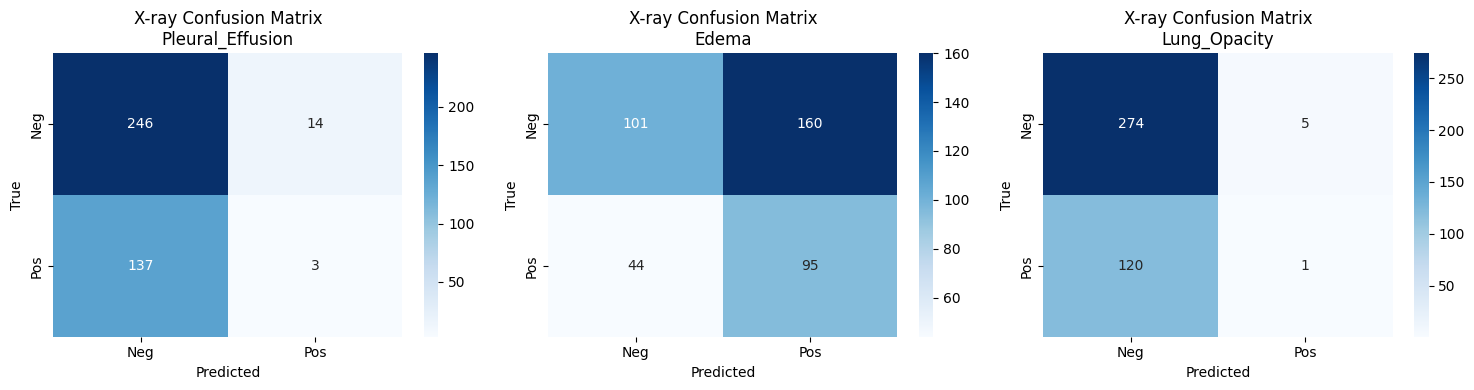

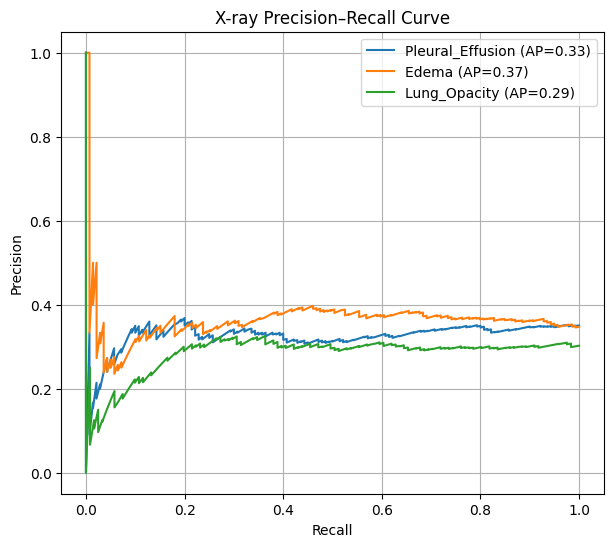

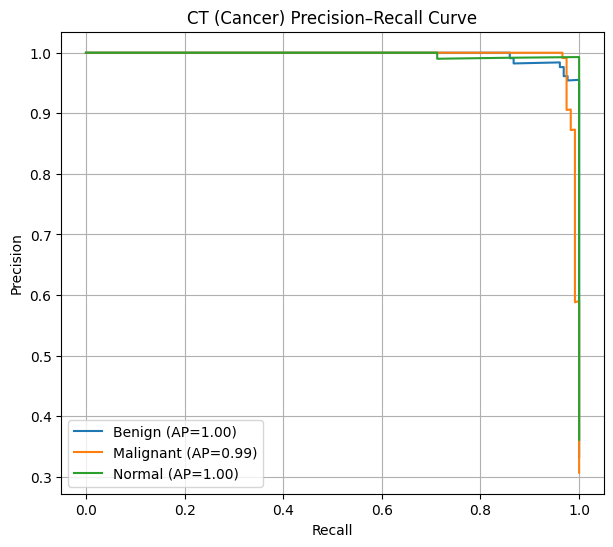


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.983333  0.921875  0.951613    128.0
Malignant      0.920000  0.974576  0.946502    118.0
Normal         0.985714  0.992806  0.989247    139.0
accuracy       0.963636  0.963636  0.963636    385.0
macro avg      0.963016  0.963086  0.962454    385.0
weighted avg   0.964782  0.963636  0.963634    385.0

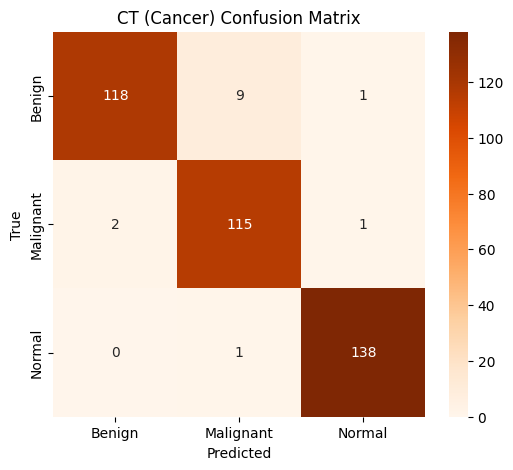

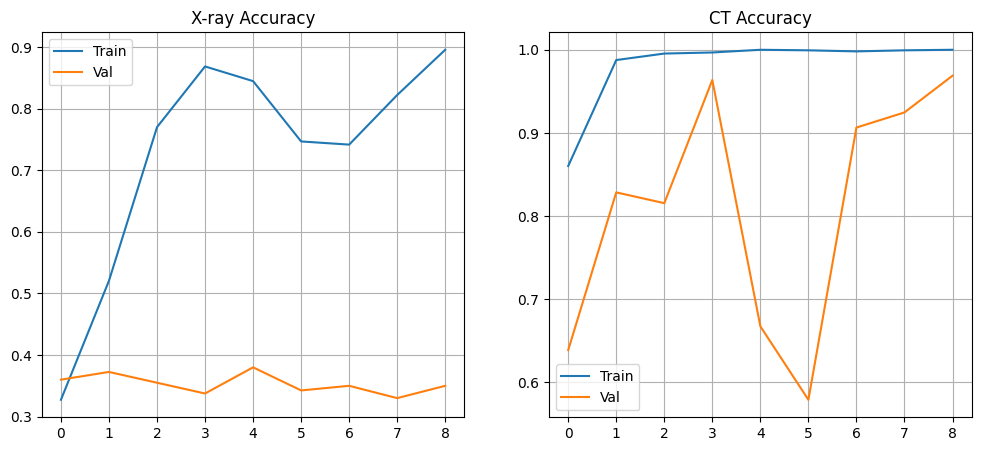

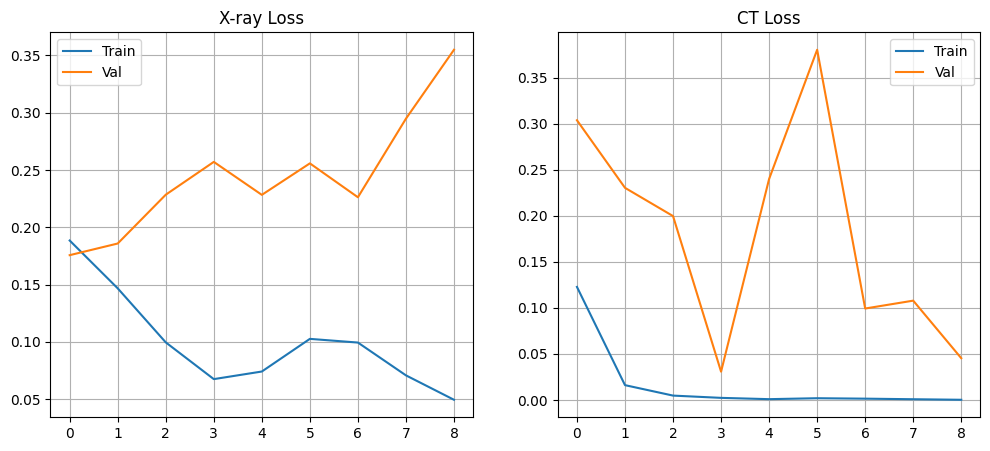

In [41]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with NasnetMobile**

In [42]:
backbone_name = "nasnetmobile"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385
  Image Size : 224x224


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Phase1_NASNETMOBILE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nasnet_mobile       │ (None, 1056)      │  4,269,716 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │    541,184 │ nasnet_mobile[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    541,184 │ nasnet_mobile[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,355,162 (20.43 MB)

 Trainable params: 5,318,424 (20.29 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [43]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - ct_out_accuracy: 0.6673 - ct_out_loss: 0.3213 - loss: 0.5059 - xray_out_accuracy: 0.3180 - xray_out_loss: 0.1846   
📌 Epoch 1: X-ray Acc=0.320, CT Acc=0.795, Val X-ray Acc=0.322, Val CT Acc=0.514
97/97 ━━━━━━━━━━━━━━━━━━━━ 599s 3s/step - ct_out_accuracy: 0.6686 - ct_out_loss: 0.3201 - loss: 0.5046 - xray_out_accuracy: 0.3181 - xray_out_loss: 0.1846 - val_ct_out_accuracy: 0.5143 - val_ct_out_loss: 1.0090 - val_loss: 1.1181 - val_xray_out_accuracy: 0.3225 - val_xray_out_loss: 0.1992 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - ct_out_accuracy: 0.9821 - ct_out_loss: 0.0220 - loss: 0.1683 - xray_out_accuracy: 0.5345 - xray_out_loss: 0.1463
📌 Epoch 2: X-ray Acc=0.534, CT Acc=0.987, Val X-ray Acc=0.320, Val CT Acc=0.439
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - ct_out_accuracy: 0.9822 - ct_out_loss: 0.0220 - loss: 0.1683 - xray_out_accuracy: 0.5345 - xray_out_loss: 0.1463 - val_ct_out_accuracy: 0.4390 -

In [44]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.315789  0.085714  0.134831    140.0
Edema              0.000000  0.000000  0.000000    139.0
Lung_Opacity       0.323944  0.380165  0.349810    121.0
micro avg          0.322222  0.145000  0.200000    400.0
macro avg          0.213244  0.155293  0.161547    400.0
weighted avg       0.208519  0.145000  0.153009    400.0
samples avg        0.137500  0.145000  0.140000    400.0
accuracy           0.613333  0.613333  0.613333    400.0

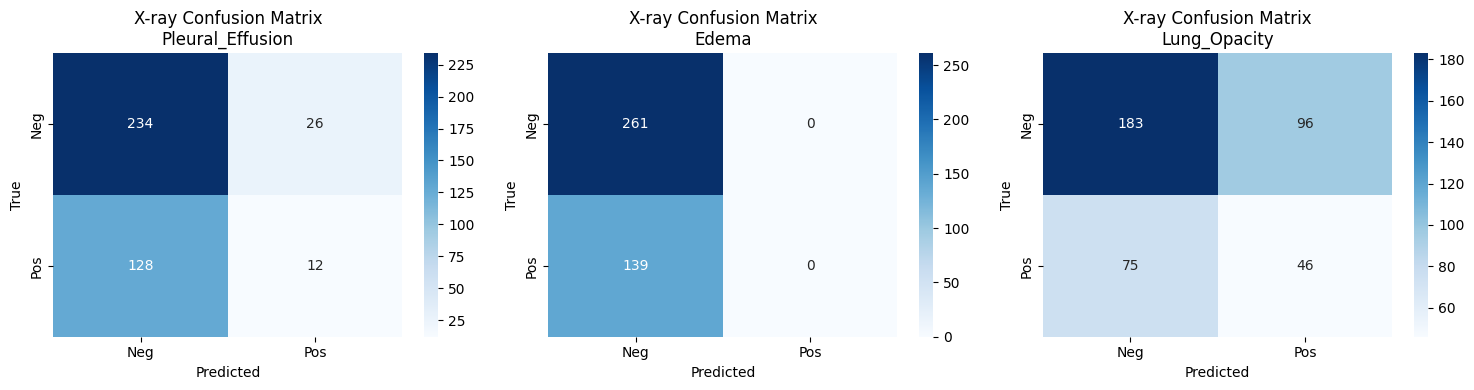

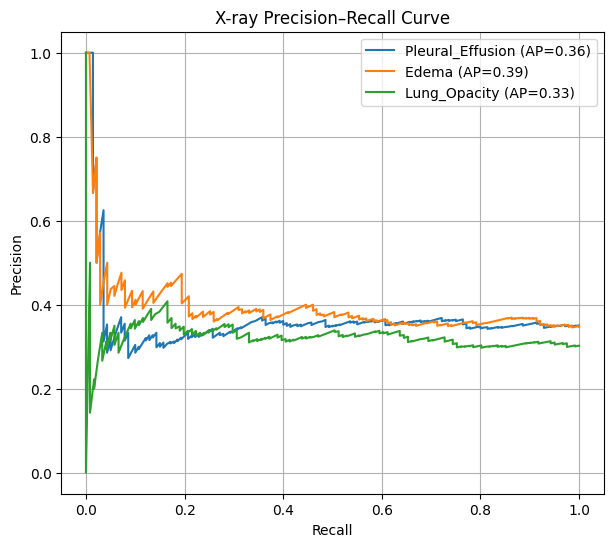

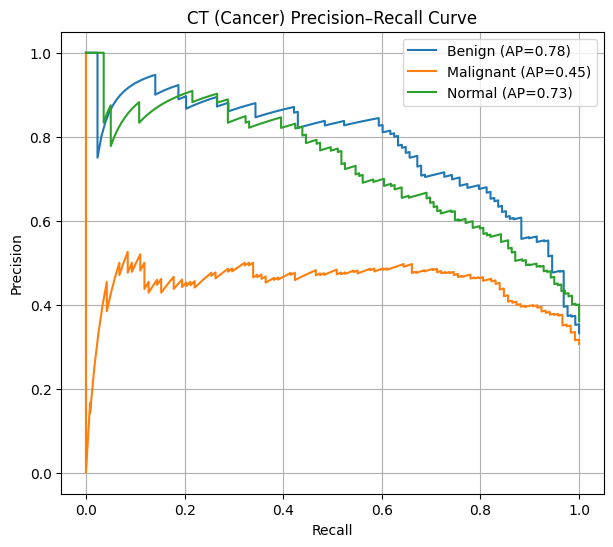


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         1.000000  0.007812  0.015504    128.0
Malignant      0.461957  0.720339  0.562914    118.0
Normal         0.560000  0.805755  0.660767    139.0
accuracy       0.514286  0.514286  0.514286    385.0
macro avg      0.673986  0.511302  0.413062    385.0
weighted avg   0.676236  0.514286  0.416247    385.0

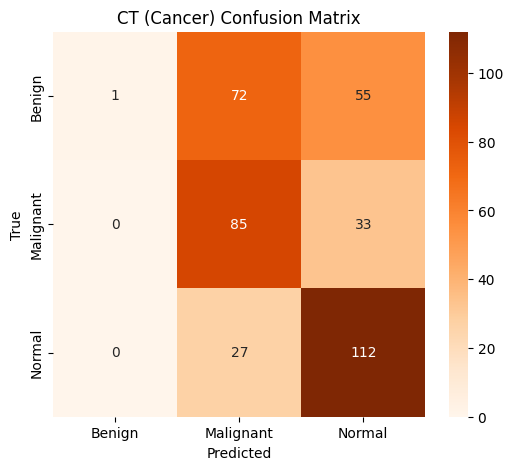

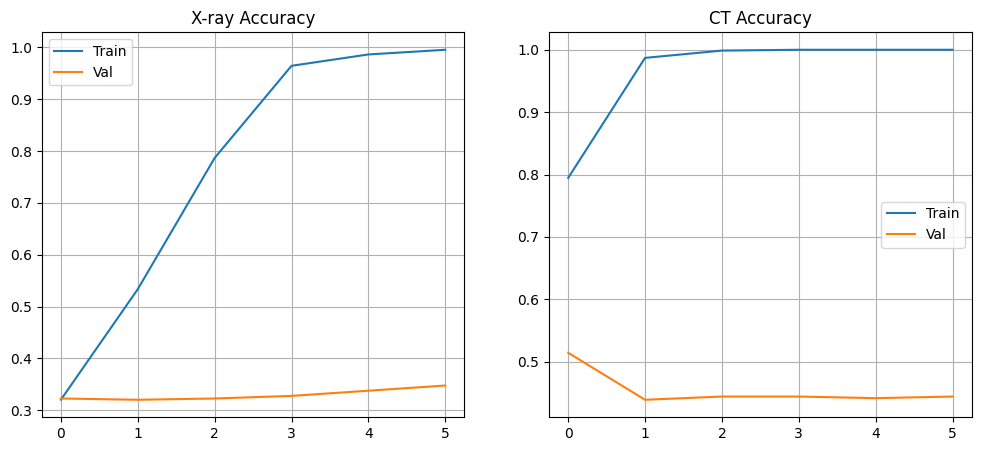

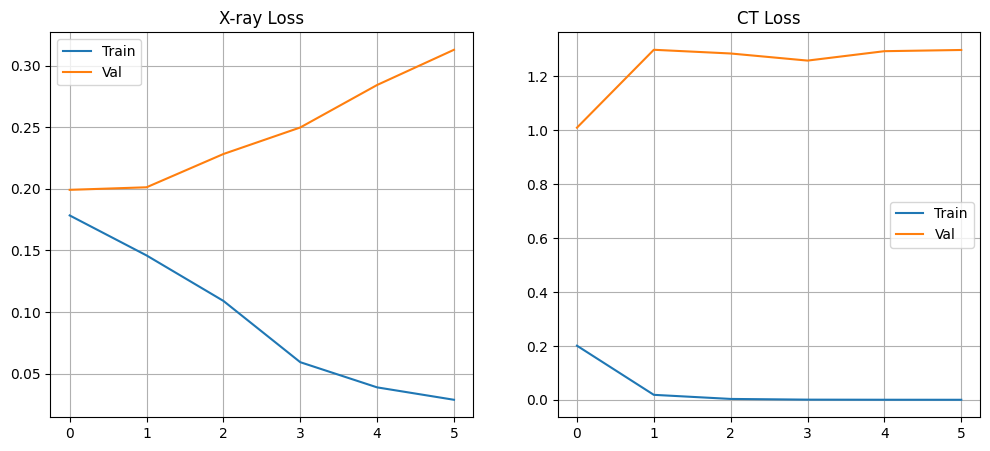

In [45]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with NasNetLarge**

In [38]:
backbone_name = "nasnetlarge"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data


  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385
  Image Size : 331x331


343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Model: "Phase1_NASNETLARGE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 331, 331,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 331, 331,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nasnet_large        │ (None, 4032)      │ 84,916,818 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │  2,064,896 │ nasnet_large[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  2,064,896 │ nasnet_large[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,049,688 (339.70 MB)

 Trainable params: 88,853,020 (338.95 MB)

 Non-trainable params: 196,668 (768.23 KB)

In [39]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - ct_out_accuracy: 0.7373 - ct_out_loss: 0.2311 - loss: 0.4019 - xray_out_accuracy: 0.3199 - xray_out_loss: 0.1707
📌 Epoch 1: X-ray Acc=0.303, CT Acc=0.865, Val X-ray Acc=0.345, Val CT Acc=0.751
97/97 ━━━━━━━━━━━━━━━━━━━━ 1165s 7s/step - ct_out_accuracy: 0.7386 - ct_out_loss: 0.2300 - loss: 0.4007 - xray_out_accuracy: 0.3198 - xray_out_loss: 0.1707 - val_ct_out_accuracy: 0.7506 - val_ct_out_loss: 0.2297 - val_loss: 0.4601 - val_xray_out_accuracy: 0.3450 - val_xray_out_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - ct_out_accuracy: 0.9895 - ct_out_loss: 0.0104 - loss: 0.1548 - xray_out_accuracy: 0.5850 - xray_out_loss: 0.1445
📌 Epoch 2: X-ray Acc=0.544, CT Acc=0.988, Val X-ray Acc=0.327, Val CT Acc=0.787
97/97 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - ct_out_accuracy: 0.9895 - ct_out_loss: 0.0104 - loss: 0.1549 - xray_out_accuracy: 0.5846 - xray_out_loss: 0.1445 - val_ct_out_accuracy: 0.7870 - val_ct

In [40]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.260000  0.092857  0.136842    140.0
Edema              0.373016  0.338129  0.354717    139.0
Lung_Opacity       0.200000  0.074380  0.108434    121.0
micro avg          0.312217  0.172500  0.222222    400.0
macro avg          0.277672  0.168456  0.199998    400.0
weighted avg       0.281123  0.172500  0.203960    400.0
samples avg        0.170000  0.172500  0.170833    400.0
accuracy           0.597500  0.597500  0.597500    400.0

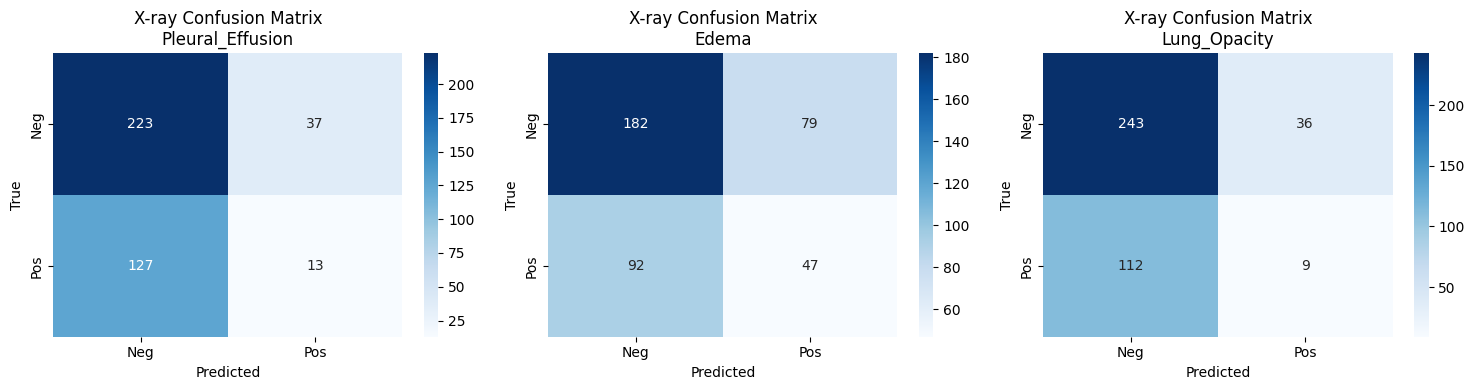

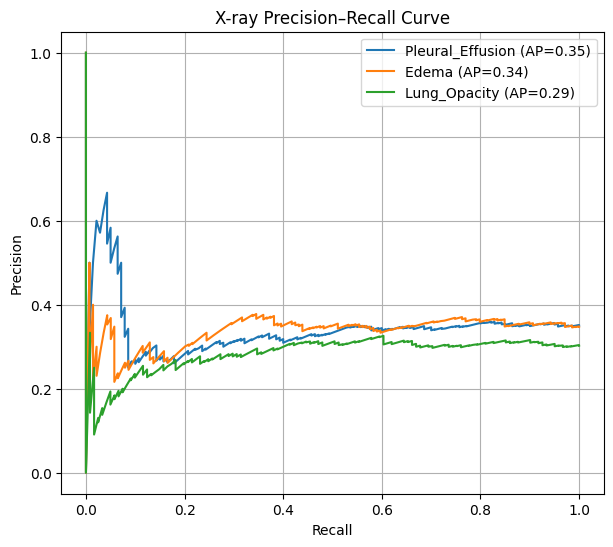

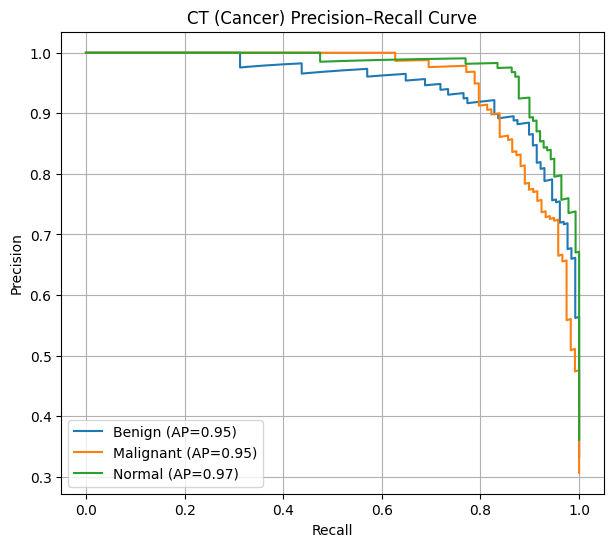


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.921739  0.828125  0.872428    128.0
Malignant      0.820312  0.889831  0.853659    118.0
Normal         0.901408  0.920863  0.911032    139.0
accuracy       0.880519  0.880519  0.880519    385.0
macro avg      0.881153  0.879606  0.879040    385.0
weighted avg   0.883312  0.880519  0.880613    385.0

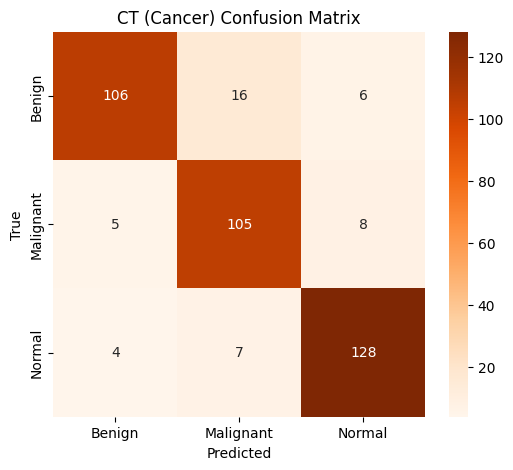

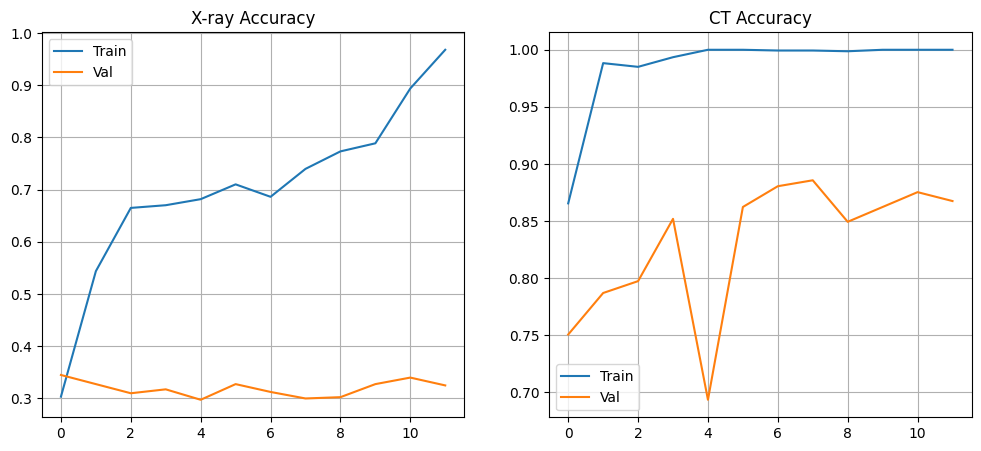

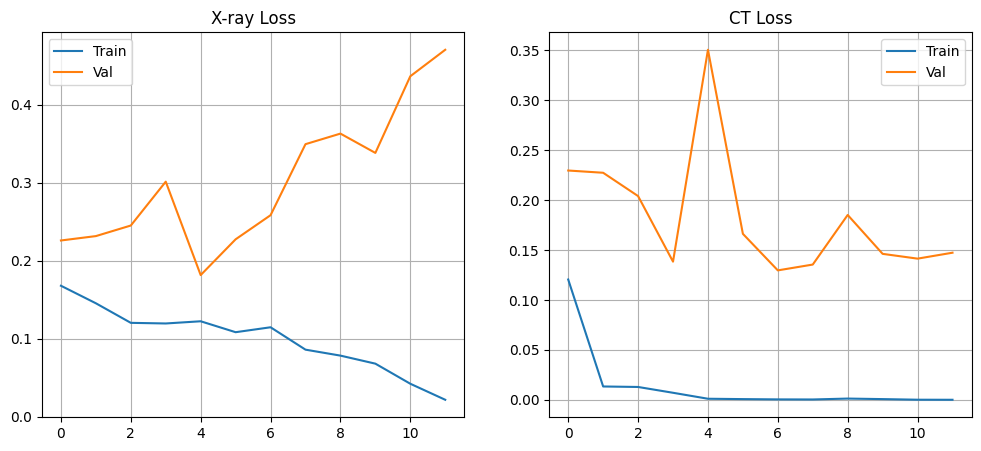

In [41]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with efficientnetv2s**

In [42]:
backbone_name = "efficientnetv2s"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385
  Image Size : 224x224


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "Phase1_EFFICIENTNETV2S"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-s    │ (None, 1280)      │ 20,331,360 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    655,872 │ efficientnetv2-s… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    655,872 │ efficientnetv2-s… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,646,182 (82.57 MB)

 Trainable params: 21,492,310 (81.99 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [43]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - ct_out_accuracy: 0.6591 - ct_out_loss: 0.3122 - loss: 0.4834 - xray_out_accuracy: 0.3280 - xray_out_loss: 0.1711   
📌 Epoch 1: X-ray Acc=0.340, CT Acc=0.792, Val X-ray Acc=0.370, Val CT Acc=0.896
97/97 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - ct_out_accuracy: 0.6604 - ct_out_loss: 0.3111 - loss: 0.4822 - xray_out_accuracy: 0.3281 - xray_out_loss: 0.1711 - val_ct_out_accuracy: 0.8961 - val_ct_out_loss: 0.1026 - val_loss: 0.2730 - val_xray_out_accuracy: 0.3700 - val_xray_out_loss: 0.1668 - learning_rate: 1.0000e-04
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - ct_out_accuracy: 0.9473 - ct_out_loss: 0.0463 - loss: 0.1994 - xray_out_accuracy: 0.4579 - xray_out_loss: 0.1531
📌 Epoch 2: X-ray Acc=0.468, CT Acc=0.956, Val X-ray Acc=0.368, Val CT Acc=0.938
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - ct_out_accuracy: 0.9474 - ct_out_loss: 0.0463 - loss: 0.1994 - xray_out_accuracy: 0.4580 - xray_out_loss: 0.1531 - val_ct_out_accuracy: 0.9377 -

In [44]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.263158  0.035714  0.062893    140.0
Edema              0.365942  0.726619  0.486747    139.0
Lung_Opacity       1.000000  0.008264  0.016393    121.0
micro avg          0.361486  0.267500  0.307471    400.0
macro avg          0.543033  0.256866  0.188678    400.0
weighted avg       0.521770  0.267500  0.196116    400.0
samples avg        0.266250  0.267500  0.266667    400.0
accuracy           0.598333  0.598333  0.598333    400.0

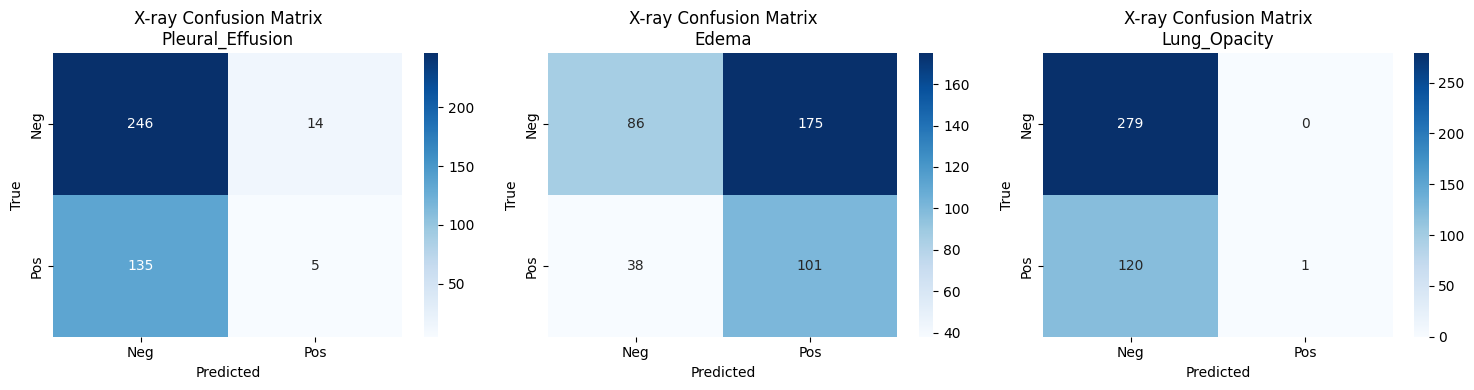

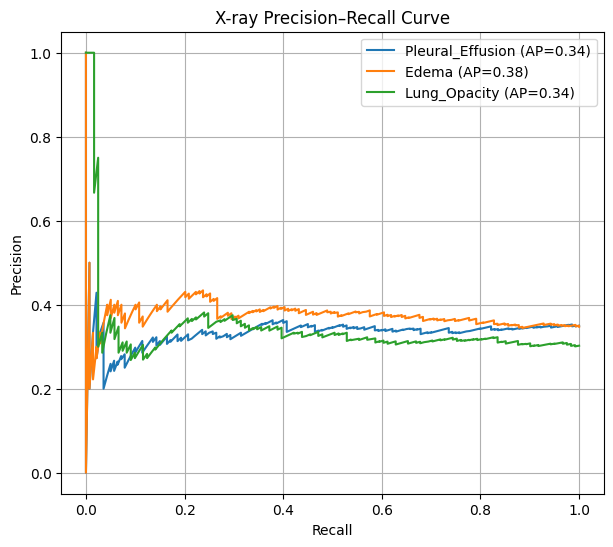

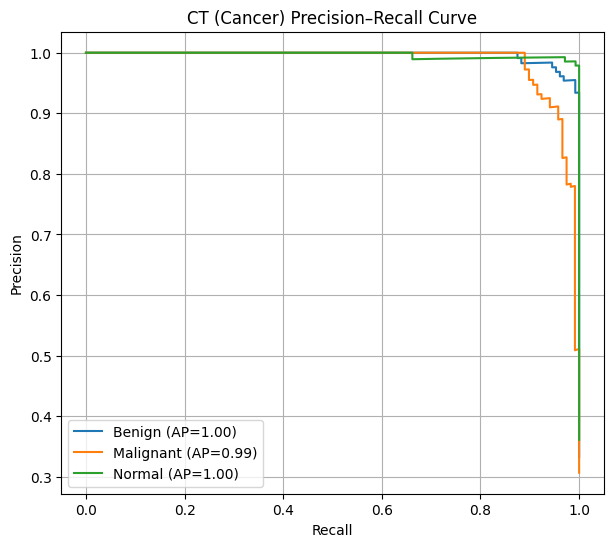


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.907801  1.000000  0.951673    128.0
Malignant      0.990291  0.864407  0.923077    118.0
Normal         0.971631  0.985612  0.978571    139.0
accuracy       0.953247  0.953247  0.953247    385.0
macro avg      0.956575  0.950006  0.951107    385.0
weighted avg   0.956129  0.953247  0.952620    385.0

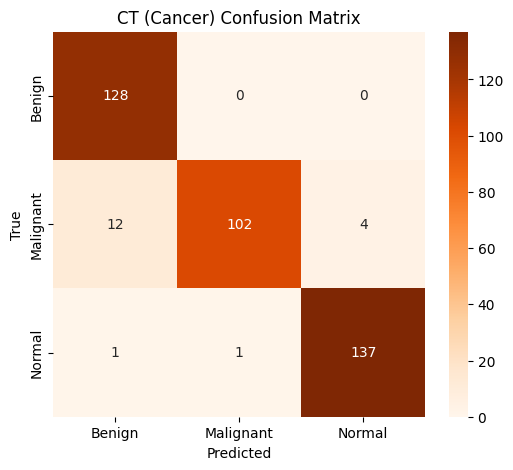

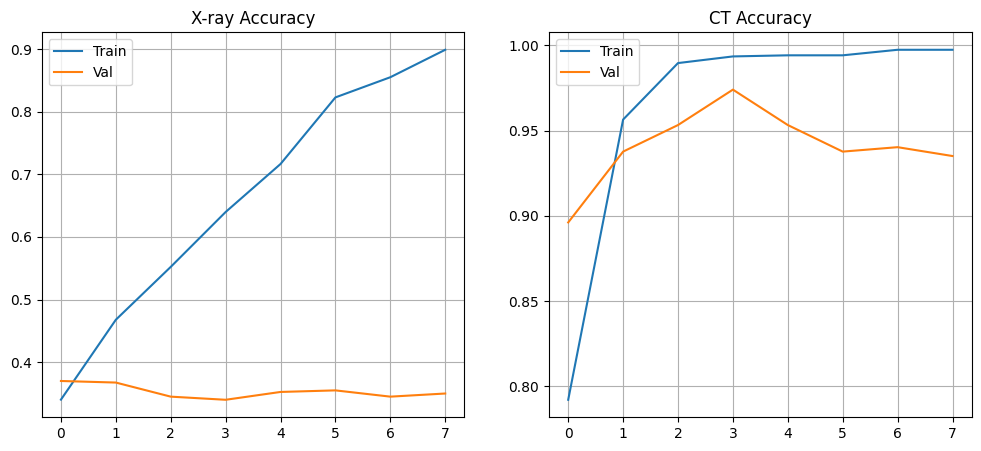

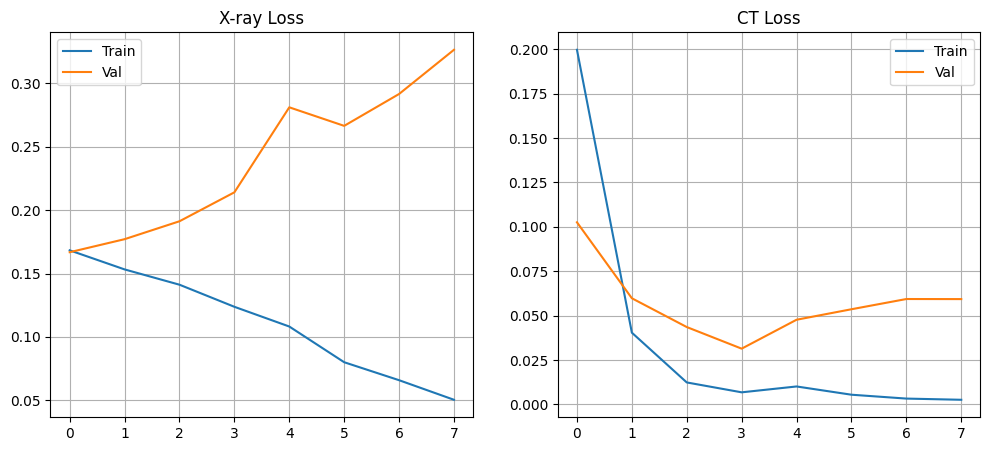

In [45]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )

**Experiment with convnextbase**

In [46]:
backbone_name = "convnextbase"   # change freely

img_size = get_backbone_input_size(backbone_name)

train_ds, val_ds, xray_classes, ct_classes = load_and_prepare_data(backbone_name=backbone_name)

model = build_and_compile_model(xray_classes,ct_classes,backbone_name=backbone_name)


📂 Loading X-ray data
  ▶ Pleural_Effusion: 1000 images


  ▶ Edema: 1000 images


  ▶ Lung_Opacity: 1000 images


✅ Total X-ray images loaded: 3000

📂 Loading CT data
  ▶ Benign: 592 images


  ▶ Malignant: 666 images


  ▶ Normal: 666 images


✅ Total CT images loaded: 1924

📊 Dataset Summary
  X-ray Train: 2400 | Val: 600
  CT    Train: 1539 | Val: 385
  Image Size : 224x224


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Model: "Phase1_CONVNEXTBASE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ct_input            │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base       │ (None, 1024)      │ 87,566,464 │ xray_input[0][0], │
│ (Functional)        │                   │            │ ct_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    524,800 │ convnext_base[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    524,800 │ convnext_base[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ct_out (Dense)      │ (None, 3)         │      1,539 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xray_out (Dense)    │ (None, 3)         │      1,539 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 88,619,142 (338.06 MB)

 Trainable params: 88,619,142 (338.06 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = train_model(model, train_ds, val_ds)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - ct_out_accuracy: 0.3254 - ct_out_loss: 0.4949 - loss: 0.6567 - xray_out_accuracy: 0.3321 - xray_out_loss: 0.1618
📌 Epoch 1: X-ray Acc=0.314, CT Acc=0.337, Val X-ray Acc=0.347, Val CT Acc=0.306
97/97 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - ct_out_accuracy: 0.3255 - ct_out_loss: 0.4950 - loss: 0.6568 - xray_out_accuracy: 0.3319 - xray_out_loss: 0.1618 - val_ct_out_accuracy: 0.3065 - val_ct_out_loss: 0.5070 - val_loss: 0.6674 - val_xray_out_accuracy: 0.3475 - val_xray_out_loss: 0.1619 - learning_rate: 2.5000e-05
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - ct_out_accuracy: 0.3445 - ct_out_loss: 0.4963 - loss: 0.6579 - xray_out_accuracy: 0.3410 - xray_out_loss: 0.1616
📌 Epoch 2: X-ray Acc=0.316, CT Acc=0.350, Val X-ray Acc=0.347, Val CT Acc=0.306
97/97 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - ct_out_accuracy: 0.3445 - ct_out_loss: 0.4963 - loss: 0.6580 - xray_out_accuracy: 0.3408 - xray_out_loss: 0.1616 - val_ct_out_accuracy: 0.3065 - val_ct_

In [50]:
xray_true, xray_pred, ct_true, ct_pred = run_validation(model, val_ds)


🔍 Running validation & prediction


Validating: 100%|██████████| 25/25 [06:29<00:00, 15.56s/it]

✅ Validation complete



X-RAY DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Pleural_Effusion   0.000000  0.000000  0.000000    140.0
Edema              0.000000  0.000000  0.000000    139.0
Lung_Opacity       0.000000  0.000000  0.000000    121.0
micro avg          0.000000  0.000000  0.000000    400.0
macro avg          0.000000  0.000000  0.000000    400.0
weighted avg       0.000000  0.000000  0.000000    400.0
samples avg        0.000000  0.000000  0.000000    400.0
accuracy           0.666667  0.666667  0.666667    400.0

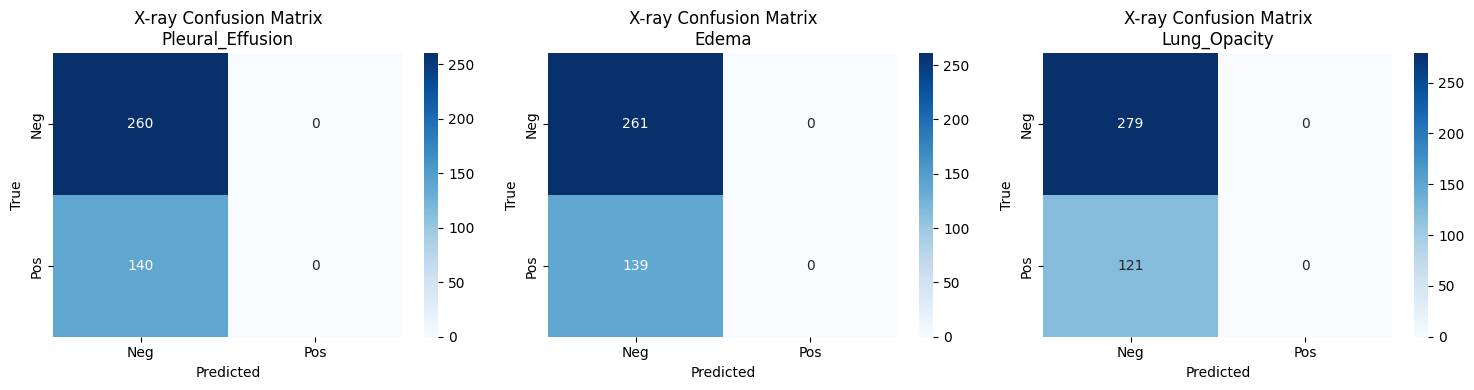

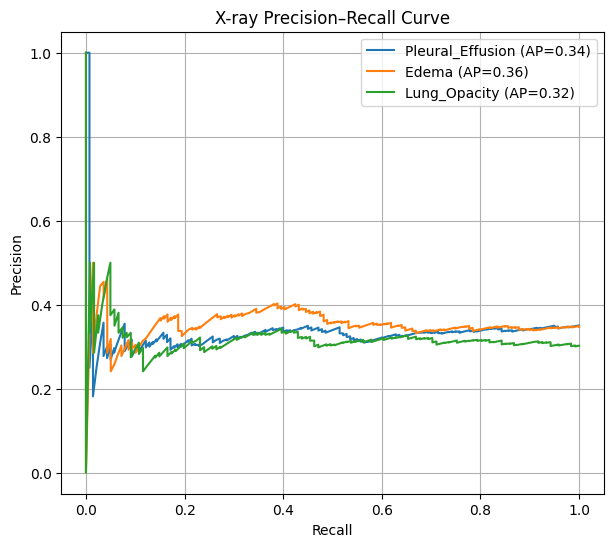

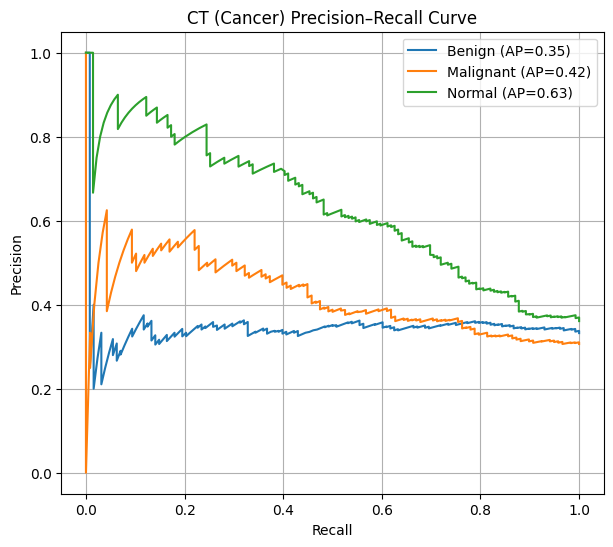


CT (CANCER) DIAGNOSIS REPORT (WITH ACCURACY)


precision    recall  f1-score  support
Benign         0.000000  0.000000  0.000000    128.0
Malignant      0.306494  1.000000  0.469185    118.0
Normal         0.000000  0.000000  0.000000    139.0
accuracy       0.306494  0.306494  0.306494    385.0
macro avg      0.102165  0.333333  0.156395    385.0
weighted avg   0.093938  0.306494  0.143802    385.0

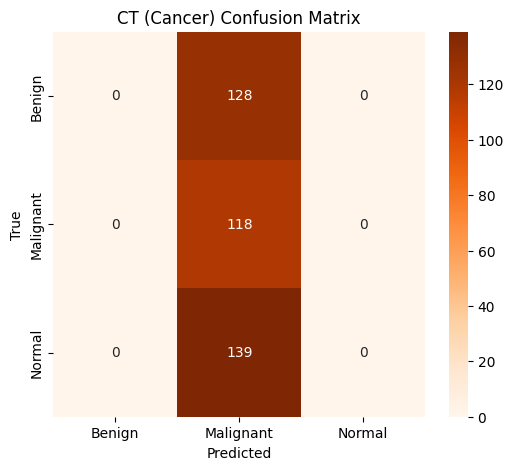

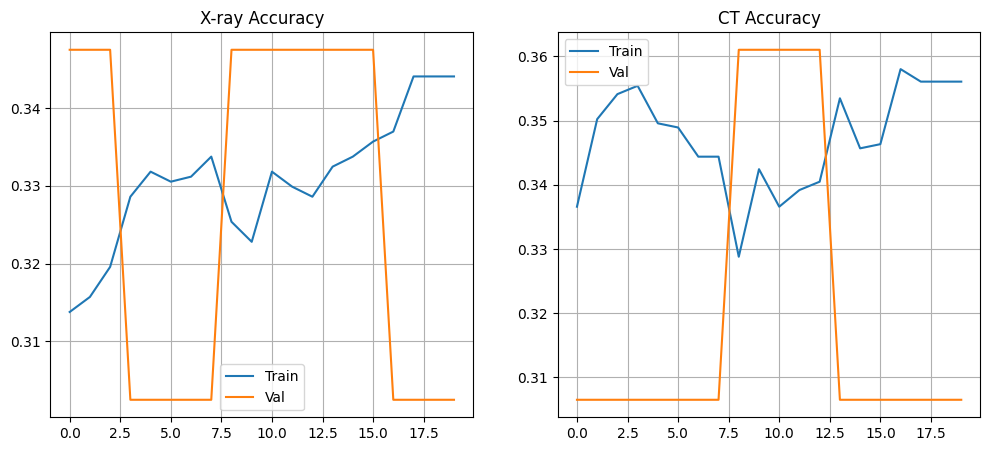

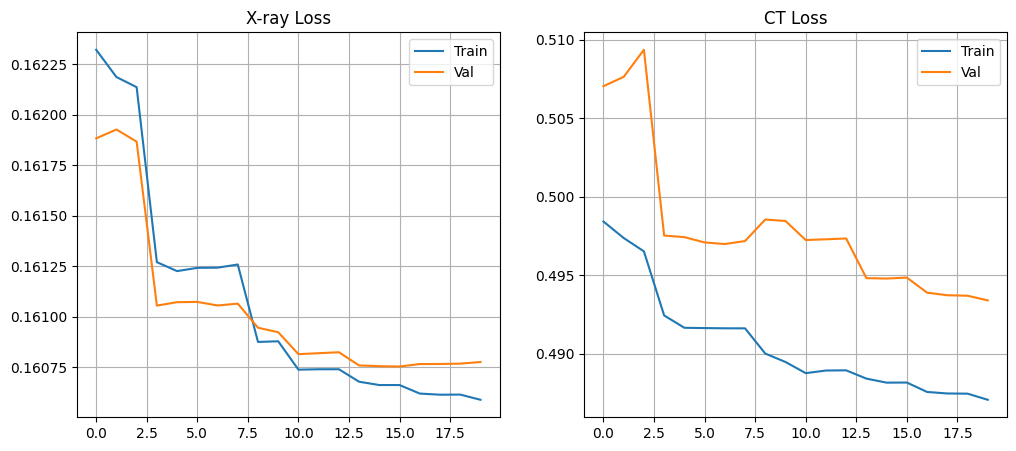

In [51]:
run_reports_and_plots(
        xray_true, xray_pred,
        ct_true, ct_pred,
        xray_classes, ct_classes,
        history
    )